In [1]:

# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4431872/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


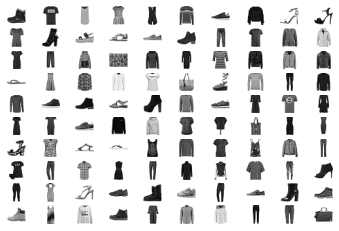

In [3]:
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [5]:

# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 

In [7]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model
 

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [9]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [10]:
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [11]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [12]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y
 

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')
 

In [14]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/home/Sukhandeep/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1, 1/468, d1=0.736, d2=0.695 g=0.692
>1, 2/468, d1=0.653, d2=0.697 g=0.689
>1, 3/468, d1=0.585, d2=0.701 g=0.687
>1, 4/468, d1=0.524, d2=0.704 g=0.686
>1, 5/468, d1=0.458, d2=0.704 g=0.688
>1, 6/468, d1=0.405, d2=0.701 g=0.693
>1, 7/468, d1=0.342, d2=0.696 g=0.699
>1, 8/468, d1=0.276, d2=0.692 g=0.704
>1, 9/468, d1=0.237, d2=0.701 g=0.696
>1, 10/468, d1=0.208, d2=0.736 g=0.666
>1, 11/468, d1=0.171, d2=0.788 g=0.625
>1, 12/468, d1=0.164, d2=0.865 g=0.586
>1, 13/468, d1=0.141, d2=0.947 g=0.552
>1, 14/468, d1=0.136, d2=0.993 g=0.543
>1, 15/468, d1=0.153, d2=1.000 g=0.570
>1, 16/468, d1=0.183, d2=0.933 g=0.656
>1, 17/468, d1=0.230, d2=0.797 g=0.797
>1, 18/468, d1=0.271, d2=0.624 g=0.989
>1, 19/468, d1=0.348, d2=0.472 g=1.210
>1, 20/468, d1=0.431, d2=0.392 g=1.363
>1, 21/468, d1=0.427, d2=0.340 g=1.397
>1, 22/468, d1=0.374, d2=0.334 g=1.448
>1, 23/468, d1=0.440, d2=0.412 g=1.222
>1, 24/468, d1=0.322, d2=0.549 g=1.010
>1, 25/468, d1=0.395, d2=0.673 g=0.793
>1, 26/468, d1=0.377, d2=0.762 g=0

>1, 211/468, d1=0.676, d2=0.589 g=0.905
>1, 212/468, d1=0.586, d2=0.605 g=0.935
>1, 213/468, d1=0.617, d2=0.703 g=0.828
>1, 214/468, d1=0.612, d2=0.752 g=0.740
>1, 215/468, d1=0.604, d2=0.813 g=0.694
>1, 216/468, d1=0.666, d2=0.914 g=0.683
>1, 217/468, d1=0.653, d2=0.843 g=0.700
>1, 218/468, d1=0.648, d2=0.776 g=0.801
>1, 219/468, d1=0.700, d2=0.685 g=0.864
>1, 220/468, d1=0.629, d2=0.637 g=0.966
>1, 221/468, d1=0.583, d2=0.566 g=1.015
>1, 222/468, d1=0.606, d2=0.557 g=1.031
>1, 223/468, d1=0.561, d2=0.601 g=0.961
>1, 224/468, d1=0.588, d2=0.680 g=0.902
>1, 225/468, d1=0.577, d2=0.761 g=0.772
>1, 226/468, d1=0.599, d2=0.837 g=0.700
>1, 227/468, d1=0.640, d2=0.924 g=0.698
>1, 228/468, d1=0.684, d2=0.868 g=0.733
>1, 229/468, d1=0.730, d2=0.813 g=0.782
>1, 230/468, d1=0.760, d2=0.739 g=0.870
>1, 231/468, d1=0.752, d2=0.623 g=0.907
>1, 232/468, d1=0.790, d2=0.578 g=0.977
>1, 233/468, d1=0.803, d2=0.564 g=1.038
>1, 234/468, d1=0.781, d2=0.533 g=1.064
>1, 235/468, d1=0.856, d2=0.534 g=1.043


>1, 418/468, d1=0.686, d2=0.645 g=0.788
>1, 419/468, d1=0.672, d2=0.652 g=0.777
>1, 420/468, d1=0.687, d2=0.651 g=0.781
>1, 421/468, d1=0.697, d2=0.659 g=0.780
>1, 422/468, d1=0.686, d2=0.654 g=0.790
>1, 423/468, d1=0.653, d2=0.672 g=0.767
>1, 424/468, d1=0.707, d2=0.648 g=0.764
>1, 425/468, d1=0.658, d2=0.667 g=0.755
>1, 426/468, d1=0.689, d2=0.668 g=0.764
>1, 427/468, d1=0.707, d2=0.674 g=0.765
>1, 428/468, d1=0.694, d2=0.669 g=0.737
>1, 429/468, d1=0.704, d2=0.684 g=0.744
>1, 430/468, d1=0.707, d2=0.703 g=0.731
>1, 431/468, d1=0.692, d2=0.711 g=0.740
>1, 432/468, d1=0.715, d2=0.699 g=0.725
>1, 433/468, d1=0.696, d2=0.698 g=0.739
>1, 434/468, d1=0.722, d2=0.695 g=0.739
>1, 435/468, d1=0.715, d2=0.689 g=0.735
>1, 436/468, d1=0.696, d2=0.692 g=0.734
>1, 437/468, d1=0.706, d2=0.683 g=0.736
>1, 438/468, d1=0.695, d2=0.693 g=0.760
>1, 439/468, d1=0.705, d2=0.664 g=0.744
>1, 440/468, d1=0.711, d2=0.672 g=0.763
>1, 441/468, d1=0.712, d2=0.655 g=0.788
>1, 442/468, d1=0.717, d2=0.647 g=0.782


>2, 159/468, d1=0.643, d2=0.552 g=0.930
>2, 160/468, d1=0.689, d2=0.548 g=0.863
>2, 161/468, d1=0.589, d2=0.578 g=0.878
>2, 162/468, d1=0.666, d2=0.651 g=0.833
>2, 163/468, d1=0.648, d2=0.709 g=0.775
>2, 164/468, d1=0.659, d2=0.730 g=0.722
>2, 165/468, d1=0.658, d2=0.718 g=0.743
>2, 166/468, d1=0.673, d2=0.701 g=0.719
>2, 167/468, d1=0.606, d2=0.724 g=0.753
>2, 168/468, d1=0.664, d2=0.692 g=0.751
>2, 169/468, d1=0.607, d2=0.658 g=0.810
>2, 170/468, d1=0.630, d2=0.636 g=0.803
>2, 171/468, d1=0.639, d2=0.614 g=0.849
>2, 172/468, d1=0.640, d2=0.604 g=0.870
>2, 173/468, d1=0.604, d2=0.598 g=0.905
>2, 174/468, d1=0.612, d2=0.570 g=0.924
>2, 175/468, d1=0.655, d2=0.602 g=0.888
>2, 176/468, d1=0.641, d2=0.577 g=0.849
>2, 177/468, d1=0.590, d2=0.628 g=0.843
>2, 178/468, d1=0.613, d2=0.641 g=0.781
>2, 179/468, d1=0.621, d2=0.686 g=0.763
>2, 180/468, d1=0.577, d2=0.676 g=0.763
>2, 181/468, d1=0.609, d2=0.693 g=0.770
>2, 182/468, d1=0.647, d2=0.660 g=0.807
>2, 183/468, d1=0.610, d2=0.641 g=0.829


>2, 364/468, d1=0.667, d2=0.736 g=0.760
>2, 365/468, d1=0.646, d2=0.695 g=0.784
>2, 366/468, d1=0.625, d2=0.662 g=0.825
>2, 367/468, d1=0.625, d2=0.665 g=0.807
>2, 368/468, d1=0.625, d2=0.670 g=0.766
>2, 369/468, d1=0.624, d2=0.714 g=0.722
>2, 370/468, d1=0.622, d2=0.723 g=0.692
>2, 371/468, d1=0.656, d2=0.761 g=0.712
>2, 372/468, d1=0.630, d2=0.730 g=0.752
>2, 373/468, d1=0.677, d2=0.683 g=0.810
>2, 374/468, d1=0.632, d2=0.657 g=0.834
>2, 375/468, d1=0.659, d2=0.618 g=0.869
>2, 376/468, d1=0.656, d2=0.630 g=0.863
>2, 377/468, d1=0.674, d2=0.643 g=0.792
>2, 378/468, d1=0.686, d2=0.679 g=0.751
>2, 379/468, d1=0.613, d2=0.702 g=0.729
>2, 380/468, d1=0.645, d2=0.723 g=0.717
>2, 381/468, d1=0.669, d2=0.742 g=0.748
>2, 382/468, d1=0.644, d2=0.720 g=0.780
>2, 383/468, d1=0.654, d2=0.677 g=0.794
>2, 384/468, d1=0.616, d2=0.666 g=0.803
>2, 385/468, d1=0.656, d2=0.676 g=0.825
>2, 386/468, d1=0.668, d2=0.691 g=0.753
>2, 387/468, d1=0.610, d2=0.707 g=0.737
>2, 388/468, d1=0.634, d2=0.736 g=0.742


>3, 106/468, d1=0.667, d2=0.581 g=0.913
>3, 107/468, d1=0.704, d2=0.576 g=0.918
>3, 108/468, d1=0.707, d2=0.588 g=0.900
>3, 109/468, d1=0.659, d2=0.596 g=0.874
>3, 110/468, d1=0.702, d2=0.623 g=0.812
>3, 111/468, d1=0.643, d2=0.678 g=0.806
>3, 112/468, d1=0.661, d2=0.757 g=0.776
>3, 113/468, d1=0.668, d2=0.724 g=0.773
>3, 114/468, d1=0.675, d2=0.651 g=0.837
>3, 115/468, d1=0.693, d2=0.653 g=0.866
>3, 116/468, d1=0.675, d2=0.616 g=0.881
>3, 117/468, d1=0.702, d2=0.581 g=0.910
>3, 118/468, d1=0.693, d2=0.637 g=0.884
>3, 119/468, d1=0.668, d2=0.697 g=0.801
>3, 120/468, d1=0.694, d2=0.672 g=0.804
>3, 121/468, d1=0.670, d2=0.664 g=0.776
>3, 122/468, d1=0.691, d2=0.738 g=0.813
>3, 123/468, d1=0.682, d2=0.676 g=0.816
>3, 124/468, d1=0.678, d2=0.603 g=0.895
>3, 125/468, d1=0.680, d2=0.562 g=0.927
>3, 126/468, d1=0.701, d2=0.545 g=0.947
>3, 127/468, d1=0.691, d2=0.516 g=0.935
>3, 128/468, d1=0.679, d2=0.541 g=0.944
>3, 129/468, d1=0.631, d2=0.557 g=0.938
>3, 130/468, d1=0.671, d2=0.566 g=0.896


>3, 311/468, d1=0.625, d2=0.616 g=0.840
>3, 312/468, d1=0.650, d2=0.637 g=0.796
>3, 313/468, d1=0.635, d2=0.688 g=0.853
>3, 314/468, d1=0.689, d2=0.653 g=0.786
>3, 315/468, d1=0.640, d2=0.675 g=0.777
>3, 316/468, d1=0.648, d2=0.659 g=0.768
>3, 317/468, d1=0.674, d2=0.678 g=0.790
>3, 318/468, d1=0.642, d2=0.689 g=0.804
>3, 319/468, d1=0.649, d2=0.648 g=0.821
>3, 320/468, d1=0.665, d2=0.649 g=0.852
>3, 321/468, d1=0.678, d2=0.610 g=0.873
>3, 322/468, d1=0.675, d2=0.594 g=0.891
>3, 323/468, d1=0.704, d2=0.610 g=0.889
>3, 324/468, d1=0.699, d2=0.597 g=0.886
>3, 325/468, d1=0.686, d2=0.595 g=0.862
>3, 326/468, d1=0.660, d2=0.619 g=0.809
>3, 327/468, d1=0.696, d2=0.662 g=0.800
>3, 328/468, d1=0.661, d2=0.664 g=0.774
>3, 329/468, d1=0.675, d2=0.688 g=0.760
>3, 330/468, d1=0.656, d2=0.664 g=0.776
>3, 331/468, d1=0.668, d2=0.648 g=0.745
>3, 332/468, d1=0.680, d2=0.684 g=0.772
>3, 333/468, d1=0.658, d2=0.652 g=0.787
>3, 334/468, d1=0.684, d2=0.658 g=0.786
>3, 335/468, d1=0.622, d2=0.665 g=0.774


>4, 52/468, d1=0.687, d2=0.640 g=0.795
>4, 53/468, d1=0.674, d2=0.635 g=0.775
>4, 54/468, d1=0.684, d2=0.643 g=0.794
>4, 55/468, d1=0.639, d2=0.653 g=0.780
>4, 56/468, d1=0.649, d2=0.648 g=0.764
>4, 57/468, d1=0.643, d2=0.638 g=0.779
>4, 58/468, d1=0.647, d2=0.662 g=0.786
>4, 59/468, d1=0.633, d2=0.660 g=0.792
>4, 60/468, d1=0.644, d2=0.648 g=0.762
>4, 61/468, d1=0.639, d2=0.647 g=0.796
>4, 62/468, d1=0.640, d2=0.657 g=0.778
>4, 63/468, d1=0.648, d2=0.656 g=0.777
>4, 64/468, d1=0.642, d2=0.657 g=0.791
>4, 65/468, d1=0.648, d2=0.646 g=0.787
>4, 66/468, d1=0.670, d2=0.646 g=0.794
>4, 67/468, d1=0.655, d2=0.657 g=0.815
>4, 68/468, d1=0.654, d2=0.623 g=0.789
>4, 69/468, d1=0.657, d2=0.623 g=0.807
>4, 70/468, d1=0.655, d2=0.656 g=0.775
>4, 71/468, d1=0.668, d2=0.676 g=0.761
>4, 72/468, d1=0.665, d2=0.650 g=0.773
>4, 73/468, d1=0.667, d2=0.663 g=0.778
>4, 74/468, d1=0.651, d2=0.660 g=0.782
>4, 75/468, d1=0.612, d2=0.670 g=0.780
>4, 76/468, d1=0.649, d2=0.653 g=0.771
>4, 77/468, d1=0.603, d2=

>4, 259/468, d1=0.667, d2=0.655 g=0.780
>4, 260/468, d1=0.660, d2=0.649 g=0.770
>4, 261/468, d1=0.693, d2=0.646 g=0.812
>4, 262/468, d1=0.693, d2=0.639 g=0.805
>4, 263/468, d1=0.657, d2=0.664 g=0.802
>4, 264/468, d1=0.729, d2=0.627 g=0.822
>4, 265/468, d1=0.689, d2=0.666 g=0.776
>4, 266/468, d1=0.711, d2=0.649 g=0.793
>4, 267/468, d1=0.671, d2=0.644 g=0.799
>4, 268/468, d1=0.675, d2=0.650 g=0.796
>4, 269/468, d1=0.670, d2=0.626 g=0.819
>4, 270/468, d1=0.669, d2=0.619 g=0.814
>4, 271/468, d1=0.669, d2=0.622 g=0.808
>4, 272/468, d1=0.696, d2=0.643 g=0.804
>4, 273/468, d1=0.670, d2=0.642 g=0.799
>4, 274/468, d1=0.657, d2=0.639 g=0.813
>4, 275/468, d1=0.637, d2=0.650 g=0.827
>4, 276/468, d1=0.673, d2=0.634 g=0.828
>4, 277/468, d1=0.665, d2=0.627 g=0.800
>4, 278/468, d1=0.690, d2=0.665 g=0.805
>4, 279/468, d1=0.650, d2=0.641 g=0.780
>4, 280/468, d1=0.652, d2=0.644 g=0.798
>4, 281/468, d1=0.679, d2=0.653 g=0.810
>4, 282/468, d1=0.670, d2=0.636 g=0.799
>4, 283/468, d1=0.664, d2=0.653 g=0.819


>4, 466/468, d1=0.641, d2=0.626 g=0.823
>4, 467/468, d1=0.694, d2=0.630 g=0.790
>4, 468/468, d1=0.678, d2=0.675 g=0.769
>5, 1/468, d1=0.716, d2=0.696 g=0.762
>5, 2/468, d1=0.672, d2=0.670 g=0.776
>5, 3/468, d1=0.658, d2=0.672 g=0.771
>5, 4/468, d1=0.650, d2=0.654 g=0.795
>5, 5/468, d1=0.627, d2=0.663 g=0.781
>5, 6/468, d1=0.663, d2=0.674 g=0.743
>5, 7/468, d1=0.687, d2=0.738 g=0.771
>5, 8/468, d1=0.698, d2=0.661 g=0.776
>5, 9/468, d1=0.670, d2=0.654 g=0.815
>5, 10/468, d1=0.684, d2=0.630 g=0.826
>5, 11/468, d1=0.686, d2=0.615 g=0.838
>5, 12/468, d1=0.660, d2=0.636 g=0.793
>5, 13/468, d1=0.688, d2=0.671 g=0.788
>5, 14/468, d1=0.674, d2=0.670 g=0.774
>5, 15/468, d1=0.668, d2=0.684 g=0.782
>5, 16/468, d1=0.679, d2=0.665 g=0.779
>5, 17/468, d1=0.682, d2=0.662 g=0.790
>5, 18/468, d1=0.667, d2=0.670 g=0.785
>5, 19/468, d1=0.658, d2=0.657 g=0.776
>5, 20/468, d1=0.656, d2=0.694 g=0.792
>5, 21/468, d1=0.691, d2=0.680 g=0.784
>5, 22/468, d1=0.655, d2=0.686 g=0.751
>5, 23/468, d1=0.659, d2=0.667 

>5, 208/468, d1=0.685, d2=0.663 g=0.765
>5, 209/468, d1=0.660, d2=0.641 g=0.786
>5, 210/468, d1=0.671, d2=0.643 g=0.835
>5, 211/468, d1=0.661, d2=0.607 g=0.853
>5, 212/468, d1=0.675, d2=0.637 g=0.827
>5, 213/468, d1=0.672, d2=0.640 g=0.782
>5, 214/468, d1=0.642, d2=0.658 g=0.775
>5, 215/468, d1=0.645, d2=0.667 g=0.763
>5, 216/468, d1=0.633, d2=0.738 g=0.751
>5, 217/468, d1=0.683, d2=0.694 g=0.765
>5, 218/468, d1=0.656, d2=0.671 g=0.818
>5, 219/468, d1=0.693, d2=0.609 g=0.840
>5, 220/468, d1=0.705, d2=0.655 g=0.820
>5, 221/468, d1=0.644, d2=0.637 g=0.817
>5, 222/468, d1=0.637, d2=0.648 g=0.819
>5, 223/468, d1=0.680, d2=0.676 g=0.802
>5, 224/468, d1=0.663, d2=0.655 g=0.801
>5, 225/468, d1=0.679, d2=0.641 g=0.790
>5, 226/468, d1=0.659, d2=0.647 g=0.781
>5, 227/468, d1=0.670, d2=0.665 g=0.765
>5, 228/468, d1=0.673, d2=0.648 g=0.773
>5, 229/468, d1=0.664, d2=0.645 g=0.787
>5, 230/468, d1=0.673, d2=0.632 g=0.816
>5, 231/468, d1=0.673, d2=0.643 g=0.803
>5, 232/468, d1=0.676, d2=0.623 g=0.818


>5, 414/468, d1=0.660, d2=0.649 g=0.772
>5, 415/468, d1=0.645, d2=0.652 g=0.773
>5, 416/468, d1=0.697, d2=0.654 g=0.778
>5, 417/468, d1=0.674, d2=0.681 g=0.772
>5, 418/468, d1=0.661, d2=0.656 g=0.750
>5, 419/468, d1=0.668, d2=0.670 g=0.785
>5, 420/468, d1=0.696, d2=0.648 g=0.799
>5, 421/468, d1=0.666, d2=0.654 g=0.787
>5, 422/468, d1=0.670, d2=0.628 g=0.796
>5, 423/468, d1=0.666, d2=0.635 g=0.778
>5, 424/468, d1=0.659, d2=0.689 g=0.802
>5, 425/468, d1=0.654, d2=0.671 g=0.787
>5, 426/468, d1=0.647, d2=0.673 g=0.783
>5, 427/468, d1=0.682, d2=0.649 g=0.784
>5, 428/468, d1=0.650, d2=0.649 g=0.797
>5, 429/468, d1=0.687, d2=0.646 g=0.802
>5, 430/468, d1=0.640, d2=0.615 g=0.811
>5, 431/468, d1=0.676, d2=0.656 g=0.789
>5, 432/468, d1=0.669, d2=0.657 g=0.775
>5, 433/468, d1=0.702, d2=0.649 g=0.793
>5, 434/468, d1=0.668, d2=0.660 g=0.773
>5, 435/468, d1=0.693, d2=0.666 g=0.779
>5, 436/468, d1=0.675, d2=0.645 g=0.785
>5, 437/468, d1=0.654, d2=0.645 g=0.772
>5, 438/468, d1=0.674, d2=0.639 g=0.775


>6, 156/468, d1=0.656, d2=0.665 g=0.773
>6, 157/468, d1=0.711, d2=0.695 g=0.755
>6, 158/468, d1=0.726, d2=0.671 g=0.791
>6, 159/468, d1=0.702, d2=0.625 g=0.879
>6, 160/468, d1=0.681, d2=0.587 g=0.890
>6, 161/468, d1=0.676, d2=0.583 g=0.892
>6, 162/468, d1=0.693, d2=0.626 g=0.820
>6, 163/468, d1=0.676, d2=0.738 g=0.749
>6, 164/468, d1=0.657, d2=0.723 g=0.701
>6, 165/468, d1=0.660, d2=0.745 g=0.752
>6, 166/468, d1=0.680, d2=0.651 g=0.844
>6, 167/468, d1=0.682, d2=0.598 g=0.944
>6, 168/468, d1=0.696, d2=0.618 g=0.948
>6, 169/468, d1=0.677, d2=0.604 g=0.939
>6, 170/468, d1=0.707, d2=0.675 g=0.849
>6, 171/468, d1=0.671, d2=0.688 g=0.785
>6, 172/468, d1=0.646, d2=0.769 g=0.739
>6, 173/468, d1=0.706, d2=0.689 g=0.757
>6, 174/468, d1=0.673, d2=0.647 g=0.800
>6, 175/468, d1=0.664, d2=0.626 g=0.884
>6, 176/468, d1=0.673, d2=0.572 g=0.919
>6, 177/468, d1=0.703, d2=0.613 g=0.828
>6, 178/468, d1=0.662, d2=0.675 g=0.790
>6, 179/468, d1=0.648, d2=0.699 g=0.740
>6, 180/468, d1=0.653, d2=0.758 g=0.731


>6, 363/468, d1=0.694, d2=0.646 g=0.780
>6, 364/468, d1=0.687, d2=0.654 g=0.762
>6, 365/468, d1=0.664, d2=0.688 g=0.789
>6, 366/468, d1=0.673, d2=0.662 g=0.797
>6, 367/468, d1=0.657, d2=0.649 g=0.814
>6, 368/468, d1=0.656, d2=0.658 g=0.842
>6, 369/468, d1=0.685, d2=0.625 g=0.795
>6, 370/468, d1=0.699, d2=0.650 g=0.772
>6, 371/468, d1=0.664, d2=0.662 g=0.789
>6, 372/468, d1=0.678, d2=0.702 g=0.772
>6, 373/468, d1=0.668, d2=0.688 g=0.782
>6, 374/468, d1=0.671, d2=0.634 g=0.882
>6, 375/468, d1=0.696, d2=0.639 g=0.843
>6, 376/468, d1=0.653, d2=0.634 g=0.818
>6, 377/468, d1=0.708, d2=0.679 g=0.782
>6, 378/468, d1=0.692, d2=0.669 g=0.790
>6, 379/468, d1=0.654, d2=0.657 g=0.789
>6, 380/468, d1=0.704, d2=0.655 g=0.802
>6, 381/468, d1=0.698, d2=0.654 g=0.790
>6, 382/468, d1=0.679, d2=0.630 g=0.819
>6, 383/468, d1=0.697, d2=0.635 g=0.820
>6, 384/468, d1=0.680, d2=0.661 g=0.817
>6, 385/468, d1=0.704, d2=0.612 g=0.802
>6, 386/468, d1=0.658, d2=0.653 g=0.808
>6, 387/468, d1=0.677, d2=0.664 g=0.797


>7, 103/468, d1=0.666, d2=0.630 g=0.812
>7, 104/468, d1=0.673, d2=0.642 g=0.803
>7, 105/468, d1=0.684, d2=0.637 g=0.772
>7, 106/468, d1=0.674, d2=0.660 g=0.794
>7, 107/468, d1=0.671, d2=0.672 g=0.786
>7, 108/468, d1=0.645, d2=0.665 g=0.778
>7, 109/468, d1=0.635, d2=0.618 g=0.809
>7, 110/468, d1=0.629, d2=0.670 g=0.811
>7, 111/468, d1=0.660, d2=0.631 g=0.811
>7, 112/468, d1=0.664, d2=0.667 g=0.781
>7, 113/468, d1=0.695, d2=0.673 g=0.775
>7, 114/468, d1=0.664, d2=0.684 g=0.787
>7, 115/468, d1=0.654, d2=0.637 g=0.805
>7, 116/468, d1=0.667, d2=0.670 g=0.810
>7, 117/468, d1=0.698, d2=0.623 g=0.800
>7, 118/468, d1=0.692, d2=0.678 g=0.778
>7, 119/468, d1=0.673, d2=0.662 g=0.769
>7, 120/468, d1=0.653, d2=0.689 g=0.767
>7, 121/468, d1=0.666, d2=0.693 g=0.779
>7, 122/468, d1=0.665, d2=0.669 g=0.790
>7, 123/468, d1=0.677, d2=0.626 g=0.817
>7, 124/468, d1=0.657, d2=0.656 g=0.806
>7, 125/468, d1=0.696, d2=0.638 g=0.766
>7, 126/468, d1=0.633, d2=0.676 g=0.790
>7, 127/468, d1=0.693, d2=0.679 g=0.759


>7, 310/468, d1=0.630, d2=0.645 g=0.828
>7, 311/468, d1=0.661, d2=0.625 g=0.808
>7, 312/468, d1=0.593, d2=0.624 g=0.816
>7, 313/468, d1=0.661, d2=0.652 g=0.792
>7, 314/468, d1=0.654, d2=0.713 g=0.711
>7, 315/468, d1=0.673, d2=0.697 g=0.761
>7, 316/468, d1=0.651, d2=0.683 g=0.773
>7, 317/468, d1=0.626, d2=0.622 g=0.874
>7, 318/468, d1=0.671, d2=0.608 g=0.874
>7, 319/468, d1=0.685, d2=0.657 g=0.842
>7, 320/468, d1=0.695, d2=0.625 g=0.834
>7, 321/468, d1=0.677, d2=0.668 g=0.748
>7, 322/468, d1=0.648, d2=0.717 g=0.770
>7, 323/468, d1=0.645, d2=0.678 g=0.805
>7, 324/468, d1=0.660, d2=0.617 g=0.858
>7, 325/468, d1=0.646, d2=0.595 g=0.929
>7, 326/468, d1=0.700, d2=0.655 g=0.834
>7, 327/468, d1=0.642, d2=0.647 g=0.797
>7, 328/468, d1=0.676, d2=0.748 g=0.786
>7, 329/468, d1=0.639, d2=0.668 g=0.793
>7, 330/468, d1=0.674, d2=0.649 g=0.821
>7, 331/468, d1=0.662, d2=0.630 g=0.854
>7, 332/468, d1=0.687, d2=0.578 g=0.860
>7, 333/468, d1=0.651, d2=0.582 g=0.832
>7, 334/468, d1=0.673, d2=0.629 g=0.826


>8, 49/468, d1=0.648, d2=0.637 g=0.815
>8, 50/468, d1=0.646, d2=0.636 g=0.790
>8, 51/468, d1=0.657, d2=0.619 g=0.804
>8, 52/468, d1=0.694, d2=0.671 g=0.779
>8, 53/468, d1=0.667, d2=0.648 g=0.799
>8, 54/468, d1=0.704, d2=0.637 g=0.788
>8, 55/468, d1=0.667, d2=0.643 g=0.779
>8, 56/468, d1=0.661, d2=0.643 g=0.830
>8, 57/468, d1=0.650, d2=0.661 g=0.801
>8, 58/468, d1=0.638, d2=0.682 g=0.776
>8, 59/468, d1=0.637, d2=0.688 g=0.779
>8, 60/468, d1=0.688, d2=0.644 g=0.768
>8, 61/468, d1=0.672, d2=0.666 g=0.793
>8, 62/468, d1=0.666, d2=0.652 g=0.810
>8, 63/468, d1=0.684, d2=0.643 g=0.777
>8, 64/468, d1=0.661, d2=0.674 g=0.771
>8, 65/468, d1=0.674, d2=0.650 g=0.764
>8, 66/468, d1=0.657, d2=0.643 g=0.787
>8, 67/468, d1=0.665, d2=0.656 g=0.798
>8, 68/468, d1=0.645, d2=0.685 g=0.788
>8, 69/468, d1=0.643, d2=0.658 g=0.785
>8, 70/468, d1=0.648, d2=0.676 g=0.792
>8, 71/468, d1=0.633, d2=0.628 g=0.792
>8, 72/468, d1=0.675, d2=0.633 g=0.816
>8, 73/468, d1=0.652, d2=0.594 g=0.800
>8, 74/468, d1=0.658, d2=

>8, 258/468, d1=0.709, d2=0.668 g=0.797
>8, 259/468, d1=0.661, d2=0.698 g=0.763
>8, 260/468, d1=0.650, d2=0.693 g=0.761
>8, 261/468, d1=0.641, d2=0.671 g=0.829
>8, 262/468, d1=0.681, d2=0.647 g=0.832
>8, 263/468, d1=0.663, d2=0.618 g=0.869
>8, 264/468, d1=0.646, d2=0.613 g=0.839
>8, 265/468, d1=0.675, d2=0.650 g=0.828
>8, 266/468, d1=0.696, d2=0.672 g=0.772
>8, 267/468, d1=0.659, d2=0.698 g=0.786
>8, 268/468, d1=0.677, d2=0.699 g=0.791
>8, 269/468, d1=0.658, d2=0.600 g=0.869
>8, 270/468, d1=0.659, d2=0.579 g=0.860
>8, 271/468, d1=0.681, d2=0.644 g=0.859
>8, 272/468, d1=0.648, d2=0.685 g=0.747
>8, 273/468, d1=0.641, d2=0.655 g=0.765
>8, 274/468, d1=0.700, d2=0.662 g=0.785
>8, 275/468, d1=0.649, d2=0.651 g=0.789
>8, 276/468, d1=0.625, d2=0.640 g=0.809
>8, 277/468, d1=0.643, d2=0.644 g=0.790
>8, 278/468, d1=0.613, d2=0.688 g=0.790
>8, 279/468, d1=0.654, d2=0.635 g=0.783
>8, 280/468, d1=0.655, d2=0.690 g=0.801
>8, 281/468, d1=0.668, d2=0.685 g=0.790
>8, 282/468, d1=0.701, d2=0.648 g=0.855


>8, 463/468, d1=0.671, d2=0.685 g=0.766
>8, 464/468, d1=0.689, d2=0.701 g=0.783
>8, 465/468, d1=0.712, d2=0.664 g=0.797
>8, 466/468, d1=0.702, d2=0.631 g=0.815
>8, 467/468, d1=0.692, d2=0.626 g=0.827
>8, 468/468, d1=0.640, d2=0.667 g=0.810
>9, 1/468, d1=0.670, d2=0.686 g=0.743
>9, 2/468, d1=0.681, d2=0.707 g=0.769
>9, 3/468, d1=0.690, d2=0.692 g=0.843
>9, 4/468, d1=0.649, d2=0.596 g=0.939
>9, 5/468, d1=0.651, d2=0.620 g=0.930
>9, 6/468, d1=0.716, d2=0.668 g=0.861
>9, 7/468, d1=0.647, d2=0.751 g=0.777
>9, 8/468, d1=0.670, d2=0.675 g=0.771
>9, 9/468, d1=0.659, d2=0.624 g=0.847
>9, 10/468, d1=0.661, d2=0.593 g=0.869
>9, 11/468, d1=0.659, d2=0.663 g=0.816
>9, 12/468, d1=0.680, d2=0.704 g=0.766
>9, 13/468, d1=0.698, d2=0.709 g=0.785
>9, 14/468, d1=0.702, d2=0.661 g=0.899
>9, 15/468, d1=0.701, d2=0.548 g=0.945
>9, 16/468, d1=0.714, d2=0.603 g=0.914
>9, 17/468, d1=0.714, d2=0.618 g=0.883
>9, 18/468, d1=0.698, d2=0.671 g=0.809
>9, 19/468, d1=0.700, d2=0.653 g=0.780
>9, 20/468, d1=0.671, d2=0.6

>9, 204/468, d1=0.696, d2=0.676 g=0.794
>9, 205/468, d1=0.652, d2=0.645 g=0.791
>9, 206/468, d1=0.672, d2=0.629 g=0.794
>9, 207/468, d1=0.650, d2=0.687 g=0.791
>9, 208/468, d1=0.637, d2=0.658 g=0.794
>9, 209/468, d1=0.688, d2=0.669 g=0.773
>9, 210/468, d1=0.687, d2=0.666 g=0.769
>9, 211/468, d1=0.644, d2=0.660 g=0.763
>9, 212/468, d1=0.679, d2=0.665 g=0.815
>9, 213/468, d1=0.667, d2=0.637 g=0.820
>9, 214/468, d1=0.703, d2=0.646 g=0.756
>9, 215/468, d1=0.665, d2=0.664 g=0.767
>9, 216/468, d1=0.632, d2=0.687 g=0.786
>9, 217/468, d1=0.652, d2=0.694 g=0.764
>9, 218/468, d1=0.670, d2=0.681 g=0.763
>9, 219/468, d1=0.680, d2=0.661 g=0.799
>9, 220/468, d1=0.668, d2=0.644 g=0.807
>9, 221/468, d1=0.670, d2=0.659 g=0.802
>9, 222/468, d1=0.641, d2=0.674 g=0.743
>9, 223/468, d1=0.643, d2=0.652 g=0.811
>9, 224/468, d1=0.696, d2=0.640 g=0.830
>9, 225/468, d1=0.693, d2=0.617 g=0.811
>9, 226/468, d1=0.698, d2=0.653 g=0.792
>9, 227/468, d1=0.666, d2=0.682 g=0.798
>9, 228/468, d1=0.638, d2=0.698 g=0.793


>9, 410/468, d1=0.664, d2=0.649 g=0.775
>9, 411/468, d1=0.681, d2=0.671 g=0.782
>9, 412/468, d1=0.663, d2=0.638 g=0.785
>9, 413/468, d1=0.652, d2=0.672 g=0.757
>9, 414/468, d1=0.679, d2=0.655 g=0.793
>9, 415/468, d1=0.685, d2=0.654 g=0.801
>9, 416/468, d1=0.703, d2=0.666 g=0.804
>9, 417/468, d1=0.748, d2=0.662 g=0.798
>9, 418/468, d1=0.708, d2=0.664 g=0.763
>9, 419/468, d1=0.713, d2=0.691 g=0.775
>9, 420/468, d1=0.617, d2=0.663 g=0.742
>9, 421/468, d1=0.664, d2=0.687 g=0.772
>9, 422/468, d1=0.666, d2=0.660 g=0.777
>9, 423/468, d1=0.661, d2=0.666 g=0.748
>9, 424/468, d1=0.659, d2=0.667 g=0.789
>9, 425/468, d1=0.682, d2=0.684 g=0.762
>9, 426/468, d1=0.656, d2=0.669 g=0.738
>9, 427/468, d1=0.640, d2=0.637 g=0.804
>9, 428/468, d1=0.705, d2=0.668 g=0.806
>9, 429/468, d1=0.696, d2=0.663 g=0.783
>9, 430/468, d1=0.675, d2=0.693 g=0.782
>9, 431/468, d1=0.702, d2=0.663 g=0.758
>9, 432/468, d1=0.645, d2=0.668 g=0.798
>9, 433/468, d1=0.701, d2=0.646 g=0.755
>9, 434/468, d1=0.629, d2=0.635 g=0.795


>10, 146/468, d1=0.649, d2=0.646 g=0.775
>10, 147/468, d1=0.653, d2=0.663 g=0.794
>10, 148/468, d1=0.671, d2=0.677 g=0.790
>10, 149/468, d1=0.655, d2=0.647 g=0.779
>10, 150/468, d1=0.655, d2=0.679 g=0.788
>10, 151/468, d1=0.646, d2=0.681 g=0.745
>10, 152/468, d1=0.666, d2=0.672 g=0.786
>10, 153/468, d1=0.639, d2=0.669 g=0.787
>10, 154/468, d1=0.671, d2=0.644 g=0.797
>10, 155/468, d1=0.673, d2=0.660 g=0.788
>10, 156/468, d1=0.675, d2=0.682 g=0.784
>10, 157/468, d1=0.658, d2=0.671 g=0.761
>10, 158/468, d1=0.677, d2=0.641 g=0.789
>10, 159/468, d1=0.654, d2=0.649 g=0.782
>10, 160/468, d1=0.657, d2=0.658 g=0.778
>10, 161/468, d1=0.671, d2=0.660 g=0.761
>10, 162/468, d1=0.658, d2=0.689 g=0.781
>10, 163/468, d1=0.642, d2=0.685 g=0.748
>10, 164/468, d1=0.655, d2=0.685 g=0.762
>10, 165/468, d1=0.662, d2=0.672 g=0.776
>10, 166/468, d1=0.655, d2=0.658 g=0.807
>10, 167/468, d1=0.662, d2=0.644 g=0.783
>10, 168/468, d1=0.626, d2=0.661 g=0.787
>10, 169/468, d1=0.684, d2=0.653 g=0.757
>10, 170/468, d1

>10, 348/468, d1=0.638, d2=0.660 g=0.757
>10, 349/468, d1=0.650, d2=0.663 g=0.761
>10, 350/468, d1=0.701, d2=0.721 g=0.777
>10, 351/468, d1=0.667, d2=0.671 g=0.776
>10, 352/468, d1=0.639, d2=0.685 g=0.759
>10, 353/468, d1=0.705, d2=0.671 g=0.782
>10, 354/468, d1=0.658, d2=0.653 g=0.754
>10, 355/468, d1=0.659, d2=0.658 g=0.766
>10, 356/468, d1=0.622, d2=0.712 g=0.760
>10, 357/468, d1=0.668, d2=0.657 g=0.784
>10, 358/468, d1=0.667, d2=0.641 g=0.815
>10, 359/468, d1=0.682, d2=0.647 g=0.775
>10, 360/468, d1=0.659, d2=0.712 g=0.765
>10, 361/468, d1=0.679, d2=0.665 g=0.753
>10, 362/468, d1=0.669, d2=0.696 g=0.769
>10, 363/468, d1=0.666, d2=0.652 g=0.778
>10, 364/468, d1=0.684, d2=0.702 g=0.772
>10, 365/468, d1=0.683, d2=0.677 g=0.795
>10, 366/468, d1=0.674, d2=0.656 g=0.799
>10, 367/468, d1=0.653, d2=0.666 g=0.792
>10, 368/468, d1=0.649, d2=0.678 g=0.789
>10, 369/468, d1=0.659, d2=0.666 g=0.758
>10, 370/468, d1=0.657, d2=0.670 g=0.768
>10, 371/468, d1=0.671, d2=0.666 g=0.782
>10, 372/468, d1

>11, 84/468, d1=0.672, d2=0.651 g=0.780
>11, 85/468, d1=0.648, d2=0.686 g=0.771
>11, 86/468, d1=0.652, d2=0.663 g=0.767
>11, 87/468, d1=0.696, d2=0.663 g=0.775
>11, 88/468, d1=0.673, d2=0.672 g=0.772
>11, 89/468, d1=0.668, d2=0.679 g=0.762
>11, 90/468, d1=0.669, d2=0.682 g=0.768
>11, 91/468, d1=0.669, d2=0.673 g=0.755
>11, 92/468, d1=0.660, d2=0.679 g=0.767
>11, 93/468, d1=0.656, d2=0.680 g=0.736
>11, 94/468, d1=0.689, d2=0.686 g=0.751
>11, 95/468, d1=0.631, d2=0.691 g=0.780
>11, 96/468, d1=0.655, d2=0.698 g=0.754
>11, 97/468, d1=0.652, d2=0.680 g=0.766
>11, 98/468, d1=0.654, d2=0.656 g=0.797
>11, 99/468, d1=0.668, d2=0.676 g=0.783
>11, 100/468, d1=0.685, d2=0.665 g=0.788
>11, 101/468, d1=0.667, d2=0.648 g=0.779
>11, 102/468, d1=0.687, d2=0.688 g=0.780
>11, 103/468, d1=0.651, d2=0.652 g=0.761
>11, 104/468, d1=0.658, d2=0.685 g=0.759
>11, 105/468, d1=0.712, d2=0.677 g=0.776
>11, 106/468, d1=0.668, d2=0.662 g=0.760
>11, 107/468, d1=0.690, d2=0.658 g=0.790
>11, 108/468, d1=0.691, d2=0.643

>11, 285/468, d1=0.653, d2=0.726 g=0.769
>11, 286/468, d1=0.686, d2=0.675 g=0.783
>11, 287/468, d1=0.690, d2=0.679 g=0.750
>11, 288/468, d1=0.631, d2=0.692 g=0.775
>11, 289/468, d1=0.674, d2=0.689 g=0.771
>11, 290/468, d1=0.655, d2=0.692 g=0.746
>11, 291/468, d1=0.708, d2=0.657 g=0.772
>11, 292/468, d1=0.632, d2=0.647 g=0.772
>11, 293/468, d1=0.652, d2=0.658 g=0.779
>11, 294/468, d1=0.642, d2=0.666 g=0.790
>11, 295/468, d1=0.663, d2=0.670 g=0.783
>11, 296/468, d1=0.697, d2=0.648 g=0.770
>11, 297/468, d1=0.668, d2=0.679 g=0.784
>11, 298/468, d1=0.682, d2=0.682 g=0.776
>11, 299/468, d1=0.697, d2=0.673 g=0.797
>11, 300/468, d1=0.680, d2=0.643 g=0.753
>11, 301/468, d1=0.705, d2=0.665 g=0.792
>11, 302/468, d1=0.669, d2=0.671 g=0.763
>11, 303/468, d1=0.699, d2=0.676 g=0.763
>11, 304/468, d1=0.693, d2=0.667 g=0.764
>11, 305/468, d1=0.651, d2=0.683 g=0.776
>11, 306/468, d1=0.639, d2=0.695 g=0.748
>11, 307/468, d1=0.647, d2=0.701 g=0.774
>11, 308/468, d1=0.688, d2=0.641 g=0.793
>11, 309/468, d1

>12, 18/468, d1=0.732, d2=0.663 g=0.800
>12, 19/468, d1=0.708, d2=0.650 g=0.764
>12, 20/468, d1=0.689, d2=0.637 g=0.776
>12, 21/468, d1=0.663, d2=0.667 g=0.775
>12, 22/468, d1=0.688, d2=0.652 g=0.827
>12, 23/468, d1=0.666, d2=0.662 g=0.792
>12, 24/468, d1=0.726, d2=0.693 g=0.798
>12, 25/468, d1=0.689, d2=0.698 g=0.781
>12, 26/468, d1=0.678, d2=0.675 g=0.784
>12, 27/468, d1=0.663, d2=0.648 g=0.815
>12, 28/468, d1=0.687, d2=0.646 g=0.806
>12, 29/468, d1=0.688, d2=0.660 g=0.765
>12, 30/468, d1=0.696, d2=0.637 g=0.772
>12, 31/468, d1=0.689, d2=0.664 g=0.776
>12, 32/468, d1=0.662, d2=0.679 g=0.832
>12, 33/468, d1=0.672, d2=0.663 g=0.822
>12, 34/468, d1=0.666, d2=0.733 g=0.786
>12, 35/468, d1=0.649, d2=0.697 g=0.792
>12, 36/468, d1=0.671, d2=0.661 g=0.783
>12, 37/468, d1=0.700, d2=0.654 g=0.824
>12, 38/468, d1=0.662, d2=0.670 g=0.825
>12, 39/468, d1=0.697, d2=0.650 g=0.801
>12, 40/468, d1=0.710, d2=0.676 g=0.781
>12, 41/468, d1=0.684, d2=0.655 g=0.756
>12, 42/468, d1=0.675, d2=0.674 g=0.775


>12, 220/468, d1=0.688, d2=0.665 g=0.788
>12, 221/468, d1=0.669, d2=0.657 g=0.770
>12, 222/468, d1=0.669, d2=0.732 g=0.778
>12, 223/468, d1=0.679, d2=0.688 g=0.809
>12, 224/468, d1=0.678, d2=0.638 g=0.828
>12, 225/468, d1=0.695, d2=0.661 g=0.827
>12, 226/468, d1=0.682, d2=0.668 g=0.794
>12, 227/468, d1=0.693, d2=0.661 g=0.789
>12, 228/468, d1=0.671, d2=0.649 g=0.775
>12, 229/468, d1=0.661, d2=0.637 g=0.752
>12, 230/468, d1=0.692, d2=0.668 g=0.775
>12, 231/468, d1=0.657, d2=0.673 g=0.773
>12, 232/468, d1=0.685, d2=0.673 g=0.767
>12, 233/468, d1=0.645, d2=0.683 g=0.778
>12, 234/468, d1=0.649, d2=0.666 g=0.799
>12, 235/468, d1=0.675, d2=0.677 g=0.772
>12, 236/468, d1=0.681, d2=0.680 g=0.787
>12, 237/468, d1=0.650, d2=0.683 g=0.771
>12, 238/468, d1=0.677, d2=0.660 g=0.792
>12, 239/468, d1=0.682, d2=0.660 g=0.803
>12, 240/468, d1=0.694, d2=0.629 g=0.787
>12, 241/468, d1=0.683, d2=0.661 g=0.785
>12, 242/468, d1=0.679, d2=0.643 g=0.785
>12, 243/468, d1=0.681, d2=0.665 g=0.772
>12, 244/468, d1

>12, 421/468, d1=0.662, d2=0.678 g=0.774
>12, 422/468, d1=0.651, d2=0.702 g=0.751
>12, 423/468, d1=0.646, d2=0.669 g=0.775
>12, 424/468, d1=0.656, d2=0.641 g=0.766
>12, 425/468, d1=0.675, d2=0.649 g=0.760
>12, 426/468, d1=0.703, d2=0.677 g=0.770
>12, 427/468, d1=0.632, d2=0.680 g=0.762
>12, 428/468, d1=0.690, d2=0.684 g=0.771
>12, 429/468, d1=0.704, d2=0.680 g=0.793
>12, 430/468, d1=0.668, d2=0.625 g=0.798
>12, 431/468, d1=0.643, d2=0.661 g=0.786
>12, 432/468, d1=0.687, d2=0.651 g=0.760
>12, 433/468, d1=0.678, d2=0.668 g=0.782
>12, 434/468, d1=0.680, d2=0.695 g=0.764
>12, 435/468, d1=0.685, d2=0.678 g=0.780
>12, 436/468, d1=0.644, d2=0.668 g=0.794
>12, 437/468, d1=0.655, d2=0.695 g=0.759
>12, 438/468, d1=0.661, d2=0.632 g=0.783
>12, 439/468, d1=0.647, d2=0.692 g=0.794
>12, 440/468, d1=0.710, d2=0.670 g=0.778
>12, 441/468, d1=0.687, d2=0.687 g=0.782
>12, 442/468, d1=0.678, d2=0.704 g=0.796
>12, 443/468, d1=0.652, d2=0.671 g=0.793
>12, 444/468, d1=0.689, d2=0.622 g=0.796
>12, 445/468, d1

>13, 158/468, d1=0.650, d2=0.637 g=0.812
>13, 159/468, d1=0.682, d2=0.656 g=0.784
>13, 160/468, d1=0.702, d2=0.678 g=0.771
>13, 161/468, d1=0.681, d2=0.659 g=0.787
>13, 162/468, d1=0.683, d2=0.654 g=0.781
>13, 163/468, d1=0.653, d2=0.663 g=0.808
>13, 164/468, d1=0.681, d2=0.662 g=0.801
>13, 165/468, d1=0.691, d2=0.667 g=0.795
>13, 166/468, d1=0.716, d2=0.669 g=0.772
>13, 167/468, d1=0.695, d2=0.689 g=0.818
>13, 168/468, d1=0.655, d2=0.668 g=0.802
>13, 169/468, d1=0.686, d2=0.657 g=0.788
>13, 170/468, d1=0.698, d2=0.671 g=0.782
>13, 171/468, d1=0.699, d2=0.680 g=0.771
>13, 172/468, d1=0.644, d2=0.674 g=0.761
>13, 173/468, d1=0.632, d2=0.625 g=0.798
>13, 174/468, d1=0.679, d2=0.665 g=0.813
>13, 175/468, d1=0.616, d2=0.634 g=0.820
>13, 176/468, d1=0.666, d2=0.693 g=0.757
>13, 177/468, d1=0.664, d2=0.675 g=0.775
>13, 178/468, d1=0.656, d2=0.663 g=0.824
>13, 179/468, d1=0.715, d2=0.642 g=0.806
>13, 180/468, d1=0.671, d2=0.666 g=0.794
>13, 181/468, d1=0.650, d2=0.634 g=0.810
>13, 182/468, d1

>13, 358/468, d1=0.685, d2=0.681 g=0.787
>13, 359/468, d1=0.655, d2=0.639 g=0.760
>13, 360/468, d1=0.707, d2=0.645 g=0.776
>13, 361/468, d1=0.639, d2=0.678 g=0.784
>13, 362/468, d1=0.665, d2=0.658 g=0.776
>13, 363/468, d1=0.686, d2=0.668 g=0.767
>13, 364/468, d1=0.680, d2=0.673 g=0.773
>13, 365/468, d1=0.686, d2=0.652 g=0.767
>13, 366/468, d1=0.661, d2=0.664 g=0.768
>13, 367/468, d1=0.690, d2=0.687 g=0.762
>13, 368/468, d1=0.678, d2=0.680 g=0.748
>13, 369/468, d1=0.706, d2=0.668 g=0.767
>13, 370/468, d1=0.673, d2=0.688 g=0.755
>13, 371/468, d1=0.664, d2=0.696 g=0.776
>13, 372/468, d1=0.651, d2=0.705 g=0.769
>13, 373/468, d1=0.695, d2=0.666 g=0.786
>13, 374/468, d1=0.658, d2=0.685 g=0.751
>13, 375/468, d1=0.698, d2=0.689 g=0.781
>13, 376/468, d1=0.676, d2=0.685 g=0.786
>13, 377/468, d1=0.667, d2=0.674 g=0.775
>13, 378/468, d1=0.660, d2=0.672 g=0.778
>13, 379/468, d1=0.723, d2=0.673 g=0.772
>13, 380/468, d1=0.640, d2=0.656 g=0.770
>13, 381/468, d1=0.669, d2=0.646 g=0.784
>13, 382/468, d1

>14, 93/468, d1=0.675, d2=0.659 g=0.776
>14, 94/468, d1=0.719, d2=0.690 g=0.784
>14, 95/468, d1=0.677, d2=0.657 g=0.775
>14, 96/468, d1=0.679, d2=0.680 g=0.773
>14, 97/468, d1=0.645, d2=0.653 g=0.795
>14, 98/468, d1=0.652, d2=0.672 g=0.742
>14, 99/468, d1=0.681, d2=0.682 g=0.747
>14, 100/468, d1=0.631, d2=0.679 g=0.747
>14, 101/468, d1=0.653, d2=0.691 g=0.767
>14, 102/468, d1=0.663, d2=0.666 g=0.774
>14, 103/468, d1=0.693, d2=0.643 g=0.773
>14, 104/468, d1=0.657, d2=0.640 g=0.797
>14, 105/468, d1=0.731, d2=0.674 g=0.753
>14, 106/468, d1=0.635, d2=0.670 g=0.783
>14, 107/468, d1=0.647, d2=0.638 g=0.778
>14, 108/468, d1=0.648, d2=0.654 g=0.764
>14, 109/468, d1=0.642, d2=0.661 g=0.773
>14, 110/468, d1=0.650, d2=0.703 g=0.748
>14, 111/468, d1=0.687, d2=0.724 g=0.784
>14, 112/468, d1=0.687, d2=0.666 g=0.782
>14, 113/468, d1=0.663, d2=0.644 g=0.796
>14, 114/468, d1=0.660, d2=0.642 g=0.802
>14, 115/468, d1=0.723, d2=0.658 g=0.755
>14, 116/468, d1=0.665, d2=0.698 g=0.785
>14, 117/468, d1=0.651,

>14, 293/468, d1=0.692, d2=0.636 g=0.822
>14, 294/468, d1=0.689, d2=0.620 g=0.820
>14, 295/468, d1=0.699, d2=0.656 g=0.806
>14, 296/468, d1=0.671, d2=0.720 g=0.777
>14, 297/468, d1=0.695, d2=0.691 g=0.773
>14, 298/468, d1=0.676, d2=0.659 g=0.808
>14, 299/468, d1=0.704, d2=0.620 g=0.836
>14, 300/468, d1=0.691, d2=0.685 g=0.822
>14, 301/468, d1=0.692, d2=0.702 g=0.756
>14, 302/468, d1=0.707, d2=0.703 g=0.757
>14, 303/468, d1=0.683, d2=0.686 g=0.781
>14, 304/468, d1=0.668, d2=0.682 g=0.817
>14, 305/468, d1=0.673, d2=0.614 g=0.831
>14, 306/468, d1=0.650, d2=0.652 g=0.795
>14, 307/468, d1=0.682, d2=0.657 g=0.783
>14, 308/468, d1=0.703, d2=0.666 g=0.771
>14, 309/468, d1=0.697, d2=0.683 g=0.776
>14, 310/468, d1=0.654, d2=0.674 g=0.778
>14, 311/468, d1=0.673, d2=0.640 g=0.793
>14, 312/468, d1=0.712, d2=0.681 g=0.761
>14, 313/468, d1=0.683, d2=0.660 g=0.801
>14, 314/468, d1=0.701, d2=0.700 g=0.778
>14, 315/468, d1=0.683, d2=0.670 g=0.790
>14, 316/468, d1=0.695, d2=0.679 g=0.810
>14, 317/468, d1

>15, 26/468, d1=0.675, d2=0.739 g=0.745
>15, 27/468, d1=0.690, d2=0.660 g=0.802
>15, 28/468, d1=0.678, d2=0.642 g=0.805
>15, 29/468, d1=0.701, d2=0.650 g=0.762
>15, 30/468, d1=0.627, d2=0.656 g=0.768
>15, 31/468, d1=0.678, d2=0.675 g=0.751
>15, 32/468, d1=0.685, d2=0.675 g=0.753
>15, 33/468, d1=0.677, d2=0.671 g=0.725
>15, 34/468, d1=0.653, d2=0.681 g=0.760
>15, 35/468, d1=0.658, d2=0.669 g=0.747
>15, 36/468, d1=0.634, d2=0.682 g=0.748
>15, 37/468, d1=0.686, d2=0.684 g=0.737
>15, 38/468, d1=0.647, d2=0.733 g=0.759
>15, 39/468, d1=0.653, d2=0.687 g=0.748
>15, 40/468, d1=0.634, d2=0.682 g=0.771
>15, 41/468, d1=0.641, d2=0.680 g=0.804
>15, 42/468, d1=0.665, d2=0.684 g=0.777
>15, 43/468, d1=0.723, d2=0.655 g=0.768
>15, 44/468, d1=0.694, d2=0.649 g=0.780
>15, 45/468, d1=0.655, d2=0.658 g=0.764
>15, 46/468, d1=0.687, d2=0.678 g=0.774
>15, 47/468, d1=0.630, d2=0.682 g=0.774
>15, 48/468, d1=0.666, d2=0.677 g=0.764
>15, 49/468, d1=0.670, d2=0.640 g=0.793
>15, 50/468, d1=0.680, d2=0.642 g=0.789


>15, 228/468, d1=0.640, d2=0.674 g=0.770
>15, 229/468, d1=0.702, d2=0.700 g=0.753
>15, 230/468, d1=0.664, d2=0.655 g=0.760
>15, 231/468, d1=0.676, d2=0.653 g=0.765
>15, 232/468, d1=0.670, d2=0.642 g=0.772
>15, 233/468, d1=0.676, d2=0.670 g=0.774
>15, 234/468, d1=0.665, d2=0.676 g=0.779
>15, 235/468, d1=0.645, d2=0.661 g=0.755
>15, 236/468, d1=0.689, d2=0.674 g=0.761
>15, 237/468, d1=0.620, d2=0.694 g=0.791
>15, 238/468, d1=0.665, d2=0.691 g=0.770
>15, 239/468, d1=0.625, d2=0.657 g=0.755
>15, 240/468, d1=0.668, d2=0.682 g=0.771
>15, 241/468, d1=0.650, d2=0.666 g=0.772
>15, 242/468, d1=0.665, d2=0.663 g=0.776
>15, 243/468, d1=0.704, d2=0.633 g=0.775
>15, 244/468, d1=0.660, d2=0.651 g=0.778
>15, 245/468, d1=0.680, d2=0.652 g=0.749
>15, 246/468, d1=0.632, d2=0.671 g=0.764
>15, 247/468, d1=0.676, d2=0.652 g=0.785
>15, 248/468, d1=0.692, d2=0.686 g=0.782
>15, 249/468, d1=0.670, d2=0.658 g=0.767
>15, 250/468, d1=0.691, d2=0.657 g=0.761
>15, 251/468, d1=0.709, d2=0.648 g=0.769
>15, 252/468, d1

>15, 429/468, d1=0.674, d2=0.665 g=0.804
>15, 430/468, d1=0.657, d2=0.660 g=0.778
>15, 431/468, d1=0.675, d2=0.678 g=0.768
>15, 432/468, d1=0.690, d2=0.677 g=0.779
>15, 433/468, d1=0.705, d2=0.675 g=0.785
>15, 434/468, d1=0.691, d2=0.649 g=0.768
>15, 435/468, d1=0.664, d2=0.646 g=0.778
>15, 436/468, d1=0.651, d2=0.678 g=0.767
>15, 437/468, d1=0.637, d2=0.651 g=0.797
>15, 438/468, d1=0.696, d2=0.675 g=0.803
>15, 439/468, d1=0.701, d2=0.654 g=0.781
>15, 440/468, d1=0.715, d2=0.677 g=0.784
>15, 441/468, d1=0.662, d2=0.687 g=0.750
>15, 442/468, d1=0.664, d2=0.668 g=0.785
>15, 443/468, d1=0.684, d2=0.681 g=0.773
>15, 444/468, d1=0.643, d2=0.681 g=0.787
>15, 445/468, d1=0.687, d2=0.669 g=0.781
>15, 446/468, d1=0.698, d2=0.666 g=0.790
>15, 447/468, d1=0.676, d2=0.657 g=0.786
>15, 448/468, d1=0.716, d2=0.650 g=0.757
>15, 449/468, d1=0.719, d2=0.630 g=0.764
>15, 450/468, d1=0.680, d2=0.695 g=0.769
>15, 451/468, d1=0.660, d2=0.655 g=0.747
>15, 452/468, d1=0.670, d2=0.700 g=0.772
>15, 453/468, d1

>16, 164/468, d1=0.649, d2=0.681 g=0.791
>16, 165/468, d1=0.684, d2=0.652 g=0.781
>16, 166/468, d1=0.685, d2=0.684 g=0.776
>16, 167/468, d1=0.675, d2=0.690 g=0.768
>16, 168/468, d1=0.698, d2=0.680 g=0.759
>16, 169/468, d1=0.677, d2=0.649 g=0.789
>16, 170/468, d1=0.667, d2=0.655 g=0.784
>16, 171/468, d1=0.663, d2=0.666 g=0.755
>16, 172/468, d1=0.672, d2=0.709 g=0.785
>16, 173/468, d1=0.668, d2=0.671 g=0.814
>16, 174/468, d1=0.663, d2=0.653 g=0.820
>16, 175/468, d1=0.670, d2=0.660 g=0.811
>16, 176/468, d1=0.687, d2=0.646 g=0.799
>16, 177/468, d1=0.693, d2=0.680 g=0.781
>16, 178/468, d1=0.669, d2=0.674 g=0.755
>16, 179/468, d1=0.682, d2=0.689 g=0.770
>16, 180/468, d1=0.681, d2=0.632 g=0.782
>16, 181/468, d1=0.711, d2=0.659 g=0.792
>16, 182/468, d1=0.717, d2=0.690 g=0.746
>16, 183/468, d1=0.677, d2=0.738 g=0.791
>16, 184/468, d1=0.662, d2=0.636 g=0.807
>16, 185/468, d1=0.681, d2=0.658 g=0.798
>16, 186/468, d1=0.669, d2=0.652 g=0.776
>16, 187/468, d1=0.678, d2=0.693 g=0.769
>16, 188/468, d1

>16, 364/468, d1=0.650, d2=0.685 g=0.744
>16, 365/468, d1=0.686, d2=0.673 g=0.779
>16, 366/468, d1=0.664, d2=0.658 g=0.776
>16, 367/468, d1=0.708, d2=0.658 g=0.797
>16, 368/468, d1=0.668, d2=0.671 g=0.752
>16, 369/468, d1=0.644, d2=0.676 g=0.784
>16, 370/468, d1=0.727, d2=0.681 g=0.738
>16, 371/468, d1=0.689, d2=0.658 g=0.771
>16, 372/468, d1=0.666, d2=0.639 g=0.755
>16, 373/468, d1=0.684, d2=0.650 g=0.758
>16, 374/468, d1=0.677, d2=0.698 g=0.783
>16, 375/468, d1=0.689, d2=0.693 g=0.774
>16, 376/468, d1=0.666, d2=0.686 g=0.760
>16, 377/468, d1=0.674, d2=0.657 g=0.773
>16, 378/468, d1=0.687, d2=0.658 g=0.775
>16, 379/468, d1=0.650, d2=0.654 g=0.806
>16, 380/468, d1=0.688, d2=0.634 g=0.782
>16, 381/468, d1=0.691, d2=0.672 g=0.767
>16, 382/468, d1=0.680, d2=0.658 g=0.749
>16, 383/468, d1=0.656, d2=0.675 g=0.762
>16, 384/468, d1=0.704, d2=0.660 g=0.776
>16, 385/468, d1=0.655, d2=0.678 g=0.790
>16, 386/468, d1=0.676, d2=0.663 g=0.775
>16, 387/468, d1=0.688, d2=0.664 g=0.795
>16, 388/468, d1

>17, 100/468, d1=0.682, d2=0.677 g=0.773
>17, 101/468, d1=0.667, d2=0.691 g=0.774
>17, 102/468, d1=0.678, d2=0.675 g=0.761
>17, 103/468, d1=0.677, d2=0.662 g=0.783
>17, 104/468, d1=0.674, d2=0.684 g=0.785
>17, 105/468, d1=0.693, d2=0.673 g=0.785
>17, 106/468, d1=0.714, d2=0.652 g=0.791
>17, 107/468, d1=0.677, d2=0.714 g=0.746
>17, 108/468, d1=0.662, d2=0.681 g=0.795
>17, 109/468, d1=0.681, d2=0.682 g=0.770
>17, 110/468, d1=0.711, d2=0.647 g=0.760
>17, 111/468, d1=0.715, d2=0.674 g=0.761
>17, 112/468, d1=0.706, d2=0.668 g=0.778
>17, 113/468, d1=0.651, d2=0.698 g=0.763
>17, 114/468, d1=0.688, d2=0.658 g=0.786
>17, 115/468, d1=0.685, d2=0.696 g=0.772
>17, 116/468, d1=0.699, d2=0.672 g=0.776
>17, 117/468, d1=0.692, d2=0.693 g=0.796
>17, 118/468, d1=0.639, d2=0.644 g=0.779
>17, 119/468, d1=0.651, d2=0.677 g=0.805
>17, 120/468, d1=0.700, d2=0.673 g=0.758
>17, 121/468, d1=0.690, d2=0.640 g=0.779
>17, 122/468, d1=0.678, d2=0.692 g=0.776
>17, 123/468, d1=0.672, d2=0.732 g=0.799
>17, 124/468, d1

>17, 302/468, d1=0.724, d2=0.724 g=0.760
>17, 303/468, d1=0.641, d2=0.677 g=0.791
>17, 304/468, d1=0.684, d2=0.668 g=0.815
>17, 305/468, d1=0.686, d2=0.609 g=0.790
>17, 306/468, d1=0.698, d2=0.674 g=0.793
>17, 307/468, d1=0.689, d2=0.689 g=0.796
>17, 308/468, d1=0.683, d2=0.662 g=0.777
>17, 309/468, d1=0.723, d2=0.670 g=0.780
>17, 310/468, d1=0.631, d2=0.656 g=0.796
>17, 311/468, d1=0.619, d2=0.684 g=0.779
>17, 312/468, d1=0.666, d2=0.647 g=0.764
>17, 313/468, d1=0.653, d2=0.683 g=0.737
>17, 314/468, d1=0.670, d2=0.661 g=0.774
>17, 315/468, d1=0.642, d2=0.654 g=0.807
>17, 316/468, d1=0.642, d2=0.636 g=0.792
>17, 317/468, d1=0.690, d2=0.641 g=0.783
>17, 318/468, d1=0.704, d2=0.693 g=0.771
>17, 319/468, d1=0.658, d2=0.652 g=0.768
>17, 320/468, d1=0.664, d2=0.647 g=0.795
>17, 321/468, d1=0.685, d2=0.649 g=0.772
>17, 322/468, d1=0.687, d2=0.641 g=0.780
>17, 323/468, d1=0.621, d2=0.680 g=0.732
>17, 324/468, d1=0.676, d2=0.726 g=0.731
>17, 325/468, d1=0.686, d2=0.701 g=0.788
>17, 326/468, d1

>18, 37/468, d1=0.677, d2=0.656 g=0.783
>18, 38/468, d1=0.679, d2=0.657 g=0.808
>18, 39/468, d1=0.703, d2=0.642 g=0.770
>18, 40/468, d1=0.662, d2=0.645 g=0.776
>18, 41/468, d1=0.665, d2=0.675 g=0.785
>18, 42/468, d1=0.649, d2=0.686 g=0.770
>18, 43/468, d1=0.700, d2=0.653 g=0.791
>18, 44/468, d1=0.681, d2=0.637 g=0.797
>18, 45/468, d1=0.669, d2=0.662 g=0.803
>18, 46/468, d1=0.697, d2=0.704 g=0.753
>18, 47/468, d1=0.690, d2=0.666 g=0.796
>18, 48/468, d1=0.665, d2=0.691 g=0.770
>18, 49/468, d1=0.678, d2=0.651 g=0.778
>18, 50/468, d1=0.693, d2=0.694 g=0.797
>18, 51/468, d1=0.691, d2=0.681 g=0.806
>18, 52/468, d1=0.663, d2=0.683 g=0.763
>18, 53/468, d1=0.674, d2=0.652 g=0.784
>18, 54/468, d1=0.675, d2=0.690 g=0.780
>18, 55/468, d1=0.667, d2=0.671 g=0.759
>18, 56/468, d1=0.695, d2=0.658 g=0.775
>18, 57/468, d1=0.676, d2=0.653 g=0.776
>18, 58/468, d1=0.716, d2=0.685 g=0.761
>18, 59/468, d1=0.706, d2=0.669 g=0.758
>18, 60/468, d1=0.674, d2=0.670 g=0.770
>18, 61/468, d1=0.682, d2=0.636 g=0.764


>18, 240/468, d1=0.654, d2=0.677 g=0.771
>18, 241/468, d1=0.656, d2=0.680 g=0.812
>18, 242/468, d1=0.679, d2=0.692 g=0.775
>18, 243/468, d1=0.695, d2=0.663 g=0.742
>18, 244/468, d1=0.670, d2=0.687 g=0.745
>18, 245/468, d1=0.655, d2=0.682 g=0.783
>18, 246/468, d1=0.709, d2=0.663 g=0.817
>18, 247/468, d1=0.681, d2=0.668 g=0.775
>18, 248/468, d1=0.702, d2=0.661 g=0.755
>18, 249/468, d1=0.635, d2=0.680 g=0.760
>18, 250/468, d1=0.684, d2=0.650 g=0.774
>18, 251/468, d1=0.669, d2=0.685 g=0.785
>18, 252/468, d1=0.656, d2=0.656 g=0.773
>18, 253/468, d1=0.622, d2=0.676 g=0.748
>18, 254/468, d1=0.668, d2=0.686 g=0.765
>18, 255/468, d1=0.681, d2=0.640 g=0.785
>18, 256/468, d1=0.677, d2=0.658 g=0.786
>18, 257/468, d1=0.679, d2=0.666 g=0.819
>18, 258/468, d1=0.689, d2=0.650 g=0.800
>18, 259/468, d1=0.672, d2=0.678 g=0.745
>18, 260/468, d1=0.661, d2=0.669 g=0.758
>18, 261/468, d1=0.663, d2=0.664 g=0.769
>18, 262/468, d1=0.678, d2=0.680 g=0.785
>18, 263/468, d1=0.695, d2=0.697 g=0.742
>18, 264/468, d1

>18, 440/468, d1=0.680, d2=0.674 g=0.760
>18, 441/468, d1=0.709, d2=0.688 g=0.782
>18, 442/468, d1=0.677, d2=0.682 g=0.784
>18, 443/468, d1=0.645, d2=0.668 g=0.803
>18, 444/468, d1=0.671, d2=0.646 g=0.801
>18, 445/468, d1=0.654, d2=0.655 g=0.766
>18, 446/468, d1=0.647, d2=0.717 g=0.771
>18, 447/468, d1=0.670, d2=0.679 g=0.744
>18, 448/468, d1=0.689, d2=0.675 g=0.792
>18, 449/468, d1=0.655, d2=0.684 g=0.768
>18, 450/468, d1=0.629, d2=0.645 g=0.807
>18, 451/468, d1=0.664, d2=0.636 g=0.805
>18, 452/468, d1=0.706, d2=0.686 g=0.783
>18, 453/468, d1=0.664, d2=0.671 g=0.748
>18, 454/468, d1=0.702, d2=0.695 g=0.781
>18, 455/468, d1=0.678, d2=0.655 g=0.781
>18, 456/468, d1=0.643, d2=0.671 g=0.772
>18, 457/468, d1=0.658, d2=0.670 g=0.783
>18, 458/468, d1=0.633, d2=0.677 g=0.760
>18, 459/468, d1=0.702, d2=0.667 g=0.782
>18, 460/468, d1=0.652, d2=0.638 g=0.808
>18, 461/468, d1=0.709, d2=0.651 g=0.810
>18, 462/468, d1=0.691, d2=0.657 g=0.797
>18, 463/468, d1=0.666, d2=0.686 g=0.777
>18, 464/468, d1

>19, 177/468, d1=0.678, d2=0.692 g=0.777
>19, 178/468, d1=0.679, d2=0.626 g=0.831
>19, 179/468, d1=0.659, d2=0.626 g=0.798
>19, 180/468, d1=0.705, d2=0.713 g=0.744
>19, 181/468, d1=0.624, d2=0.702 g=0.775
>19, 182/468, d1=0.646, d2=0.689 g=0.799
>19, 183/468, d1=0.709, d2=0.638 g=0.800
>19, 184/468, d1=0.673, d2=0.653 g=0.847
>19, 185/468, d1=0.711, d2=0.632 g=0.787
>19, 186/468, d1=0.721, d2=0.678 g=0.782
>19, 187/468, d1=0.683, d2=0.641 g=0.783
>19, 188/468, d1=0.675, d2=0.667 g=0.785
>19, 189/468, d1=0.655, d2=0.678 g=0.790
>19, 190/468, d1=0.666, d2=0.695 g=0.793
>19, 191/468, d1=0.669, d2=0.658 g=0.789
>19, 192/468, d1=0.671, d2=0.669 g=0.800
>19, 193/468, d1=0.684, d2=0.681 g=0.758
>19, 194/468, d1=0.652, d2=0.659 g=0.785
>19, 195/468, d1=0.659, d2=0.667 g=0.795
>19, 196/468, d1=0.672, d2=0.666 g=0.785
>19, 197/468, d1=0.664, d2=0.682 g=0.788
>19, 198/468, d1=0.689, d2=0.691 g=0.763
>19, 199/468, d1=0.691, d2=0.658 g=0.771
>19, 200/468, d1=0.694, d2=0.658 g=0.770
>19, 201/468, d1

>19, 377/468, d1=0.631, d2=0.695 g=0.802
>19, 378/468, d1=0.692, d2=0.642 g=0.778
>19, 379/468, d1=0.669, d2=0.685 g=0.770
>19, 380/468, d1=0.702, d2=0.679 g=0.775
>19, 381/468, d1=0.659, d2=0.678 g=0.769
>19, 382/468, d1=0.674, d2=0.664 g=0.766
>19, 383/468, d1=0.668, d2=0.638 g=0.774
>19, 384/468, d1=0.687, d2=0.664 g=0.740
>19, 385/468, d1=0.694, d2=0.667 g=0.762
>19, 386/468, d1=0.656, d2=0.686 g=0.778
>19, 387/468, d1=0.630, d2=0.670 g=0.782
>19, 388/468, d1=0.654, d2=0.694 g=0.746
>19, 389/468, d1=0.665, d2=0.665 g=0.772
>19, 390/468, d1=0.673, d2=0.664 g=0.774
>19, 391/468, d1=0.672, d2=0.642 g=0.840
>19, 392/468, d1=0.688, d2=0.656 g=0.820
>19, 393/468, d1=0.680, d2=0.656 g=0.769
>19, 394/468, d1=0.648, d2=0.697 g=0.776
>19, 395/468, d1=0.669, d2=0.676 g=0.776
>19, 396/468, d1=0.682, d2=0.648 g=0.805
>19, 397/468, d1=0.638, d2=0.648 g=0.844
>19, 398/468, d1=0.656, d2=0.651 g=0.809
>19, 399/468, d1=0.690, d2=0.670 g=0.794
>19, 400/468, d1=0.678, d2=0.680 g=0.783
>19, 401/468, d1

>20, 114/468, d1=0.660, d2=0.635 g=0.804
>20, 115/468, d1=0.674, d2=0.675 g=0.813
>20, 116/468, d1=0.667, d2=0.695 g=0.788
>20, 117/468, d1=0.687, d2=0.701 g=0.770
>20, 118/468, d1=0.681, d2=0.689 g=0.802
>20, 119/468, d1=0.665, d2=0.647 g=0.796
>20, 120/468, d1=0.696, d2=0.655 g=0.791
>20, 121/468, d1=0.650, d2=0.665 g=0.805
>20, 122/468, d1=0.691, d2=0.644 g=0.762
>20, 123/468, d1=0.684, d2=0.697 g=0.761
>20, 124/468, d1=0.689, d2=0.676 g=0.747
>20, 125/468, d1=0.654, d2=0.670 g=0.780
>20, 126/468, d1=0.655, d2=0.673 g=0.813
>20, 127/468, d1=0.688, d2=0.679 g=0.798
>20, 128/468, d1=0.693, d2=0.623 g=0.783
>20, 129/468, d1=0.660, d2=0.685 g=0.776
>20, 130/468, d1=0.677, d2=0.669 g=0.769
>20, 131/468, d1=0.731, d2=0.661 g=0.767
>20, 132/468, d1=0.630, d2=0.642 g=0.769
>20, 133/468, d1=0.656, d2=0.687 g=0.799
>20, 134/468, d1=0.669, d2=0.680 g=0.764
>20, 135/468, d1=0.659, d2=0.656 g=0.753
>20, 136/468, d1=0.691, d2=0.667 g=0.761
>20, 137/468, d1=0.660, d2=0.657 g=0.788
>20, 138/468, d1

>20, 315/468, d1=0.673, d2=0.629 g=0.737
>20, 316/468, d1=0.684, d2=0.664 g=0.772
>20, 317/468, d1=0.686, d2=0.676 g=0.766
>20, 318/468, d1=0.676, d2=0.642 g=0.775
>20, 319/468, d1=0.701, d2=0.700 g=0.781
>20, 320/468, d1=0.632, d2=0.688 g=0.761
>20, 321/468, d1=0.682, d2=0.665 g=0.752
>20, 322/468, d1=0.652, d2=0.678 g=0.769
>20, 323/468, d1=0.661, d2=0.677 g=0.785
>20, 324/468, d1=0.636, d2=0.632 g=0.782
>20, 325/468, d1=0.681, d2=0.690 g=0.765
>20, 326/468, d1=0.653, d2=0.712 g=0.750
>20, 327/468, d1=0.687, d2=0.661 g=0.775
>20, 328/468, d1=0.650, d2=0.640 g=0.769
>20, 329/468, d1=0.629, d2=0.692 g=0.760
>20, 330/468, d1=0.626, d2=0.654 g=0.781
>20, 331/468, d1=0.720, d2=0.639 g=0.761
>20, 332/468, d1=0.691, d2=0.672 g=0.777
>20, 333/468, d1=0.645, d2=0.668 g=0.778
>20, 334/468, d1=0.660, d2=0.667 g=0.774
>20, 335/468, d1=0.693, d2=0.683 g=0.751
>20, 336/468, d1=0.665, d2=0.678 g=0.831
>20, 337/468, d1=0.679, d2=0.626 g=0.853
>20, 338/468, d1=0.685, d2=0.715 g=0.834
>20, 339/468, d1

>21, 49/468, d1=0.674, d2=0.646 g=0.795
>21, 50/468, d1=0.666, d2=0.666 g=0.773
>21, 51/468, d1=0.697, d2=0.672 g=0.784
>21, 52/468, d1=0.669, d2=0.667 g=0.790
>21, 53/468, d1=0.676, d2=0.652 g=0.799
>21, 54/468, d1=0.678, d2=0.661 g=0.791
>21, 55/468, d1=0.707, d2=0.633 g=0.794
>21, 56/468, d1=0.664, d2=0.655 g=0.763
>21, 57/468, d1=0.688, d2=0.677 g=0.757
>21, 58/468, d1=0.672, d2=0.692 g=0.775
>21, 59/468, d1=0.702, d2=0.650 g=0.775
>21, 60/468, d1=0.668, d2=0.657 g=0.790
>21, 61/468, d1=0.685, d2=0.666 g=0.784
>21, 62/468, d1=0.686, d2=0.722 g=0.738
>21, 63/468, d1=0.648, d2=0.685 g=0.780
>21, 64/468, d1=0.643, d2=0.697 g=0.785
>21, 65/468, d1=0.655, d2=0.672 g=0.776
>21, 66/468, d1=0.716, d2=0.685 g=0.756
>21, 67/468, d1=0.678, d2=0.657 g=0.768
>21, 68/468, d1=0.675, d2=0.687 g=0.782
>21, 69/468, d1=0.651, d2=0.686 g=0.771
>21, 70/468, d1=0.692, d2=0.654 g=0.782
>21, 71/468, d1=0.674, d2=0.644 g=0.775
>21, 72/468, d1=0.678, d2=0.695 g=0.781
>21, 73/468, d1=0.649, d2=0.677 g=0.779


>21, 251/468, d1=0.644, d2=0.693 g=0.781
>21, 252/468, d1=0.682, d2=0.669 g=0.796
>21, 253/468, d1=0.686, d2=0.654 g=0.776
>21, 254/468, d1=0.678, d2=0.700 g=0.782
>21, 255/468, d1=0.660, d2=0.637 g=0.784
>21, 256/468, d1=0.668, d2=0.690 g=0.811
>21, 257/468, d1=0.655, d2=0.655 g=0.757
>21, 258/468, d1=0.709, d2=0.653 g=0.749
>21, 259/468, d1=0.690, d2=0.654 g=0.765
>21, 260/468, d1=0.673, d2=0.645 g=0.757
>21, 261/468, d1=0.669, d2=0.652 g=0.767
>21, 262/468, d1=0.642, d2=0.702 g=0.756
>21, 263/468, d1=0.651, d2=0.683 g=0.780
>21, 264/468, d1=0.683, d2=0.669 g=0.769
>21, 265/468, d1=0.689, d2=0.658 g=0.776
>21, 266/468, d1=0.667, d2=0.684 g=0.759
>21, 267/468, d1=0.674, d2=0.655 g=0.761
>21, 268/468, d1=0.632, d2=0.661 g=0.772
>21, 269/468, d1=0.634, d2=0.676 g=0.780
>21, 270/468, d1=0.668, d2=0.654 g=0.776
>21, 271/468, d1=0.664, d2=0.698 g=0.775
>21, 272/468, d1=0.668, d2=0.654 g=0.795
>21, 273/468, d1=0.714, d2=0.651 g=0.795
>21, 274/468, d1=0.660, d2=0.659 g=0.786
>21, 275/468, d1

>21, 453/468, d1=0.698, d2=0.662 g=0.809
>21, 454/468, d1=0.660, d2=0.658 g=0.772
>21, 455/468, d1=0.699, d2=0.674 g=0.783
>21, 456/468, d1=0.676, d2=0.620 g=0.770
>21, 457/468, d1=0.631, d2=0.679 g=0.776
>21, 458/468, d1=0.675, d2=0.671 g=0.776
>21, 459/468, d1=0.645, d2=0.675 g=0.755
>21, 460/468, d1=0.698, d2=0.676 g=0.750
>21, 461/468, d1=0.675, d2=0.632 g=0.809
>21, 462/468, d1=0.704, d2=0.669 g=0.809
>21, 463/468, d1=0.691, d2=0.679 g=0.790
>21, 464/468, d1=0.695, d2=0.672 g=0.789
>21, 465/468, d1=0.679, d2=0.680 g=0.811
>21, 466/468, d1=0.679, d2=0.651 g=0.801
>21, 467/468, d1=0.682, d2=0.628 g=0.781
>21, 468/468, d1=0.658, d2=0.607 g=0.791
>22, 1/468, d1=0.649, d2=0.696 g=0.769
>22, 2/468, d1=0.672, d2=0.686 g=0.773
>22, 3/468, d1=0.659, d2=0.650 g=0.784
>22, 4/468, d1=0.667, d2=0.681 g=0.794
>22, 5/468, d1=0.676, d2=0.662 g=0.789
>22, 6/468, d1=0.645, d2=0.664 g=0.792
>22, 7/468, d1=0.670, d2=0.686 g=0.747
>22, 8/468, d1=0.646, d2=0.665 g=0.767
>22, 9/468, d1=0.696, d2=0.673 g

>22, 188/468, d1=0.691, d2=0.669 g=0.823
>22, 189/468, d1=0.675, d2=0.672 g=0.759
>22, 190/468, d1=0.657, d2=0.691 g=0.776
>22, 191/468, d1=0.686, d2=0.679 g=0.773
>22, 192/468, d1=0.720, d2=0.677 g=0.798
>22, 193/468, d1=0.665, d2=0.643 g=0.791
>22, 194/468, d1=0.662, d2=0.673 g=0.802
>22, 195/468, d1=0.690, d2=0.688 g=0.775
>22, 196/468, d1=0.653, d2=0.667 g=0.780
>22, 197/468, d1=0.657, d2=0.645 g=0.797
>22, 198/468, d1=0.700, d2=0.676 g=0.785
>22, 199/468, d1=0.629, d2=0.733 g=0.766
>22, 200/468, d1=0.659, d2=0.675 g=0.784
>22, 201/468, d1=0.639, d2=0.690 g=0.792
>22, 202/468, d1=0.689, d2=0.656 g=0.823
>22, 203/468, d1=0.673, d2=0.672 g=0.833
>22, 204/468, d1=0.671, d2=0.631 g=0.790
>22, 205/468, d1=0.639, d2=0.658 g=0.759
>22, 206/468, d1=0.665, d2=0.654 g=0.781
>22, 207/468, d1=0.673, d2=0.667 g=0.795
>22, 208/468, d1=0.689, d2=0.693 g=0.802
>22, 209/468, d1=0.647, d2=0.667 g=0.814
>22, 210/468, d1=0.702, d2=0.630 g=0.795
>22, 211/468, d1=0.642, d2=0.659 g=0.782
>22, 212/468, d1

>22, 388/468, d1=0.636, d2=0.636 g=0.766
>22, 389/468, d1=0.655, d2=0.691 g=0.786
>22, 390/468, d1=0.660, d2=0.685 g=0.800
>22, 391/468, d1=0.702, d2=0.636 g=0.794
>22, 392/468, d1=0.651, d2=0.701 g=0.802
>22, 393/468, d1=0.675, d2=0.667 g=0.772
>22, 394/468, d1=0.707, d2=0.670 g=0.781
>22, 395/468, d1=0.684, d2=0.675 g=0.786
>22, 396/468, d1=0.690, d2=0.654 g=0.745
>22, 397/468, d1=0.686, d2=0.647 g=0.761
>22, 398/468, d1=0.675, d2=0.679 g=0.763
>22, 399/468, d1=0.681, d2=0.615 g=0.780
>22, 400/468, d1=0.656, d2=0.658 g=0.787
>22, 401/468, d1=0.685, d2=0.706 g=0.780
>22, 402/468, d1=0.636, d2=0.677 g=0.796
>22, 403/468, d1=0.653, d2=0.634 g=0.824
>22, 404/468, d1=0.681, d2=0.684 g=0.789
>22, 405/468, d1=0.722, d2=0.664 g=0.801
>22, 406/468, d1=0.692, d2=0.653 g=0.765
>22, 407/468, d1=0.635, d2=0.654 g=0.800
>22, 408/468, d1=0.682, d2=0.685 g=0.767
>22, 409/468, d1=0.682, d2=0.651 g=0.783
>22, 410/468, d1=0.630, d2=0.688 g=0.758
>22, 411/468, d1=0.701, d2=0.667 g=0.782
>22, 412/468, d1

>23, 123/468, d1=0.689, d2=0.672 g=0.790
>23, 124/468, d1=0.720, d2=0.679 g=0.778
>23, 125/468, d1=0.657, d2=0.686 g=0.783
>23, 126/468, d1=0.665, d2=0.648 g=0.773
>23, 127/468, d1=0.650, d2=0.694 g=0.759
>23, 128/468, d1=0.661, d2=0.675 g=0.796
>23, 129/468, d1=0.680, d2=0.636 g=0.822
>23, 130/468, d1=0.658, d2=0.624 g=0.831
>23, 131/468, d1=0.694, d2=0.729 g=0.771
>23, 132/468, d1=0.686, d2=0.719 g=0.767
>23, 133/468, d1=0.706, d2=0.674 g=0.803
>23, 134/468, d1=0.679, d2=0.647 g=0.840
>23, 135/468, d1=0.666, d2=0.647 g=0.803
>23, 136/468, d1=0.674, d2=0.650 g=0.753
>23, 137/468, d1=0.682, d2=0.702 g=0.774
>23, 138/468, d1=0.633, d2=0.656 g=0.770
>23, 139/468, d1=0.654, d2=0.661 g=0.784
>23, 140/468, d1=0.678, d2=0.646 g=0.786
>23, 141/468, d1=0.671, d2=0.657 g=0.797
>23, 142/468, d1=0.682, d2=0.656 g=0.780
>23, 143/468, d1=0.679, d2=0.615 g=0.743
>23, 144/468, d1=0.715, d2=0.675 g=0.753
>23, 145/468, d1=0.637, d2=0.657 g=0.768
>23, 146/468, d1=0.679, d2=0.643 g=0.759
>23, 147/468, d1

>23, 324/468, d1=0.673, d2=0.695 g=0.740
>23, 325/468, d1=0.694, d2=0.664 g=0.813
>23, 326/468, d1=0.656, d2=0.660 g=0.777
>23, 327/468, d1=0.641, d2=0.693 g=0.763
>23, 328/468, d1=0.703, d2=0.644 g=0.764
>23, 329/468, d1=0.638, d2=0.637 g=0.774
>23, 330/468, d1=0.654, d2=0.651 g=0.784
>23, 331/468, d1=0.638, d2=0.669 g=0.786
>23, 332/468, d1=0.683, d2=0.654 g=0.770
>23, 333/468, d1=0.657, d2=0.659 g=0.756
>23, 334/468, d1=0.672, d2=0.682 g=0.770
>23, 335/468, d1=0.670, d2=0.684 g=0.769
>23, 336/468, d1=0.663, d2=0.681 g=0.777
>23, 337/468, d1=0.647, d2=0.664 g=0.784
>23, 338/468, d1=0.661, d2=0.663 g=0.755
>23, 339/468, d1=0.664, d2=0.716 g=0.767
>23, 340/468, d1=0.689, d2=0.692 g=0.790
>23, 341/468, d1=0.680, d2=0.666 g=0.791
>23, 342/468, d1=0.698, d2=0.660 g=0.824
>23, 343/468, d1=0.664, d2=0.666 g=0.797
>23, 344/468, d1=0.653, d2=0.663 g=0.758
>23, 345/468, d1=0.705, d2=0.705 g=0.762
>23, 346/468, d1=0.677, d2=0.681 g=0.766
>23, 347/468, d1=0.646, d2=0.662 g=0.805
>23, 348/468, d1

>24, 58/468, d1=0.669, d2=0.668 g=0.780
>24, 59/468, d1=0.681, d2=0.637 g=0.805
>24, 60/468, d1=0.674, d2=0.648 g=0.795
>24, 61/468, d1=0.680, d2=0.670 g=0.788
>24, 62/468, d1=0.698, d2=0.681 g=0.749
>24, 63/468, d1=0.663, d2=0.710 g=0.760
>24, 64/468, d1=0.673, d2=0.651 g=0.766
>24, 65/468, d1=0.707, d2=0.687 g=0.769
>24, 66/468, d1=0.677, d2=0.697 g=0.756
>24, 67/468, d1=0.643, d2=0.683 g=0.746
>24, 68/468, d1=0.666, d2=0.688 g=0.778
>24, 69/468, d1=0.645, d2=0.670 g=0.785
>24, 70/468, d1=0.676, d2=0.653 g=0.786
>24, 71/468, d1=0.737, d2=0.642 g=0.783
>24, 72/468, d1=0.675, d2=0.699 g=0.753
>24, 73/468, d1=0.664, d2=0.685 g=0.773
>24, 74/468, d1=0.678, d2=0.680 g=0.791
>24, 75/468, d1=0.679, d2=0.657 g=0.798
>24, 76/468, d1=0.677, d2=0.675 g=0.794
>24, 77/468, d1=0.667, d2=0.647 g=0.762
>24, 78/468, d1=0.671, d2=0.656 g=0.793
>24, 79/468, d1=0.668, d2=0.659 g=0.816
>24, 80/468, d1=0.702, d2=0.663 g=0.766
>24, 81/468, d1=0.675, d2=0.676 g=0.763
>24, 82/468, d1=0.703, d2=0.676 g=0.791


>24, 260/468, d1=0.653, d2=0.664 g=0.749
>24, 261/468, d1=0.718, d2=0.682 g=0.772
>24, 262/468, d1=0.644, d2=0.646 g=0.781
>24, 263/468, d1=0.682, d2=0.665 g=0.818
>24, 264/468, d1=0.675, d2=0.634 g=0.806
>24, 265/468, d1=0.657, d2=0.719 g=0.762
>24, 266/468, d1=0.704, d2=0.690 g=0.773
>24, 267/468, d1=0.654, d2=0.659 g=0.776
>24, 268/468, d1=0.670, d2=0.665 g=0.829
>24, 269/468, d1=0.684, d2=0.712 g=0.791
>24, 270/468, d1=0.651, d2=0.698 g=0.766
>24, 271/468, d1=0.681, d2=0.679 g=0.791
>24, 272/468, d1=0.668, d2=0.661 g=0.798
>24, 273/468, d1=0.667, d2=0.638 g=0.759
>24, 274/468, d1=0.690, d2=0.703 g=0.762
>24, 275/468, d1=0.695, d2=0.659 g=0.775
>24, 276/468, d1=0.692, d2=0.704 g=0.780
>24, 277/468, d1=0.619, d2=0.679 g=0.797
>24, 278/468, d1=0.692, d2=0.669 g=0.799
>24, 279/468, d1=0.659, d2=0.687 g=0.752
>24, 280/468, d1=0.715, d2=0.676 g=0.773
>24, 281/468, d1=0.684, d2=0.655 g=0.795
>24, 282/468, d1=0.692, d2=0.645 g=0.795
>24, 283/468, d1=0.682, d2=0.642 g=0.818
>24, 284/468, d1

>24, 461/468, d1=0.695, d2=0.655 g=0.748
>24, 462/468, d1=0.640, d2=0.662 g=0.772
>24, 463/468, d1=0.633, d2=0.672 g=0.755
>24, 464/468, d1=0.627, d2=0.690 g=0.808
>24, 465/468, d1=0.639, d2=0.668 g=0.799
>24, 466/468, d1=0.682, d2=0.676 g=0.782
>24, 467/468, d1=0.678, d2=0.670 g=0.747
>24, 468/468, d1=0.657, d2=0.674 g=0.757
>25, 1/468, d1=0.677, d2=0.655 g=0.757
>25, 2/468, d1=0.683, d2=0.690 g=0.736
>25, 3/468, d1=0.662, d2=0.672 g=0.774
>25, 4/468, d1=0.663, d2=0.656 g=0.808
>25, 5/468, d1=0.664, d2=0.658 g=0.814
>25, 6/468, d1=0.698, d2=0.640 g=0.788
>25, 7/468, d1=0.682, d2=0.668 g=0.783
>25, 8/468, d1=0.662, d2=0.664 g=0.766
>25, 9/468, d1=0.656, d2=0.674 g=0.773
>25, 10/468, d1=0.669, d2=0.661 g=0.783
>25, 11/468, d1=0.658, d2=0.643 g=0.758
>25, 12/468, d1=0.655, d2=0.640 g=0.751
>25, 13/468, d1=0.665, d2=0.689 g=0.758
>25, 14/468, d1=0.649, d2=0.631 g=0.783
>25, 15/468, d1=0.688, d2=0.690 g=0.755
>25, 16/468, d1=0.679, d2=0.705 g=0.784
>25, 17/468, d1=0.655, d2=0.627 g=0.788
>

>25, 197/468, d1=0.659, d2=0.689 g=0.770
>25, 198/468, d1=0.655, d2=0.644 g=0.767
>25, 199/468, d1=0.682, d2=0.666 g=0.800
>25, 200/468, d1=0.674, d2=0.689 g=0.766
>25, 201/468, d1=0.641, d2=0.655 g=0.797
>25, 202/468, d1=0.678, d2=0.669 g=0.772
>25, 203/468, d1=0.712, d2=0.704 g=0.766
>25, 204/468, d1=0.692, d2=0.669 g=0.793
>25, 205/468, d1=0.646, d2=0.643 g=0.806
>25, 206/468, d1=0.661, d2=0.661 g=0.804
>25, 207/468, d1=0.673, d2=0.658 g=0.773
>25, 208/468, d1=0.648, d2=0.680 g=0.809
>25, 209/468, d1=0.682, d2=0.650 g=0.786
>25, 210/468, d1=0.653, d2=0.675 g=0.781
>25, 211/468, d1=0.673, d2=0.642 g=0.801
>25, 212/468, d1=0.722, d2=0.653 g=0.767
>25, 213/468, d1=0.684, d2=0.641 g=0.787
>25, 214/468, d1=0.698, d2=0.630 g=0.791
>25, 215/468, d1=0.699, d2=0.681 g=0.803
>25, 216/468, d1=0.678, d2=0.665 g=0.783
>25, 217/468, d1=0.666, d2=0.709 g=0.768
>25, 218/468, d1=0.649, d2=0.648 g=0.805
>25, 219/468, d1=0.648, d2=0.656 g=0.801
>25, 220/468, d1=0.687, d2=0.648 g=0.786
>25, 221/468, d1

>25, 399/468, d1=0.664, d2=0.659 g=0.760
>25, 400/468, d1=0.673, d2=0.587 g=0.787
>25, 401/468, d1=0.711, d2=0.644 g=0.809
>25, 402/468, d1=0.642, d2=0.690 g=0.789
>25, 403/468, d1=0.640, d2=0.677 g=0.749
>25, 404/468, d1=0.667, d2=0.674 g=0.766
>25, 405/468, d1=0.681, d2=0.693 g=0.765
>25, 406/468, d1=0.651, d2=0.664 g=0.770
>25, 407/468, d1=0.670, d2=0.684 g=0.796
>25, 408/468, d1=0.688, d2=0.648 g=0.784
>25, 409/468, d1=0.681, d2=0.699 g=0.769
>25, 410/468, d1=0.702, d2=0.669 g=0.769
>25, 411/468, d1=0.651, d2=0.635 g=0.779
>25, 412/468, d1=0.692, d2=0.681 g=0.753
>25, 413/468, d1=0.678, d2=0.648 g=0.755
>25, 414/468, d1=0.659, d2=0.631 g=0.794
>25, 415/468, d1=0.689, d2=0.645 g=0.752
>25, 416/468, d1=0.608, d2=0.663 g=0.774
>25, 417/468, d1=0.670, d2=0.708 g=0.739
>25, 418/468, d1=0.623, d2=0.679 g=0.772
>25, 419/468, d1=0.664, d2=0.671 g=0.802
>25, 420/468, d1=0.655, d2=0.647 g=0.778
>25, 421/468, d1=0.695, d2=0.662 g=0.762
>25, 422/468, d1=0.680, d2=0.639 g=0.756
>25, 423/468, d1

>26, 134/468, d1=0.638, d2=0.662 g=0.800
>26, 135/468, d1=0.689, d2=0.638 g=0.815
>26, 136/468, d1=0.654, d2=0.661 g=0.812
>26, 137/468, d1=0.676, d2=0.650 g=0.785
>26, 138/468, d1=0.694, d2=0.634 g=0.802
>26, 139/468, d1=0.679, d2=0.657 g=0.767
>26, 140/468, d1=0.668, d2=0.664 g=0.770
>26, 141/468, d1=0.694, d2=0.671 g=0.776
>26, 142/468, d1=0.697, d2=0.641 g=0.785
>26, 143/468, d1=0.633, d2=0.659 g=0.809
>26, 144/468, d1=0.677, d2=0.645 g=0.772
>26, 145/468, d1=0.649, d2=0.659 g=0.754
>26, 146/468, d1=0.615, d2=0.662 g=0.790
>26, 147/468, d1=0.708, d2=0.648 g=0.772
>26, 148/468, d1=0.668, d2=0.688 g=0.768
>26, 149/468, d1=0.705, d2=0.674 g=0.782
>26, 150/468, d1=0.650, d2=0.655 g=0.814
>26, 151/468, d1=0.705, d2=0.648 g=0.749
>26, 152/468, d1=0.664, d2=0.696 g=0.782
>26, 153/468, d1=0.681, d2=0.637 g=0.790
>26, 154/468, d1=0.679, d2=0.684 g=0.782
>26, 155/468, d1=0.714, d2=0.675 g=0.781
>26, 156/468, d1=0.671, d2=0.653 g=0.771
>26, 157/468, d1=0.672, d2=0.612 g=0.753
>26, 158/468, d1

>26, 336/468, d1=0.702, d2=0.681 g=0.771
>26, 337/468, d1=0.675, d2=0.692 g=0.788
>26, 338/468, d1=0.664, d2=0.682 g=0.783
>26, 339/468, d1=0.648, d2=0.678 g=0.800
>26, 340/468, d1=0.682, d2=0.701 g=0.774
>26, 341/468, d1=0.660, d2=0.652 g=0.787
>26, 342/468, d1=0.683, d2=0.638 g=0.795
>26, 343/468, d1=0.707, d2=0.664 g=0.813
>26, 344/468, d1=0.693, d2=0.641 g=0.754
>26, 345/468, d1=0.668, d2=0.643 g=0.771
>26, 346/468, d1=0.682, d2=0.658 g=0.820
>26, 347/468, d1=0.667, d2=0.678 g=0.774
>26, 348/468, d1=0.690, d2=0.673 g=0.755
>26, 349/468, d1=0.689, d2=0.664 g=0.782
>26, 350/468, d1=0.658, d2=0.671 g=0.770
>26, 351/468, d1=0.668, d2=0.661 g=0.773
>26, 352/468, d1=0.692, d2=0.677 g=0.791
>26, 353/468, d1=0.691, d2=0.681 g=0.762
>26, 354/468, d1=0.666, d2=0.651 g=0.765
>26, 355/468, d1=0.665, d2=0.671 g=0.789
>26, 356/468, d1=0.665, d2=0.673 g=0.766
>26, 357/468, d1=0.668, d2=0.684 g=0.773
>26, 358/468, d1=0.687, d2=0.674 g=0.771
>26, 359/468, d1=0.681, d2=0.663 g=0.784
>26, 360/468, d1

>27, 72/468, d1=0.709, d2=0.658 g=0.803
>27, 73/468, d1=0.670, d2=0.684 g=0.775
>27, 74/468, d1=0.653, d2=0.675 g=0.801
>27, 75/468, d1=0.692, d2=0.672 g=0.798
>27, 76/468, d1=0.658, d2=0.670 g=0.767
>27, 77/468, d1=0.641, d2=0.648 g=0.801
>27, 78/468, d1=0.656, d2=0.617 g=0.807
>27, 79/468, d1=0.701, d2=0.674 g=0.788
>27, 80/468, d1=0.666, d2=0.711 g=0.767
>27, 81/468, d1=0.651, d2=0.676 g=0.772
>27, 82/468, d1=0.667, d2=0.659 g=0.811
>27, 83/468, d1=0.691, d2=0.631 g=0.803
>27, 84/468, d1=0.676, d2=0.653 g=0.808
>27, 85/468, d1=0.695, d2=0.656 g=0.782
>27, 86/468, d1=0.712, d2=0.678 g=0.768
>27, 87/468, d1=0.690, d2=0.719 g=0.774
>27, 88/468, d1=0.709, d2=0.660 g=0.784
>27, 89/468, d1=0.665, d2=0.650 g=0.838
>27, 90/468, d1=0.694, d2=0.651 g=0.789
>27, 91/468, d1=0.724, d2=0.639 g=0.789
>27, 92/468, d1=0.683, d2=0.680 g=0.750
>27, 93/468, d1=0.667, d2=0.667 g=0.799
>27, 94/468, d1=0.671, d2=0.623 g=0.821
>27, 95/468, d1=0.668, d2=0.668 g=0.787
>27, 96/468, d1=0.672, d2=0.695 g=0.754


>27, 273/468, d1=0.693, d2=0.622 g=0.940
>27, 274/468, d1=0.679, d2=0.551 g=0.912
>27, 275/468, d1=0.637, d2=0.633 g=0.863
>27, 276/468, d1=0.687, d2=0.738 g=0.762
>27, 277/468, d1=0.647, d2=0.764 g=0.789
>27, 278/468, d1=0.682, d2=0.629 g=0.857
>27, 279/468, d1=0.660, d2=0.556 g=0.895
>27, 280/468, d1=0.680, d2=0.639 g=0.872
>27, 281/468, d1=0.785, d2=0.688 g=0.772
>27, 282/468, d1=0.648, d2=0.689 g=0.799
>27, 283/468, d1=0.662, d2=0.659 g=0.851
>27, 284/468, d1=0.670, d2=0.674 g=0.837
>27, 285/468, d1=0.684, d2=0.677 g=0.841
>27, 286/468, d1=0.699, d2=0.642 g=0.815
>27, 287/468, d1=0.725, d2=0.640 g=0.791
>27, 288/468, d1=0.674, d2=0.644 g=0.772
>27, 289/468, d1=0.671, d2=0.662 g=0.800
>27, 290/468, d1=0.675, d2=0.665 g=0.811
>27, 291/468, d1=0.660, d2=0.665 g=0.761
>27, 292/468, d1=0.632, d2=0.673 g=0.761
>27, 293/468, d1=0.671, d2=0.669 g=0.797
>27, 294/468, d1=0.708, d2=0.651 g=0.757
>27, 295/468, d1=0.704, d2=0.652 g=0.802
>27, 296/468, d1=0.684, d2=0.662 g=0.810
>27, 297/468, d1

>28, 7/468, d1=0.660, d2=0.642 g=0.797
>28, 8/468, d1=0.709, d2=0.678 g=0.807
>28, 9/468, d1=0.671, d2=0.669 g=0.798
>28, 10/468, d1=0.677, d2=0.641 g=0.757
>28, 11/468, d1=0.717, d2=0.702 g=0.792
>28, 12/468, d1=0.654, d2=0.662 g=0.778
>28, 13/468, d1=0.670, d2=0.686 g=0.773
>28, 14/468, d1=0.672, d2=0.698 g=0.806
>28, 15/468, d1=0.688, d2=0.678 g=0.813
>28, 16/468, d1=0.740, d2=0.631 g=0.779
>28, 17/468, d1=0.680, d2=0.679 g=0.801
>28, 18/468, d1=0.676, d2=0.670 g=0.773
>28, 19/468, d1=0.643, d2=0.670 g=0.788
>28, 20/468, d1=0.680, d2=0.659 g=0.789
>28, 21/468, d1=0.699, d2=0.646 g=0.761
>28, 22/468, d1=0.681, d2=0.659 g=0.772
>28, 23/468, d1=0.676, d2=0.691 g=0.780
>28, 24/468, d1=0.662, d2=0.700 g=0.783
>28, 25/468, d1=0.701, d2=0.675 g=0.768
>28, 26/468, d1=0.624, d2=0.688 g=0.760
>28, 27/468, d1=0.663, d2=0.679 g=0.772
>28, 28/468, d1=0.660, d2=0.685 g=0.760
>28, 29/468, d1=0.675, d2=0.649 g=0.767
>28, 30/468, d1=0.660, d2=0.662 g=0.791
>28, 31/468, d1=0.677, d2=0.658 g=0.765
>28

>28, 211/468, d1=0.677, d2=0.641 g=0.822
>28, 212/468, d1=0.662, d2=0.672 g=0.834
>28, 213/468, d1=0.714, d2=0.672 g=0.767
>28, 214/468, d1=0.677, d2=0.653 g=0.789
>28, 215/468, d1=0.674, d2=0.635 g=0.788
>28, 216/468, d1=0.681, d2=0.666 g=0.799
>28, 217/468, d1=0.682, d2=0.610 g=0.817
>28, 218/468, d1=0.672, d2=0.662 g=0.771
>28, 219/468, d1=0.712, d2=0.656 g=0.773
>28, 220/468, d1=0.710, d2=0.680 g=0.764
>28, 221/468, d1=0.711, d2=0.678 g=0.775
>28, 222/468, d1=0.688, d2=0.632 g=0.772
>28, 223/468, d1=0.676, d2=0.666 g=0.775
>28, 224/468, d1=0.642, d2=0.677 g=0.763
>28, 225/468, d1=0.677, d2=0.635 g=0.765
>28, 226/468, d1=0.672, d2=0.696 g=0.761
>28, 227/468, d1=0.666, d2=0.693 g=0.792
>28, 228/468, d1=0.666, d2=0.666 g=0.740
>28, 229/468, d1=0.654, d2=0.676 g=0.788
>28, 230/468, d1=0.639, d2=0.680 g=0.781
>28, 231/468, d1=0.667, d2=0.650 g=0.780
>28, 232/468, d1=0.686, d2=0.641 g=0.781
>28, 233/468, d1=0.707, d2=0.676 g=0.769
>28, 234/468, d1=0.663, d2=0.681 g=0.801
>28, 235/468, d1

>28, 413/468, d1=0.633, d2=0.674 g=0.809
>28, 414/468, d1=0.661, d2=0.686 g=0.809
>28, 415/468, d1=0.666, d2=0.664 g=0.787
>28, 416/468, d1=0.671, d2=0.659 g=0.797
>28, 417/468, d1=0.665, d2=0.653 g=0.815
>28, 418/468, d1=0.666, d2=0.700 g=0.784
>28, 419/468, d1=0.724, d2=0.630 g=0.803
>28, 420/468, d1=0.668, d2=0.640 g=0.801
>28, 421/468, d1=0.666, d2=0.675 g=0.762
>28, 422/468, d1=0.725, d2=0.654 g=0.791
>28, 423/468, d1=0.682, d2=0.640 g=0.783
>28, 424/468, d1=0.684, d2=0.676 g=0.786
>28, 425/468, d1=0.642, d2=0.662 g=0.782
>28, 426/468, d1=0.668, d2=0.658 g=0.763
>28, 427/468, d1=0.687, d2=0.671 g=0.778
>28, 428/468, d1=0.650, d2=0.651 g=0.778
>28, 429/468, d1=0.705, d2=0.639 g=0.792
>28, 430/468, d1=0.689, d2=0.668 g=0.789
>28, 431/468, d1=0.670, d2=0.661 g=0.754
>28, 432/468, d1=0.656, d2=0.643 g=0.781
>28, 433/468, d1=0.633, d2=0.665 g=0.767
>28, 434/468, d1=0.686, d2=0.666 g=0.761
>28, 435/468, d1=0.686, d2=0.680 g=0.759
>28, 436/468, d1=0.677, d2=0.646 g=0.766
>28, 437/468, d1

>29, 148/468, d1=0.707, d2=0.673 g=0.765
>29, 149/468, d1=0.670, d2=0.673 g=0.771
>29, 150/468, d1=0.648, d2=0.634 g=0.783
>29, 151/468, d1=0.671, d2=0.680 g=0.811
>29, 152/468, d1=0.683, d2=0.669 g=0.773
>29, 153/468, d1=0.663, d2=0.661 g=0.790
>29, 154/468, d1=0.687, d2=0.687 g=0.789
>29, 155/468, d1=0.680, d2=0.648 g=0.796
>29, 156/468, d1=0.667, d2=0.660 g=0.794
>29, 157/468, d1=0.692, d2=0.657 g=0.795
>29, 158/468, d1=0.668, d2=0.664 g=0.774
>29, 159/468, d1=0.664, d2=0.656 g=0.795
>29, 160/468, d1=0.660, d2=0.653 g=0.765
>29, 161/468, d1=0.690, d2=0.658 g=0.775
>29, 162/468, d1=0.729, d2=0.655 g=0.819
>29, 163/468, d1=0.655, d2=0.671 g=0.805
>29, 164/468, d1=0.686, d2=0.650 g=0.769
>29, 165/468, d1=0.630, d2=0.680 g=0.765
>29, 166/468, d1=0.671, d2=0.689 g=0.780
>29, 167/468, d1=0.631, d2=0.647 g=0.775
>29, 168/468, d1=0.701, d2=0.659 g=0.772
>29, 169/468, d1=0.672, d2=0.700 g=0.781
>29, 170/468, d1=0.679, d2=0.636 g=0.772
>29, 171/468, d1=0.693, d2=0.690 g=0.782
>29, 172/468, d1

>29, 349/468, d1=0.659, d2=0.678 g=0.838
>29, 350/468, d1=0.674, d2=0.610 g=0.835
>29, 351/468, d1=0.725, d2=0.698 g=0.795
>29, 352/468, d1=0.673, d2=0.673 g=0.783
>29, 353/468, d1=0.659, d2=0.669 g=0.768
>29, 354/468, d1=0.666, d2=0.642 g=0.862
>29, 355/468, d1=0.653, d2=0.639 g=0.814
>29, 356/468, d1=0.710, d2=0.675 g=0.804
>29, 357/468, d1=0.661, d2=0.677 g=0.787
>29, 358/468, d1=0.653, d2=0.688 g=0.818
>29, 359/468, d1=0.691, d2=0.648 g=0.764
>29, 360/468, d1=0.657, d2=0.659 g=0.802
>29, 361/468, d1=0.631, d2=0.653 g=0.795
>29, 362/468, d1=0.681, d2=0.697 g=0.782
>29, 363/468, d1=0.669, d2=0.671 g=0.781
>29, 364/468, d1=0.682, d2=0.671 g=0.806
>29, 365/468, d1=0.669, d2=0.664 g=0.744
>29, 366/468, d1=0.684, d2=0.695 g=0.789
>29, 367/468, d1=0.699, d2=0.708 g=0.798
>29, 368/468, d1=0.674, d2=0.664 g=0.785
>29, 369/468, d1=0.682, d2=0.675 g=0.796
>29, 370/468, d1=0.634, d2=0.681 g=0.783
>29, 371/468, d1=0.620, d2=0.666 g=0.803
>29, 372/468, d1=0.672, d2=0.614 g=0.777
>29, 373/468, d1

>30, 84/468, d1=0.666, d2=0.735 g=0.750
>30, 85/468, d1=0.694, d2=0.678 g=0.764
>30, 86/468, d1=0.645, d2=0.664 g=0.769
>30, 87/468, d1=0.661, d2=0.654 g=0.794
>30, 88/468, d1=0.653, d2=0.679 g=0.784
>30, 89/468, d1=0.662, d2=0.697 g=0.797
>30, 90/468, d1=0.672, d2=0.624 g=0.831
>30, 91/468, d1=0.711, d2=0.688 g=0.776
>30, 92/468, d1=0.654, d2=0.656 g=0.791
>30, 93/468, d1=0.683, d2=0.662 g=0.756
>30, 94/468, d1=0.659, d2=0.659 g=0.759
>30, 95/468, d1=0.655, d2=0.671 g=0.797
>30, 96/468, d1=0.673, d2=0.646 g=0.786
>30, 97/468, d1=0.677, d2=0.635 g=0.807
>30, 98/468, d1=0.699, d2=0.623 g=0.796
>30, 99/468, d1=0.664, d2=0.668 g=0.793
>30, 100/468, d1=0.675, d2=0.689 g=0.777
>30, 101/468, d1=0.686, d2=0.642 g=0.830
>30, 102/468, d1=0.647, d2=0.678 g=0.775
>30, 103/468, d1=0.650, d2=0.673 g=0.789
>30, 104/468, d1=0.641, d2=0.681 g=0.801
>30, 105/468, d1=0.718, d2=0.665 g=0.815
>30, 106/468, d1=0.714, d2=0.657 g=0.809
>30, 107/468, d1=0.665, d2=0.651 g=0.825
>30, 108/468, d1=0.640, d2=0.693

>30, 286/468, d1=0.726, d2=0.672 g=0.773
>30, 287/468, d1=0.697, d2=0.693 g=0.772
>30, 288/468, d1=0.684, d2=0.704 g=0.793
>30, 289/468, d1=0.637, d2=0.644 g=0.824
>30, 290/468, d1=0.672, d2=0.668 g=0.756
>30, 291/468, d1=0.666, d2=0.684 g=0.768
>30, 292/468, d1=0.675, d2=0.641 g=0.819
>30, 293/468, d1=0.690, d2=0.668 g=0.820
>30, 294/468, d1=0.681, d2=0.684 g=0.801
>30, 295/468, d1=0.701, d2=0.664 g=0.788
>30, 296/468, d1=0.671, d2=0.675 g=0.790
>30, 297/468, d1=0.699, d2=0.659 g=0.768
>30, 298/468, d1=0.717, d2=0.686 g=0.811
>30, 299/468, d1=0.628, d2=0.659 g=0.788
>30, 300/468, d1=0.659, d2=0.679 g=0.776
>30, 301/468, d1=0.678, d2=0.699 g=0.796
>30, 302/468, d1=0.702, d2=0.640 g=0.793
>30, 303/468, d1=0.696, d2=0.642 g=0.812
>30, 304/468, d1=0.655, d2=0.638 g=0.799
>30, 305/468, d1=0.653, d2=0.648 g=0.790
>30, 306/468, d1=0.722, d2=0.676 g=0.758
>30, 307/468, d1=0.685, d2=0.680 g=0.798
>30, 308/468, d1=0.675, d2=0.670 g=0.782
>30, 309/468, d1=0.694, d2=0.635 g=0.772
>30, 310/468, d1

>31, 21/468, d1=0.679, d2=0.673 g=0.788
>31, 22/468, d1=0.704, d2=0.641 g=0.788
>31, 23/468, d1=0.691, d2=0.666 g=0.780
>31, 24/468, d1=0.670, d2=0.678 g=0.770
>31, 25/468, d1=0.687, d2=0.674 g=0.770
>31, 26/468, d1=0.652, d2=0.655 g=0.758
>31, 27/468, d1=0.690, d2=0.671 g=0.797
>31, 28/468, d1=0.643, d2=0.642 g=0.774
>31, 29/468, d1=0.667, d2=0.685 g=0.785
>31, 30/468, d1=0.662, d2=0.656 g=0.785
>31, 31/468, d1=0.690, d2=0.660 g=0.799
>31, 32/468, d1=0.665, d2=0.642 g=0.765
>31, 33/468, d1=0.664, d2=0.668 g=0.788
>31, 34/468, d1=0.690, d2=0.684 g=0.778
>31, 35/468, d1=0.651, d2=0.659 g=0.800
>31, 36/468, d1=0.614, d2=0.657 g=0.817
>31, 37/468, d1=0.654, d2=0.676 g=0.816
>31, 38/468, d1=0.707, d2=0.655 g=0.812
>31, 39/468, d1=0.691, d2=0.708 g=0.790
>31, 40/468, d1=0.652, d2=0.655 g=0.800
>31, 41/468, d1=0.646, d2=0.654 g=0.802
>31, 42/468, d1=0.681, d2=0.666 g=0.805
>31, 43/468, d1=0.672, d2=0.702 g=0.772
>31, 44/468, d1=0.710, d2=0.670 g=0.773
>31, 45/468, d1=0.664, d2=0.651 g=0.812


>31, 224/468, d1=0.676, d2=0.698 g=0.771
>31, 225/468, d1=0.642, d2=0.637 g=0.789
>31, 226/468, d1=0.673, d2=0.623 g=0.803
>31, 227/468, d1=0.703, d2=0.642 g=0.781
>31, 228/468, d1=0.665, d2=0.657 g=0.764
>31, 229/468, d1=0.644, d2=0.652 g=0.775
>31, 230/468, d1=0.656, d2=0.657 g=0.782
>31, 231/468, d1=0.679, d2=0.636 g=0.793
>31, 232/468, d1=0.677, d2=0.646 g=0.784
>31, 233/468, d1=0.670, d2=0.640 g=0.733
>31, 234/468, d1=0.645, d2=0.702 g=0.728
>31, 235/468, d1=0.655, d2=0.691 g=0.762
>31, 236/468, d1=0.650, d2=0.701 g=0.774
>31, 237/468, d1=0.677, d2=0.662 g=0.815
>31, 238/468, d1=0.678, d2=0.649 g=0.790
>31, 239/468, d1=0.700, d2=0.665 g=0.766
>31, 240/468, d1=0.669, d2=0.670 g=0.783
>31, 241/468, d1=0.646, d2=0.697 g=0.787
>31, 242/468, d1=0.698, d2=0.620 g=0.819
>31, 243/468, d1=0.679, d2=0.671 g=0.794
>31, 244/468, d1=0.687, d2=0.673 g=0.774
>31, 245/468, d1=0.650, d2=0.650 g=0.779
>31, 246/468, d1=0.648, d2=0.658 g=0.758
>31, 247/468, d1=0.686, d2=0.668 g=0.800
>31, 248/468, d1

>31, 426/468, d1=0.689, d2=0.657 g=0.812
>31, 427/468, d1=0.669, d2=0.660 g=0.791
>31, 428/468, d1=0.685, d2=0.691 g=0.767
>31, 429/468, d1=0.709, d2=0.684 g=0.792
>31, 430/468, d1=0.636, d2=0.691 g=0.762
>31, 431/468, d1=0.682, d2=0.625 g=0.781
>31, 432/468, d1=0.669, d2=0.667 g=0.774
>31, 433/468, d1=0.691, d2=0.695 g=0.768
>31, 434/468, d1=0.710, d2=0.651 g=0.767
>31, 435/468, d1=0.704, d2=0.664 g=0.822
>31, 436/468, d1=0.689, d2=0.634 g=0.834
>31, 437/468, d1=0.691, d2=0.665 g=0.753
>31, 438/468, d1=0.655, d2=0.681 g=0.744
>31, 439/468, d1=0.641, d2=0.692 g=0.782
>31, 440/468, d1=0.693, d2=0.685 g=0.814
>31, 441/468, d1=0.653, d2=0.637 g=0.816
>31, 442/468, d1=0.690, d2=0.687 g=0.791
>31, 443/468, d1=0.631, d2=0.704 g=0.782
>31, 444/468, d1=0.699, d2=0.654 g=0.802
>31, 445/468, d1=0.669, d2=0.635 g=0.875
>31, 446/468, d1=0.682, d2=0.679 g=0.791
>31, 447/468, d1=0.677, d2=0.702 g=0.743
>31, 448/468, d1=0.666, d2=0.644 g=0.799
>31, 449/468, d1=0.671, d2=0.672 g=0.791
>31, 450/468, d1

>32, 161/468, d1=0.665, d2=0.658 g=0.776
>32, 162/468, d1=0.629, d2=0.655 g=0.804
>32, 163/468, d1=0.695, d2=0.666 g=0.782
>32, 164/468, d1=0.678, d2=0.704 g=0.801
>32, 165/468, d1=0.659, d2=0.663 g=0.771
>32, 166/468, d1=0.685, d2=0.667 g=0.782
>32, 167/468, d1=0.683, d2=0.653 g=0.789
>32, 168/468, d1=0.664, d2=0.661 g=0.759
>32, 169/468, d1=0.689, d2=0.649 g=0.772
>32, 170/468, d1=0.668, d2=0.630 g=0.784
>32, 171/468, d1=0.670, d2=0.649 g=0.782
>32, 172/468, d1=0.692, d2=0.655 g=0.805
>32, 173/468, d1=0.689, d2=0.663 g=0.739
>32, 174/468, d1=0.702, d2=0.616 g=0.785
>32, 175/468, d1=0.661, d2=0.654 g=0.774
>32, 176/468, d1=0.676, d2=0.686 g=0.795
>32, 177/468, d1=0.712, d2=0.650 g=0.759
>32, 178/468, d1=0.688, d2=0.676 g=0.771
>32, 179/468, d1=0.683, d2=0.695 g=0.788
>32, 180/468, d1=0.717, d2=0.684 g=0.779
>32, 181/468, d1=0.677, d2=0.645 g=0.807
>32, 182/468, d1=0.691, d2=0.679 g=0.774
>32, 183/468, d1=0.645, d2=0.664 g=0.746
>32, 184/468, d1=0.667, d2=0.710 g=0.777
>32, 185/468, d1

>32, 363/468, d1=0.641, d2=0.660 g=0.798
>32, 364/468, d1=0.680, d2=0.669 g=0.797
>32, 365/468, d1=0.628, d2=0.677 g=0.798
>32, 366/468, d1=0.708, d2=0.653 g=0.744
>32, 367/468, d1=0.659, d2=0.641 g=0.781
>32, 368/468, d1=0.694, d2=0.728 g=0.749
>32, 369/468, d1=0.700, d2=0.674 g=0.777
>32, 370/468, d1=0.628, d2=0.672 g=0.786
>32, 371/468, d1=0.649, d2=0.689 g=0.779
>32, 372/468, d1=0.619, d2=0.676 g=0.799
>32, 373/468, d1=0.699, d2=0.675 g=0.789
>32, 374/468, d1=0.666, d2=0.650 g=0.790
>32, 375/468, d1=0.693, d2=0.623 g=0.796
>32, 376/468, d1=0.700, d2=0.657 g=0.797
>32, 377/468, d1=0.680, d2=0.640 g=0.789
>32, 378/468, d1=0.674, d2=0.631 g=0.790
>32, 379/468, d1=0.684, d2=0.663 g=0.771
>32, 380/468, d1=0.649, d2=0.681 g=0.787
>32, 381/468, d1=0.681, d2=0.656 g=0.780
>32, 382/468, d1=0.659, d2=0.678 g=0.774
>32, 383/468, d1=0.686, d2=0.662 g=0.804
>32, 384/468, d1=0.651, d2=0.662 g=0.798
>32, 385/468, d1=0.667, d2=0.673 g=0.761
>32, 386/468, d1=0.693, d2=0.709 g=0.785
>32, 387/468, d1

>33, 98/468, d1=0.667, d2=0.633 g=0.800
>33, 99/468, d1=0.702, d2=0.648 g=0.759
>33, 100/468, d1=0.671, d2=0.663 g=0.785
>33, 101/468, d1=0.649, d2=0.685 g=0.804
>33, 102/468, d1=0.696, d2=0.644 g=0.791
>33, 103/468, d1=0.646, d2=0.659 g=0.817
>33, 104/468, d1=0.660, d2=0.675 g=0.776
>33, 105/468, d1=0.684, d2=0.668 g=0.785
>33, 106/468, d1=0.725, d2=0.649 g=0.798
>33, 107/468, d1=0.695, d2=0.671 g=0.768
>33, 108/468, d1=0.669, d2=0.676 g=0.822
>33, 109/468, d1=0.653, d2=0.651 g=0.775
>33, 110/468, d1=0.650, d2=0.647 g=0.785
>33, 111/468, d1=0.678, d2=0.641 g=0.776
>33, 112/468, d1=0.737, d2=0.680 g=0.801
>33, 113/468, d1=0.690, d2=0.647 g=0.756
>33, 114/468, d1=0.695, d2=0.695 g=0.788
>33, 115/468, d1=0.682, d2=0.660 g=0.767
>33, 116/468, d1=0.685, d2=0.644 g=0.777
>33, 117/468, d1=0.686, d2=0.670 g=0.754
>33, 118/468, d1=0.659, d2=0.654 g=0.776
>33, 119/468, d1=0.686, d2=0.662 g=0.762
>33, 120/468, d1=0.693, d2=0.619 g=0.768
>33, 121/468, d1=0.671, d2=0.667 g=0.767
>33, 122/468, d1=0

>33, 300/468, d1=0.699, d2=0.689 g=0.797
>33, 301/468, d1=0.656, d2=0.683 g=0.788
>33, 302/468, d1=0.695, d2=0.714 g=0.774
>33, 303/468, d1=0.680, d2=0.675 g=0.798
>33, 304/468, d1=0.714, d2=0.669 g=0.751
>33, 305/468, d1=0.655, d2=0.660 g=0.772
>33, 306/468, d1=0.655, d2=0.669 g=0.794
>33, 307/468, d1=0.643, d2=0.654 g=0.786
>33, 308/468, d1=0.672, d2=0.662 g=0.779
>33, 309/468, d1=0.660, d2=0.679 g=0.759
>33, 310/468, d1=0.716, d2=0.643 g=0.799
>33, 311/468, d1=0.681, d2=0.702 g=0.773
>33, 312/468, d1=0.697, d2=0.624 g=0.798
>33, 313/468, d1=0.671, d2=0.663 g=0.818
>33, 314/468, d1=0.662, d2=0.700 g=0.805
>33, 315/468, d1=0.702, d2=0.677 g=0.771
>33, 316/468, d1=0.720, d2=0.645 g=0.776
>33, 317/468, d1=0.686, d2=0.675 g=0.804
>33, 318/468, d1=0.685, d2=0.632 g=0.773
>33, 319/468, d1=0.684, d2=0.636 g=0.767
>33, 320/468, d1=0.674, d2=0.656 g=0.786
>33, 321/468, d1=0.633, d2=0.685 g=0.781
>33, 322/468, d1=0.685, d2=0.693 g=0.777
>33, 323/468, d1=0.705, d2=0.663 g=0.779
>33, 324/468, d1

>34, 35/468, d1=0.708, d2=0.675 g=0.765
>34, 36/468, d1=0.642, d2=0.680 g=0.775
>34, 37/468, d1=0.695, d2=0.661 g=0.793
>34, 38/468, d1=0.636, d2=0.678 g=0.817
>34, 39/468, d1=0.679, d2=0.686 g=0.788
>34, 40/468, d1=0.709, d2=0.667 g=0.770
>34, 41/468, d1=0.705, d2=0.702 g=0.774
>34, 42/468, d1=0.677, d2=0.635 g=0.771
>34, 43/468, d1=0.721, d2=0.634 g=0.738
>34, 44/468, d1=0.691, d2=0.662 g=0.786
>34, 45/468, d1=0.676, d2=0.654 g=0.768
>34, 46/468, d1=0.648, d2=0.680 g=0.765
>34, 47/468, d1=0.653, d2=0.694 g=0.776
>34, 48/468, d1=0.651, d2=0.671 g=0.771
>34, 49/468, d1=0.687, d2=0.698 g=0.772
>34, 50/468, d1=0.648, d2=0.662 g=0.781
>34, 51/468, d1=0.622, d2=0.663 g=0.764
>34, 52/468, d1=0.676, d2=0.664 g=0.757
>34, 53/468, d1=0.658, d2=0.653 g=0.784
>34, 54/468, d1=0.677, d2=0.676 g=0.777
>34, 55/468, d1=0.710, d2=0.733 g=0.760
>34, 56/468, d1=0.697, d2=0.689 g=0.761
>34, 57/468, d1=0.648, d2=0.666 g=0.754
>34, 58/468, d1=0.659, d2=0.695 g=0.755
>34, 59/468, d1=0.701, d2=0.682 g=0.778


>34, 238/468, d1=0.702, d2=0.665 g=0.809
>34, 239/468, d1=0.645, d2=0.715 g=0.767
>34, 240/468, d1=0.630, d2=0.673 g=0.805
>34, 241/468, d1=0.661, d2=0.652 g=0.788
>34, 242/468, d1=0.699, d2=0.659 g=0.808
>34, 243/468, d1=0.670, d2=0.663 g=0.803
>34, 244/468, d1=0.691, d2=0.673 g=0.811
>34, 245/468, d1=0.693, d2=0.669 g=0.812
>34, 246/468, d1=0.683, d2=0.650 g=0.791
>34, 247/468, d1=0.651, d2=0.649 g=0.785
>34, 248/468, d1=0.738, d2=0.651 g=0.760
>34, 249/468, d1=0.706, d2=0.696 g=0.767
>34, 250/468, d1=0.648, d2=0.670 g=0.797
>34, 251/468, d1=0.676, d2=0.637 g=0.848
>34, 252/468, d1=0.747, d2=0.664 g=0.794
>34, 253/468, d1=0.659, d2=0.661 g=0.752
>34, 254/468, d1=0.688, d2=0.650 g=0.781
>34, 255/468, d1=0.702, d2=0.653 g=0.782
>34, 256/468, d1=0.637, d2=0.657 g=0.758
>34, 257/468, d1=0.661, d2=0.647 g=0.747
>34, 258/468, d1=0.628, d2=0.653 g=0.778
>34, 259/468, d1=0.644, d2=0.647 g=0.785
>34, 260/468, d1=0.684, d2=0.681 g=0.753
>34, 261/468, d1=0.707, d2=0.699 g=0.753
>34, 262/468, d1

>34, 439/468, d1=0.678, d2=0.662 g=0.749
>34, 440/468, d1=0.659, d2=0.675 g=0.766
>34, 441/468, d1=0.672, d2=0.690 g=0.773
>34, 442/468, d1=0.684, d2=0.682 g=0.756
>34, 443/468, d1=0.686, d2=0.674 g=0.767
>34, 444/468, d1=0.665, d2=0.705 g=0.757
>34, 445/468, d1=0.584, d2=0.674 g=0.762
>34, 446/468, d1=0.658, d2=0.689 g=0.807
>34, 447/468, d1=0.676, d2=0.649 g=0.772
>34, 448/468, d1=0.676, d2=0.678 g=0.748
>34, 449/468, d1=0.663, d2=0.663 g=0.745
>34, 450/468, d1=0.696, d2=0.724 g=0.759
>34, 451/468, d1=0.665, d2=0.697 g=0.781
>34, 452/468, d1=0.729, d2=0.668 g=0.779
>34, 453/468, d1=0.666, d2=0.678 g=0.807
>34, 454/468, d1=0.696, d2=0.660 g=0.798
>34, 455/468, d1=0.712, d2=0.700 g=0.804
>34, 456/468, d1=0.698, d2=0.687 g=0.786
>34, 457/468, d1=0.699, d2=0.653 g=0.799
>34, 458/468, d1=0.707, d2=0.668 g=0.799
>34, 459/468, d1=0.648, d2=0.678 g=0.805
>34, 460/468, d1=0.627, d2=0.680 g=0.754
>34, 461/468, d1=0.670, d2=0.671 g=0.796
>34, 462/468, d1=0.664, d2=0.642 g=0.818
>34, 463/468, d1

>35, 174/468, d1=0.633, d2=0.656 g=0.766
>35, 175/468, d1=0.658, d2=0.639 g=0.778
>35, 176/468, d1=0.642, d2=0.658 g=0.773
>35, 177/468, d1=0.658, d2=0.699 g=0.753
>35, 178/468, d1=0.625, d2=0.674 g=0.787
>35, 179/468, d1=0.685, d2=0.610 g=0.790
>35, 180/468, d1=0.694, d2=0.679 g=0.762
>35, 181/468, d1=0.711, d2=0.689 g=0.772
>35, 182/468, d1=0.634, d2=0.667 g=0.764
>35, 183/468, d1=0.683, d2=0.655 g=0.798
>35, 184/468, d1=0.637, d2=0.683 g=0.776
>35, 185/468, d1=0.682, d2=0.684 g=0.789
>35, 186/468, d1=0.662, d2=0.696 g=0.761
>35, 187/468, d1=0.737, d2=0.652 g=0.787
>35, 188/468, d1=0.650, d2=0.657 g=0.801
>35, 189/468, d1=0.672, d2=0.651 g=0.798
>35, 190/468, d1=0.682, d2=0.647 g=0.799
>35, 191/468, d1=0.709, d2=0.630 g=0.770
>35, 192/468, d1=0.665, d2=0.684 g=0.775
>35, 193/468, d1=0.668, d2=0.651 g=0.751
>35, 194/468, d1=0.689, d2=0.682 g=0.795
>35, 195/468, d1=0.654, d2=0.680 g=0.776
>35, 196/468, d1=0.676, d2=0.662 g=0.753
>35, 197/468, d1=0.664, d2=0.712 g=0.780
>35, 198/468, d1

>35, 374/468, d1=0.655, d2=0.660 g=0.777
>35, 375/468, d1=0.651, d2=0.688 g=0.778
>35, 376/468, d1=0.634, d2=0.665 g=0.780
>35, 377/468, d1=0.693, d2=0.667 g=0.793
>35, 378/468, d1=0.671, d2=0.695 g=0.768
>35, 379/468, d1=0.646, d2=0.682 g=0.766
>35, 380/468, d1=0.712, d2=0.674 g=0.778
>35, 381/468, d1=0.769, d2=0.676 g=0.796
>35, 382/468, d1=0.691, d2=0.700 g=0.770
>35, 383/468, d1=0.712, d2=0.670 g=0.781
>35, 384/468, d1=0.680, d2=0.652 g=0.777
>35, 385/468, d1=0.661, d2=0.644 g=0.776
>35, 386/468, d1=0.669, d2=0.671 g=0.796
>35, 387/468, d1=0.634, d2=0.680 g=0.787
>35, 388/468, d1=0.652, d2=0.643 g=0.768
>35, 389/468, d1=0.706, d2=0.652 g=0.792
>35, 390/468, d1=0.681, d2=0.660 g=0.806
>35, 391/468, d1=0.736, d2=0.674 g=0.784
>35, 392/468, d1=0.663, d2=0.675 g=0.798
>35, 393/468, d1=0.684, d2=0.659 g=0.749
>35, 394/468, d1=0.680, d2=0.683 g=0.778
>35, 395/468, d1=0.680, d2=0.622 g=0.764
>35, 396/468, d1=0.663, d2=0.684 g=0.780
>35, 397/468, d1=0.644, d2=0.665 g=0.774
>35, 398/468, d1

>36, 109/468, d1=0.693, d2=0.668 g=0.797
>36, 110/468, d1=0.670, d2=0.651 g=0.784
>36, 111/468, d1=0.708, d2=0.653 g=0.838
>36, 112/468, d1=0.744, d2=0.674 g=0.785
>36, 113/468, d1=0.697, d2=0.701 g=0.776
>36, 114/468, d1=0.685, d2=0.658 g=0.773
>36, 115/468, d1=0.689, d2=0.689 g=0.765
>36, 116/468, d1=0.653, d2=0.645 g=0.769
>36, 117/468, d1=0.675, d2=0.666 g=0.777
>36, 118/468, d1=0.653, d2=0.686 g=0.786
>36, 119/468, d1=0.648, d2=0.675 g=0.771
>36, 120/468, d1=0.679, d2=0.653 g=0.789
>36, 121/468, d1=0.649, d2=0.693 g=0.778
>36, 122/468, d1=0.632, d2=0.665 g=0.801
>36, 123/468, d1=0.705, d2=0.673 g=0.811
>36, 124/468, d1=0.666, d2=0.655 g=0.792
>36, 125/468, d1=0.698, d2=0.652 g=0.798
>36, 126/468, d1=0.679, d2=0.661 g=0.826
>36, 127/468, d1=0.682, d2=0.634 g=0.810
>36, 128/468, d1=0.675, d2=0.676 g=0.795
>36, 129/468, d1=0.672, d2=0.652 g=0.777
>36, 130/468, d1=0.669, d2=0.695 g=0.775
>36, 131/468, d1=0.694, d2=0.633 g=0.783
>36, 132/468, d1=0.716, d2=0.679 g=0.788
>36, 133/468, d1

>36, 310/468, d1=0.638, d2=0.651 g=0.789
>36, 311/468, d1=0.688, d2=0.665 g=0.800
>36, 312/468, d1=0.666, d2=0.688 g=0.781
>36, 313/468, d1=0.677, d2=0.692 g=0.767
>36, 314/468, d1=0.690, d2=0.672 g=0.791
>36, 315/468, d1=0.655, d2=0.663 g=0.792
>36, 316/468, d1=0.688, d2=0.663 g=0.803
>36, 317/468, d1=0.665, d2=0.667 g=0.781
>36, 318/468, d1=0.628, d2=0.690 g=0.801
>36, 319/468, d1=0.681, d2=0.656 g=0.791
>36, 320/468, d1=0.698, d2=0.673 g=0.790
>36, 321/468, d1=0.700, d2=0.670 g=0.789
>36, 322/468, d1=0.664, d2=0.633 g=0.775
>36, 323/468, d1=0.697, d2=0.668 g=0.756
>36, 324/468, d1=0.702, d2=0.662 g=0.787
>36, 325/468, d1=0.691, d2=0.629 g=0.755
>36, 326/468, d1=0.695, d2=0.674 g=0.771
>36, 327/468, d1=0.668, d2=0.722 g=0.752
>36, 328/468, d1=0.661, d2=0.675 g=0.775
>36, 329/468, d1=0.676, d2=0.658 g=0.771
>36, 330/468, d1=0.660, d2=0.645 g=0.784
>36, 331/468, d1=0.639, d2=0.689 g=0.774
>36, 332/468, d1=0.665, d2=0.654 g=0.783
>36, 333/468, d1=0.654, d2=0.688 g=0.771
>36, 334/468, d1

>37, 45/468, d1=0.653, d2=0.686 g=0.777
>37, 46/468, d1=0.671, d2=0.663 g=0.792
>37, 47/468, d1=0.659, d2=0.615 g=0.792
>37, 48/468, d1=0.665, d2=0.662 g=0.792
>37, 49/468, d1=0.647, d2=0.661 g=0.767
>37, 50/468, d1=0.683, d2=0.661 g=0.753
>37, 51/468, d1=0.692, d2=0.693 g=0.750
>37, 52/468, d1=0.666, d2=0.646 g=0.763
>37, 53/468, d1=0.690, d2=0.635 g=0.786
>37, 54/468, d1=0.646, d2=0.645 g=0.797
>37, 55/468, d1=0.631, d2=0.697 g=0.782
>37, 56/468, d1=0.688, d2=0.646 g=0.802
>37, 57/468, d1=0.659, d2=0.679 g=0.777
>37, 58/468, d1=0.694, d2=0.656 g=0.808
>37, 59/468, d1=0.671, d2=0.615 g=0.808
>37, 60/468, d1=0.732, d2=0.662 g=0.815
>37, 61/468, d1=0.692, d2=0.683 g=0.788
>37, 62/468, d1=0.635, d2=0.650 g=0.793
>37, 63/468, d1=0.712, d2=0.645 g=0.813
>37, 64/468, d1=0.691, d2=0.673 g=0.772
>37, 65/468, d1=0.703, d2=0.666 g=0.799
>37, 66/468, d1=0.681, d2=0.681 g=0.778
>37, 67/468, d1=0.678, d2=0.678 g=0.787
>37, 68/468, d1=0.672, d2=0.695 g=0.772
>37, 69/468, d1=0.666, d2=0.679 g=0.792


>37, 247/468, d1=0.665, d2=0.653 g=0.764
>37, 248/468, d1=0.639, d2=0.672 g=0.778
>37, 249/468, d1=0.660, d2=0.692 g=0.777
>37, 250/468, d1=0.645, d2=0.666 g=0.808
>37, 251/468, d1=0.700, d2=0.675 g=0.797
>37, 252/468, d1=0.702, d2=0.646 g=0.754
>37, 253/468, d1=0.672, d2=0.678 g=0.796
>37, 254/468, d1=0.625, d2=0.651 g=0.761
>37, 255/468, d1=0.640, d2=0.658 g=0.803
>37, 256/468, d1=0.696, d2=0.659 g=0.743
>37, 257/468, d1=0.665, d2=0.679 g=0.795
>37, 258/468, d1=0.661, d2=0.677 g=0.807
>37, 259/468, d1=0.703, d2=0.674 g=0.778
>37, 260/468, d1=0.669, d2=0.669 g=0.797
>37, 261/468, d1=0.671, d2=0.657 g=0.802
>37, 262/468, d1=0.627, d2=0.697 g=0.791
>37, 263/468, d1=0.669, d2=0.657 g=0.754
>37, 264/468, d1=0.711, d2=0.653 g=0.769
>37, 265/468, d1=0.685, d2=0.653 g=0.796
>37, 266/468, d1=0.702, d2=0.646 g=0.766
>37, 267/468, d1=0.669, d2=0.691 g=0.775
>37, 268/468, d1=0.636, d2=0.703 g=0.774
>37, 269/468, d1=0.665, d2=0.645 g=0.747
>37, 270/468, d1=0.663, d2=0.668 g=0.800
>37, 271/468, d1

>37, 447/468, d1=0.696, d2=0.696 g=0.816
>37, 448/468, d1=0.663, d2=0.760 g=0.775
>37, 449/468, d1=0.694, d2=0.706 g=0.831
>37, 450/468, d1=0.681, d2=0.616 g=0.871
>37, 451/468, d1=0.693, d2=0.619 g=0.885
>37, 452/468, d1=0.723, d2=0.682 g=0.768
>37, 453/468, d1=0.657, d2=0.695 g=0.770
>37, 454/468, d1=0.657, d2=0.743 g=0.811
>37, 455/468, d1=0.681, d2=0.599 g=0.895
>37, 456/468, d1=0.721, d2=0.624 g=0.910
>37, 457/468, d1=0.644, d2=0.634 g=0.812
>37, 458/468, d1=0.689, d2=0.732 g=0.751
>37, 459/468, d1=0.685, d2=0.701 g=0.755
>37, 460/468, d1=0.701, d2=0.663 g=0.812
>37, 461/468, d1=0.650, d2=0.667 g=0.825
>37, 462/468, d1=0.691, d2=0.674 g=0.786
>37, 463/468, d1=0.682, d2=0.710 g=0.782
>37, 464/468, d1=0.673, d2=0.693 g=0.746
>37, 465/468, d1=0.700, d2=0.690 g=0.783
>37, 466/468, d1=0.664, d2=0.678 g=0.800
>37, 467/468, d1=0.665, d2=0.659 g=0.814
>37, 468/468, d1=0.688, d2=0.664 g=0.802
>38, 1/468, d1=0.683, d2=0.657 g=0.771
>38, 2/468, d1=0.725, d2=0.668 g=0.778
>38, 3/468, d1=0.670

>38, 182/468, d1=0.665, d2=0.601 g=0.802
>38, 183/468, d1=0.706, d2=0.674 g=0.759
>38, 184/468, d1=0.616, d2=0.705 g=0.756
>38, 185/468, d1=0.600, d2=0.703 g=0.773
>38, 186/468, d1=0.672, d2=0.645 g=0.827
>38, 187/468, d1=0.663, d2=0.614 g=0.868
>38, 188/468, d1=0.684, d2=0.635 g=0.812
>38, 189/468, d1=0.687, d2=0.680 g=0.803
>38, 190/468, d1=0.678, d2=0.674 g=0.745
>38, 191/468, d1=0.642, d2=0.664 g=0.778
>38, 192/468, d1=0.634, d2=0.644 g=0.803
>38, 193/468, d1=0.679, d2=0.679 g=0.805
>38, 194/468, d1=0.689, d2=0.684 g=0.767
>38, 195/468, d1=0.621, d2=0.682 g=0.778
>38, 196/468, d1=0.731, d2=0.723 g=0.798
>38, 197/468, d1=0.686, d2=0.644 g=0.791
>38, 198/468, d1=0.689, d2=0.675 g=0.791
>38, 199/468, d1=0.679, d2=0.666 g=0.779
>38, 200/468, d1=0.685, d2=0.689 g=0.775
>38, 201/468, d1=0.653, d2=0.661 g=0.800
>38, 202/468, d1=0.680, d2=0.646 g=0.793
>38, 203/468, d1=0.670, d2=0.656 g=0.774
>38, 204/468, d1=0.648, d2=0.668 g=0.793
>38, 205/468, d1=0.695, d2=0.683 g=0.777
>38, 206/468, d1

>38, 384/468, d1=0.674, d2=0.660 g=0.818
>38, 385/468, d1=0.658, d2=0.684 g=0.830
>38, 386/468, d1=0.663, d2=0.663 g=0.781
>38, 387/468, d1=0.712, d2=0.668 g=0.789
>38, 388/468, d1=0.730, d2=0.652 g=0.789
>38, 389/468, d1=0.663, d2=0.634 g=0.803
>38, 390/468, d1=0.693, d2=0.646 g=0.799
>38, 391/468, d1=0.651, d2=0.700 g=0.738
>38, 392/468, d1=0.690, d2=0.703 g=0.747
>38, 393/468, d1=0.654, d2=0.696 g=0.808
>38, 394/468, d1=0.675, d2=0.651 g=0.827
>38, 395/468, d1=0.722, d2=0.641 g=0.829
>38, 396/468, d1=0.682, d2=0.677 g=0.771
>38, 397/468, d1=0.685, d2=0.733 g=0.808
>38, 398/468, d1=0.714, d2=0.704 g=0.782
>38, 399/468, d1=0.695, d2=0.670 g=0.769
>38, 400/468, d1=0.694, d2=0.655 g=0.810
>38, 401/468, d1=0.627, d2=0.664 g=0.782
>38, 402/468, d1=0.677, d2=0.672 g=0.775
>38, 403/468, d1=0.707, d2=0.663 g=0.797
>38, 404/468, d1=0.671, d2=0.677 g=0.768
>38, 405/468, d1=0.659, d2=0.660 g=0.776
>38, 406/468, d1=0.688, d2=0.635 g=0.757
>38, 407/468, d1=0.644, d2=0.704 g=0.751
>38, 408/468, d1

>39, 121/468, d1=0.653, d2=0.665 g=0.802
>39, 122/468, d1=0.678, d2=0.601 g=0.866
>39, 123/468, d1=0.681, d2=0.680 g=0.821
>39, 124/468, d1=0.684, d2=0.709 g=0.769
>39, 125/468, d1=0.651, d2=0.692 g=0.753
>39, 126/468, d1=0.662, d2=0.722 g=0.769
>39, 127/468, d1=0.671, d2=0.626 g=0.852
>39, 128/468, d1=0.677, d2=0.590 g=0.925
>39, 129/468, d1=0.738, d2=0.640 g=0.841
>39, 130/468, d1=0.666, d2=0.721 g=0.794
>39, 131/468, d1=0.637, d2=0.705 g=0.785
>39, 132/468, d1=0.651, d2=0.652 g=0.824
>39, 133/468, d1=0.678, d2=0.652 g=0.797
>39, 134/468, d1=0.680, d2=0.631 g=0.797
>39, 135/468, d1=0.641, d2=0.670 g=0.748
>39, 136/468, d1=0.643, d2=0.706 g=0.773
>39, 137/468, d1=0.695, d2=0.676 g=0.789
>39, 138/468, d1=0.716, d2=0.641 g=0.824
>39, 139/468, d1=0.701, d2=0.692 g=0.801
>39, 140/468, d1=0.661, d2=0.652 g=0.833
>39, 141/468, d1=0.694, d2=0.661 g=0.764
>39, 142/468, d1=0.668, d2=0.651 g=0.768
>39, 143/468, d1=0.709, d2=0.677 g=0.776
>39, 144/468, d1=0.715, d2=0.680 g=0.796
>39, 145/468, d1

>39, 322/468, d1=0.706, d2=0.652 g=0.797
>39, 323/468, d1=0.666, d2=0.677 g=0.771
>39, 324/468, d1=0.672, d2=0.676 g=0.741
>39, 325/468, d1=0.655, d2=0.644 g=0.815
>39, 326/468, d1=0.687, d2=0.646 g=0.786
>39, 327/468, d1=0.675, d2=0.674 g=0.781
>39, 328/468, d1=0.685, d2=0.667 g=0.783
>39, 329/468, d1=0.663, d2=0.672 g=0.764
>39, 330/468, d1=0.677, d2=0.652 g=0.754
>39, 331/468, d1=0.633, d2=0.652 g=0.786
>39, 332/468, d1=0.638, d2=0.644 g=0.763
>39, 333/468, d1=0.655, d2=0.677 g=0.757
>39, 334/468, d1=0.666, d2=0.670 g=0.797
>39, 335/468, d1=0.671, d2=0.692 g=0.758
>39, 336/468, d1=0.688, d2=0.645 g=0.776
>39, 337/468, d1=0.670, d2=0.699 g=0.790
>39, 338/468, d1=0.708, d2=0.703 g=0.808
>39, 339/468, d1=0.651, d2=0.648 g=0.808
>39, 340/468, d1=0.650, d2=0.698 g=0.757
>39, 341/468, d1=0.683, d2=0.676 g=0.759
>39, 342/468, d1=0.669, d2=0.688 g=0.788
>39, 343/468, d1=0.686, d2=0.641 g=0.809
>39, 344/468, d1=0.678, d2=0.671 g=0.807
>39, 345/468, d1=0.707, d2=0.668 g=0.774
>39, 346/468, d1

>40, 57/468, d1=0.660, d2=0.686 g=0.787
>40, 58/468, d1=0.655, d2=0.664 g=0.798
>40, 59/468, d1=0.663, d2=0.657 g=0.800
>40, 60/468, d1=0.662, d2=0.658 g=0.805
>40, 61/468, d1=0.673, d2=0.643 g=0.779
>40, 62/468, d1=0.680, d2=0.650 g=0.779
>40, 63/468, d1=0.735, d2=0.650 g=0.765
>40, 64/468, d1=0.697, d2=0.683 g=0.774
>40, 65/468, d1=0.708, d2=0.666 g=0.793
>40, 66/468, d1=0.665, d2=0.690 g=0.758
>40, 67/468, d1=0.672, d2=0.722 g=0.779
>40, 68/468, d1=0.666, d2=0.685 g=0.789
>40, 69/468, d1=0.688, d2=0.670 g=0.789
>40, 70/468, d1=0.705, d2=0.679 g=0.804
>40, 71/468, d1=0.691, d2=0.676 g=0.789
>40, 72/468, d1=0.706, d2=0.664 g=0.787
>40, 73/468, d1=0.627, d2=0.644 g=0.805
>40, 74/468, d1=0.702, d2=0.680 g=0.782
>40, 75/468, d1=0.661, d2=0.661 g=0.803
>40, 76/468, d1=0.730, d2=0.685 g=0.793
>40, 77/468, d1=0.710, d2=0.674 g=0.813
>40, 78/468, d1=0.676, d2=0.654 g=0.750
>40, 79/468, d1=0.655, d2=0.691 g=0.778
>40, 80/468, d1=0.691, d2=0.687 g=0.776
>40, 81/468, d1=0.683, d2=0.661 g=0.779


>40, 258/468, d1=0.662, d2=0.672 g=0.809
>40, 259/468, d1=0.656, d2=0.647 g=0.797
>40, 260/468, d1=0.661, d2=0.682 g=0.785
>40, 261/468, d1=0.633, d2=0.680 g=0.750
>40, 262/468, d1=0.686, d2=0.693 g=0.770
>40, 263/468, d1=0.707, d2=0.677 g=0.808
>40, 264/468, d1=0.686, d2=0.685 g=0.794
>40, 265/468, d1=0.653, d2=0.669 g=0.771
>40, 266/468, d1=0.649, d2=0.663 g=0.793
>40, 267/468, d1=0.699, d2=0.710 g=0.799
>40, 268/468, d1=0.664, d2=0.644 g=0.788
>40, 269/468, d1=0.699, d2=0.641 g=0.799
>40, 270/468, d1=0.719, d2=0.671 g=0.811
>40, 271/468, d1=0.733, d2=0.638 g=0.790
>40, 272/468, d1=0.673, d2=0.617 g=0.785
>40, 273/468, d1=0.700, d2=0.678 g=0.786
>40, 274/468, d1=0.680, d2=0.667 g=0.770
>40, 275/468, d1=0.699, d2=0.654 g=0.768
>40, 276/468, d1=0.665, d2=0.663 g=0.757
>40, 277/468, d1=0.691, d2=0.654 g=0.778
>40, 278/468, d1=0.681, d2=0.675 g=0.774
>40, 279/468, d1=0.678, d2=0.637 g=0.799
>40, 280/468, d1=0.660, d2=0.706 g=0.771
>40, 281/468, d1=0.649, d2=0.693 g=0.767
>40, 282/468, d1

>40, 459/468, d1=0.677, d2=0.657 g=0.748
>40, 460/468, d1=0.694, d2=0.699 g=0.768
>40, 461/468, d1=0.633, d2=0.644 g=0.839
>40, 462/468, d1=0.646, d2=0.676 g=0.833
>40, 463/468, d1=0.652, d2=0.650 g=0.786
>40, 464/468, d1=0.648, d2=0.695 g=0.796
>40, 465/468, d1=0.733, d2=0.667 g=0.803
>40, 466/468, d1=0.730, d2=0.658 g=0.801
>40, 467/468, d1=0.654, d2=0.631 g=0.816
>40, 468/468, d1=0.681, d2=0.671 g=0.795
>41, 1/468, d1=0.632, d2=0.675 g=0.764
>41, 2/468, d1=0.697, d2=0.655 g=0.793
>41, 3/468, d1=0.700, d2=0.674 g=0.800
>41, 4/468, d1=0.672, d2=0.668 g=0.762
>41, 5/468, d1=0.680, d2=0.675 g=0.790
>41, 6/468, d1=0.636, d2=0.645 g=0.779
>41, 7/468, d1=0.654, d2=0.700 g=0.754
>41, 8/468, d1=0.660, d2=0.698 g=0.768
>41, 9/468, d1=0.688, d2=0.643 g=0.793
>41, 10/468, d1=0.685, d2=0.679 g=0.786
>41, 11/468, d1=0.639, d2=0.645 g=0.784
>41, 12/468, d1=0.686, d2=0.647 g=0.756
>41, 13/468, d1=0.665, d2=0.660 g=0.782
>41, 14/468, d1=0.696, d2=0.643 g=0.820
>41, 15/468, d1=0.631, d2=0.692 g=0.786

>41, 195/468, d1=0.667, d2=0.709 g=0.768
>41, 196/468, d1=0.676, d2=0.681 g=0.745
>41, 197/468, d1=0.655, d2=0.723 g=0.764
>41, 198/468, d1=0.680, d2=0.695 g=0.776
>41, 199/468, d1=0.661, d2=0.628 g=0.778
>41, 200/468, d1=0.695, d2=0.656 g=0.807
>41, 201/468, d1=0.676, d2=0.666 g=0.790
>41, 202/468, d1=0.673, d2=0.650 g=0.770
>41, 203/468, d1=0.708, d2=0.664 g=0.752
>41, 204/468, d1=0.660, d2=0.660 g=0.798
>41, 205/468, d1=0.668, d2=0.687 g=0.778
>41, 206/468, d1=0.651, d2=0.649 g=0.776
>41, 207/468, d1=0.716, d2=0.657 g=0.772
>41, 208/468, d1=0.636, d2=0.671 g=0.808
>41, 209/468, d1=0.688, d2=0.682 g=0.773
>41, 210/468, d1=0.709, d2=0.669 g=0.782
>41, 211/468, d1=0.692, d2=0.656 g=0.753
>41, 212/468, d1=0.665, d2=0.661 g=0.785
>41, 213/468, d1=0.678, d2=0.665 g=0.798
>41, 214/468, d1=0.718, d2=0.648 g=0.770
>41, 215/468, d1=0.621, d2=0.687 g=0.765
>41, 216/468, d1=0.677, d2=0.671 g=0.785
>41, 217/468, d1=0.702, d2=0.685 g=0.762
>41, 218/468, d1=0.624, d2=0.697 g=0.754
>41, 219/468, d1

>41, 397/468, d1=0.682, d2=0.737 g=0.782
>41, 398/468, d1=0.679, d2=0.649 g=0.777
>41, 399/468, d1=0.654, d2=0.671 g=0.832
>41, 400/468, d1=0.690, d2=0.687 g=0.791
>41, 401/468, d1=0.685, d2=0.674 g=0.771
>41, 402/468, d1=0.670, d2=0.661 g=0.795
>41, 403/468, d1=0.694, d2=0.655 g=0.819
>41, 404/468, d1=0.686, d2=0.658 g=0.778
>41, 405/468, d1=0.672, d2=0.705 g=0.774
>41, 406/468, d1=0.661, d2=0.649 g=0.819
>41, 407/468, d1=0.700, d2=0.657 g=0.799
>41, 408/468, d1=0.656, d2=0.646 g=0.784
>41, 409/468, d1=0.693, d2=0.678 g=0.792
>41, 410/468, d1=0.661, d2=0.656 g=0.790
>41, 411/468, d1=0.688, d2=0.659 g=0.771
>41, 412/468, d1=0.672, d2=0.676 g=0.797
>41, 413/468, d1=0.672, d2=0.674 g=0.761
>41, 414/468, d1=0.676, d2=0.696 g=0.810
>41, 415/468, d1=0.676, d2=0.679 g=0.812
>41, 416/468, d1=0.684, d2=0.659 g=0.787
>41, 417/468, d1=0.643, d2=0.661 g=0.792
>41, 418/468, d1=0.716, d2=0.649 g=0.775
>41, 419/468, d1=0.702, d2=0.717 g=0.789
>41, 420/468, d1=0.635, d2=0.683 g=0.762
>41, 421/468, d1

>42, 133/468, d1=0.690, d2=0.729 g=0.800
>42, 134/468, d1=0.650, d2=0.671 g=0.781
>42, 135/468, d1=0.719, d2=0.667 g=0.814
>42, 136/468, d1=0.678, d2=0.610 g=0.836
>42, 137/468, d1=0.663, d2=0.648 g=0.808
>42, 138/468, d1=0.702, d2=0.686 g=0.775
>42, 139/468, d1=0.666, d2=0.652 g=0.733
>42, 140/468, d1=0.714, d2=0.703 g=0.784
>42, 141/468, d1=0.682, d2=0.700 g=0.788
>42, 142/468, d1=0.636, d2=0.631 g=0.853
>42, 143/468, d1=0.699, d2=0.669 g=0.754
>42, 144/468, d1=0.686, d2=0.744 g=0.766
>42, 145/468, d1=0.661, d2=0.690 g=0.760
>42, 146/468, d1=0.668, d2=0.630 g=0.843
>42, 147/468, d1=0.652, d2=0.621 g=0.787
>42, 148/468, d1=0.667, d2=0.700 g=0.828
>42, 149/468, d1=0.674, d2=0.697 g=0.743
>42, 150/468, d1=0.665, d2=0.687 g=0.808
>42, 151/468, d1=0.656, d2=0.638 g=0.854
>42, 152/468, d1=0.654, d2=0.617 g=0.846
>42, 153/468, d1=0.601, d2=0.668 g=0.800
>42, 154/468, d1=0.661, d2=0.713 g=0.788
>42, 155/468, d1=0.662, d2=0.723 g=0.795
>42, 156/468, d1=0.701, d2=0.671 g=0.836
>42, 157/468, d1

>42, 334/468, d1=0.677, d2=0.666 g=0.786
>42, 335/468, d1=0.674, d2=0.678 g=0.800
>42, 336/468, d1=0.661, d2=0.671 g=0.780
>42, 337/468, d1=0.684, d2=0.674 g=0.772
>42, 338/468, d1=0.670, d2=0.693 g=0.773
>42, 339/468, d1=0.732, d2=0.666 g=0.763
>42, 340/468, d1=0.723, d2=0.672 g=0.766
>42, 341/468, d1=0.700, d2=0.706 g=0.760
>42, 342/468, d1=0.667, d2=0.690 g=0.806
>42, 343/468, d1=0.681, d2=0.681 g=0.777
>42, 344/468, d1=0.712, d2=0.688 g=0.770
>42, 345/468, d1=0.677, d2=0.687 g=0.760
>42, 346/468, d1=0.660, d2=0.665 g=0.792
>42, 347/468, d1=0.687, d2=0.681 g=0.795
>42, 348/468, d1=0.697, d2=0.678 g=0.807
>42, 349/468, d1=0.704, d2=0.676 g=0.783
>42, 350/468, d1=0.688, d2=0.696 g=0.800
>42, 351/468, d1=0.697, d2=0.645 g=0.763
>42, 352/468, d1=0.689, d2=0.674 g=0.755
>42, 353/468, d1=0.685, d2=0.657 g=0.745
>42, 354/468, d1=0.696, d2=0.681 g=0.755
>42, 355/468, d1=0.655, d2=0.668 g=0.769
>42, 356/468, d1=0.681, d2=0.673 g=0.742
>42, 357/468, d1=0.690, d2=0.667 g=0.785
>42, 358/468, d1

>43, 69/468, d1=0.654, d2=0.671 g=0.745
>43, 70/468, d1=0.713, d2=0.654 g=0.806
>43, 71/468, d1=0.708, d2=0.683 g=0.769
>43, 72/468, d1=0.668, d2=0.657 g=0.791
>43, 73/468, d1=0.713, d2=0.634 g=0.790
>43, 74/468, d1=0.644, d2=0.692 g=0.771
>43, 75/468, d1=0.683, d2=0.670 g=0.797
>43, 76/468, d1=0.675, d2=0.689 g=0.826
>43, 77/468, d1=0.654, d2=0.606 g=0.791
>43, 78/468, d1=0.694, d2=0.670 g=0.759
>43, 79/468, d1=0.667, d2=0.662 g=0.774
>43, 80/468, d1=0.611, d2=0.651 g=0.790
>43, 81/468, d1=0.648, d2=0.667 g=0.803
>43, 82/468, d1=0.697, d2=0.658 g=0.782
>43, 83/468, d1=0.718, d2=0.659 g=0.788
>43, 84/468, d1=0.655, d2=0.695 g=0.760
>43, 85/468, d1=0.698, d2=0.673 g=0.750
>43, 86/468, d1=0.677, d2=0.643 g=0.757
>43, 87/468, d1=0.657, d2=0.654 g=0.779
>43, 88/468, d1=0.649, d2=0.675 g=0.767
>43, 89/468, d1=0.663, d2=0.682 g=0.768
>43, 90/468, d1=0.673, d2=0.667 g=0.769
>43, 91/468, d1=0.645, d2=0.660 g=0.762
>43, 92/468, d1=0.666, d2=0.684 g=0.777
>43, 93/468, d1=0.633, d2=0.667 g=0.786


>43, 270/468, d1=0.679, d2=0.656 g=0.805
>43, 271/468, d1=0.643, d2=0.687 g=0.764
>43, 272/468, d1=0.657, d2=0.668 g=0.767
>43, 273/468, d1=0.655, d2=0.684 g=0.777
>43, 274/468, d1=0.671, d2=0.686 g=0.770
>43, 275/468, d1=0.693, d2=0.652 g=0.756
>43, 276/468, d1=0.641, d2=0.646 g=0.769
>43, 277/468, d1=0.697, d2=0.686 g=0.762
>43, 278/468, d1=0.654, d2=0.666 g=0.791
>43, 279/468, d1=0.698, d2=0.644 g=0.773
>43, 280/468, d1=0.688, d2=0.634 g=0.785
>43, 281/468, d1=0.696, d2=0.633 g=0.755
>43, 282/468, d1=0.683, d2=0.671 g=0.773
>43, 283/468, d1=0.642, d2=0.679 g=0.722
>43, 284/468, d1=0.662, d2=0.700 g=0.773
>43, 285/468, d1=0.653, d2=0.689 g=0.745
>43, 286/468, d1=0.693, d2=0.690 g=0.761
>43, 287/468, d1=0.668, d2=0.675 g=0.779
>43, 288/468, d1=0.687, d2=0.676 g=0.793
>43, 289/468, d1=0.645, d2=0.683 g=0.790
>43, 290/468, d1=0.666, d2=0.686 g=0.784
>43, 291/468, d1=0.665, d2=0.676 g=0.807
>43, 292/468, d1=0.654, d2=0.664 g=0.765
>43, 293/468, d1=0.684, d2=0.649 g=0.774
>43, 294/468, d1

>44, 3/468, d1=0.699, d2=0.690 g=0.796
>44, 4/468, d1=0.671, d2=0.670 g=0.791
>44, 5/468, d1=0.672, d2=0.667 g=0.773
>44, 6/468, d1=0.677, d2=0.635 g=0.787
>44, 7/468, d1=0.683, d2=0.693 g=0.779
>44, 8/468, d1=0.665, d2=0.670 g=0.761
>44, 9/468, d1=0.651, d2=0.664 g=0.754
>44, 10/468, d1=0.660, d2=0.662 g=0.783
>44, 11/468, d1=0.726, d2=0.676 g=0.807
>44, 12/468, d1=0.676, d2=0.649 g=0.788
>44, 13/468, d1=0.742, d2=0.682 g=0.759
>44, 14/468, d1=0.715, d2=0.622 g=0.775
>44, 15/468, d1=0.652, d2=0.650 g=0.780
>44, 16/468, d1=0.725, d2=0.632 g=0.777
>44, 17/468, d1=0.665, d2=0.682 g=0.742
>44, 18/468, d1=0.669, d2=0.699 g=0.764
>44, 19/468, d1=0.676, d2=0.710 g=0.770
>44, 20/468, d1=0.640, d2=0.660 g=0.778
>44, 21/468, d1=0.633, d2=0.623 g=0.765
>44, 22/468, d1=0.649, d2=0.698 g=0.809
>44, 23/468, d1=0.663, d2=0.646 g=0.770
>44, 24/468, d1=0.712, d2=0.649 g=0.764
>44, 25/468, d1=0.665, d2=0.703 g=0.790
>44, 26/468, d1=0.650, d2=0.720 g=0.795
>44, 27/468, d1=0.694, d2=0.656 g=0.775
>44, 28

>44, 208/468, d1=0.620, d2=0.708 g=0.776
>44, 209/468, d1=0.689, d2=0.670 g=0.802
>44, 210/468, d1=0.634, d2=0.642 g=0.844
>44, 211/468, d1=0.667, d2=0.658 g=0.829
>44, 212/468, d1=0.672, d2=0.679 g=0.760
>44, 213/468, d1=0.706, d2=0.678 g=0.781
>44, 214/468, d1=0.711, d2=0.665 g=0.814
>44, 215/468, d1=0.636, d2=0.640 g=0.814
>44, 216/468, d1=0.688, d2=0.651 g=0.814
>44, 217/468, d1=0.686, d2=0.640 g=0.816
>44, 218/468, d1=0.692, d2=0.681 g=0.799
>44, 219/468, d1=0.678, d2=0.637 g=0.794
>44, 220/468, d1=0.683, d2=0.656 g=0.776
>44, 221/468, d1=0.650, d2=0.655 g=0.798
>44, 222/468, d1=0.684, d2=0.661 g=0.840
>44, 223/468, d1=0.676, d2=0.678 g=0.781
>44, 224/468, d1=0.730, d2=0.739 g=0.762
>44, 225/468, d1=0.674, d2=0.673 g=0.765
>44, 226/468, d1=0.691, d2=0.652 g=0.825
>44, 227/468, d1=0.699, d2=0.678 g=0.809
>44, 228/468, d1=0.705, d2=0.665 g=0.858
>44, 229/468, d1=0.681, d2=0.687 g=0.806
>44, 230/468, d1=0.696, d2=0.677 g=0.775
>44, 231/468, d1=0.678, d2=0.679 g=0.798
>44, 232/468, d1

>44, 408/468, d1=0.665, d2=0.677 g=0.805
>44, 409/468, d1=0.701, d2=0.680 g=0.831
>44, 410/468, d1=0.710, d2=0.617 g=0.836
>44, 411/468, d1=0.700, d2=0.643 g=0.800
>44, 412/468, d1=0.724, d2=0.653 g=0.794
>44, 413/468, d1=0.677, d2=0.671 g=0.744
>44, 414/468, d1=0.650, d2=0.730 g=0.755
>44, 415/468, d1=0.670, d2=0.682 g=0.806
>44, 416/468, d1=0.659, d2=0.675 g=0.811
>44, 417/468, d1=0.641, d2=0.700 g=0.748
>44, 418/468, d1=0.688, d2=0.726 g=0.754
>44, 419/468, d1=0.677, d2=0.659 g=0.764
>44, 420/468, d1=0.681, d2=0.660 g=0.770
>44, 421/468, d1=0.662, d2=0.683 g=0.793
>44, 422/468, d1=0.668, d2=0.661 g=0.806
>44, 423/468, d1=0.647, d2=0.653 g=0.827
>44, 424/468, d1=0.682, d2=0.641 g=0.809
>44, 425/468, d1=0.683, d2=0.691 g=0.778
>44, 426/468, d1=0.647, d2=0.689 g=0.787
>44, 427/468, d1=0.681, d2=0.642 g=0.796
>44, 428/468, d1=0.635, d2=0.654 g=0.792
>44, 429/468, d1=0.673, d2=0.660 g=0.786
>44, 430/468, d1=0.710, d2=0.650 g=0.771
>44, 431/468, d1=0.656, d2=0.684 g=0.779
>44, 432/468, d1

>45, 145/468, d1=0.672, d2=0.660 g=0.797
>45, 146/468, d1=0.663, d2=0.674 g=0.783
>45, 147/468, d1=0.688, d2=0.652 g=0.777
>45, 148/468, d1=0.717, d2=0.657 g=0.770
>45, 149/468, d1=0.694, d2=0.662 g=0.776
>45, 150/468, d1=0.666, d2=0.706 g=0.743
>45, 151/468, d1=0.662, d2=0.696 g=0.777
>45, 152/468, d1=0.708, d2=0.685 g=0.762
>45, 153/468, d1=0.700, d2=0.707 g=0.756
>45, 154/468, d1=0.673, d2=0.659 g=0.774
>45, 155/468, d1=0.670, d2=0.661 g=0.759
>45, 156/468, d1=0.698, d2=0.670 g=0.757
>45, 157/468, d1=0.677, d2=0.685 g=0.764
>45, 158/468, d1=0.668, d2=0.637 g=0.774
>45, 159/468, d1=0.676, d2=0.673 g=0.749
>45, 160/468, d1=0.675, d2=0.689 g=0.757
>45, 161/468, d1=0.668, d2=0.655 g=0.745
>45, 162/468, d1=0.662, d2=0.694 g=0.752
>45, 163/468, d1=0.672, d2=0.693 g=0.771
>45, 164/468, d1=0.654, d2=0.671 g=0.774
>45, 165/468, d1=0.616, d2=0.681 g=0.762
>45, 166/468, d1=0.673, d2=0.666 g=0.792
>45, 167/468, d1=0.679, d2=0.689 g=0.773
>45, 168/468, d1=0.676, d2=0.725 g=0.790
>45, 169/468, d1

>45, 346/468, d1=0.666, d2=0.669 g=0.771
>45, 347/468, d1=0.684, d2=0.682 g=0.780
>45, 348/468, d1=0.656, d2=0.660 g=0.766
>45, 349/468, d1=0.671, d2=0.653 g=0.777
>45, 350/468, d1=0.693, d2=0.690 g=0.786
>45, 351/468, d1=0.702, d2=0.700 g=0.791
>45, 352/468, d1=0.681, d2=0.670 g=0.772
>45, 353/468, d1=0.712, d2=0.708 g=0.775
>45, 354/468, d1=0.683, d2=0.659 g=0.763
>45, 355/468, d1=0.687, d2=0.646 g=0.758
>45, 356/468, d1=0.646, d2=0.681 g=0.817
>45, 357/468, d1=0.710, d2=0.651 g=0.778
>45, 358/468, d1=0.655, d2=0.682 g=0.775
>45, 359/468, d1=0.663, d2=0.697 g=0.780
>45, 360/468, d1=0.697, d2=0.662 g=0.768
>45, 361/468, d1=0.659, d2=0.670 g=0.770
>45, 362/468, d1=0.692, d2=0.681 g=0.776
>45, 363/468, d1=0.700, d2=0.689 g=0.794
>45, 364/468, d1=0.712, d2=0.651 g=0.738
>45, 365/468, d1=0.673, d2=0.675 g=0.787
>45, 366/468, d1=0.649, d2=0.683 g=0.810
>45, 367/468, d1=0.664, d2=0.651 g=0.792
>45, 368/468, d1=0.675, d2=0.670 g=0.786
>45, 369/468, d1=0.700, d2=0.688 g=0.790
>45, 370/468, d1

>46, 82/468, d1=0.688, d2=0.653 g=0.806
>46, 83/468, d1=0.671, d2=0.674 g=0.763
>46, 84/468, d1=0.675, d2=0.652 g=0.762
>46, 85/468, d1=0.685, d2=0.655 g=0.786
>46, 86/468, d1=0.698, d2=0.664 g=0.763
>46, 87/468, d1=0.668, d2=0.660 g=0.799
>46, 88/468, d1=0.696, d2=0.667 g=0.778
>46, 89/468, d1=0.661, d2=0.684 g=0.787
>46, 90/468, d1=0.685, d2=0.682 g=0.771
>46, 91/468, d1=0.660, d2=0.713 g=0.763
>46, 92/468, d1=0.649, d2=0.647 g=0.781
>46, 93/468, d1=0.668, d2=0.655 g=0.792
>46, 94/468, d1=0.653, d2=0.657 g=0.788
>46, 95/468, d1=0.692, d2=0.657 g=0.787
>46, 96/468, d1=0.729, d2=0.707 g=0.758
>46, 97/468, d1=0.686, d2=0.667 g=0.764
>46, 98/468, d1=0.695, d2=0.686 g=0.772
>46, 99/468, d1=0.675, d2=0.671 g=0.782
>46, 100/468, d1=0.676, d2=0.643 g=0.800
>46, 101/468, d1=0.667, d2=0.662 g=0.787
>46, 102/468, d1=0.696, d2=0.678 g=0.758
>46, 103/468, d1=0.638, d2=0.669 g=0.741
>46, 104/468, d1=0.633, d2=0.682 g=0.775
>46, 105/468, d1=0.634, d2=0.673 g=0.793
>46, 106/468, d1=0.722, d2=0.695 g

>46, 283/468, d1=0.690, d2=0.672 g=0.792
>46, 284/468, d1=0.686, d2=0.661 g=0.783
>46, 285/468, d1=0.700, d2=0.657 g=0.782
>46, 286/468, d1=0.656, d2=0.678 g=0.762
>46, 287/468, d1=0.626, d2=0.665 g=0.753
>46, 288/468, d1=0.694, d2=0.683 g=0.759
>46, 289/468, d1=0.676, d2=0.645 g=0.764
>46, 290/468, d1=0.644, d2=0.649 g=0.789
>46, 291/468, d1=0.693, d2=0.671 g=0.781
>46, 292/468, d1=0.712, d2=0.651 g=0.794
>46, 293/468, d1=0.672, d2=0.691 g=0.777
>46, 294/468, d1=0.709, d2=0.668 g=0.758
>46, 295/468, d1=0.658, d2=0.659 g=0.770
>46, 296/468, d1=0.663, d2=0.654 g=0.762
>46, 297/468, d1=0.629, d2=0.700 g=0.771
>46, 298/468, d1=0.651, d2=0.670 g=0.766
>46, 299/468, d1=0.675, d2=0.681 g=0.774
>46, 300/468, d1=0.672, d2=0.641 g=0.789
>46, 301/468, d1=0.665, d2=0.665 g=0.793
>46, 302/468, d1=0.669, d2=0.641 g=0.801
>46, 303/468, d1=0.675, d2=0.694 g=0.772
>46, 304/468, d1=0.643, d2=0.679 g=0.783
>46, 305/468, d1=0.654, d2=0.685 g=0.771
>46, 306/468, d1=0.723, d2=0.664 g=0.787
>46, 307/468, d1

>47, 18/468, d1=0.651, d2=0.709 g=0.806
>47, 19/468, d1=0.635, d2=0.634 g=0.841
>47, 20/468, d1=0.679, d2=0.668 g=0.770
>47, 21/468, d1=0.689, d2=0.678 g=0.766
>47, 22/468, d1=0.635, d2=0.711 g=0.811
>47, 23/468, d1=0.695, d2=0.658 g=0.806
>47, 24/468, d1=0.660, d2=0.666 g=0.814
>47, 25/468, d1=0.678, d2=0.653 g=0.810
>47, 26/468, d1=0.688, d2=0.715 g=0.778
>47, 27/468, d1=0.671, d2=0.682 g=0.756
>47, 28/468, d1=0.682, d2=0.633 g=0.791
>47, 29/468, d1=0.733, d2=0.646 g=0.817
>47, 30/468, d1=0.594, d2=0.701 g=0.797
>47, 31/468, d1=0.650, d2=0.731 g=0.766
>47, 32/468, d1=0.691, d2=0.681 g=0.777
>47, 33/468, d1=0.657, d2=0.670 g=0.768
>47, 34/468, d1=0.745, d2=0.649 g=0.758
>47, 35/468, d1=0.695, d2=0.666 g=0.784
>47, 36/468, d1=0.659, d2=0.700 g=0.767
>47, 37/468, d1=0.642, d2=0.691 g=0.775
>47, 38/468, d1=0.642, d2=0.646 g=0.765
>47, 39/468, d1=0.655, d2=0.702 g=0.781
>47, 40/468, d1=0.703, d2=0.649 g=0.796
>47, 41/468, d1=0.697, d2=0.701 g=0.775
>47, 42/468, d1=0.650, d2=0.681 g=0.765


>47, 220/468, d1=0.638, d2=0.687 g=0.801
>47, 221/468, d1=0.669, d2=0.656 g=0.794
>47, 222/468, d1=0.678, d2=0.651 g=0.762
>47, 223/468, d1=0.698, d2=0.660 g=0.802
>47, 224/468, d1=0.670, d2=0.670 g=0.791
>47, 225/468, d1=0.664, d2=0.650 g=0.790
>47, 226/468, d1=0.636, d2=0.690 g=0.785
>47, 227/468, d1=0.674, d2=0.701 g=0.777
>47, 228/468, d1=0.680, d2=0.671 g=0.800
>47, 229/468, d1=0.704, d2=0.661 g=0.767
>47, 230/468, d1=0.692, d2=0.665 g=0.796
>47, 231/468, d1=0.653, d2=0.660 g=0.786
>47, 232/468, d1=0.689, d2=0.666 g=0.764
>47, 233/468, d1=0.673, d2=0.653 g=0.792
>47, 234/468, d1=0.670, d2=0.646 g=0.777
>47, 235/468, d1=0.670, d2=0.645 g=0.745
>47, 236/468, d1=0.685, d2=0.681 g=0.771
>47, 237/468, d1=0.633, d2=0.677 g=0.821
>47, 238/468, d1=0.643, d2=0.687 g=0.763
>47, 239/468, d1=0.675, d2=0.650 g=0.788
>47, 240/468, d1=0.722, d2=0.665 g=0.777
>47, 241/468, d1=0.706, d2=0.689 g=0.788
>47, 242/468, d1=0.672, d2=0.665 g=0.767
>47, 243/468, d1=0.660, d2=0.680 g=0.794
>47, 244/468, d1

>47, 422/468, d1=0.702, d2=0.655 g=0.766
>47, 423/468, d1=0.658, d2=0.706 g=0.813
>47, 424/468, d1=0.676, d2=0.628 g=0.764
>47, 425/468, d1=0.683, d2=0.712 g=0.786
>47, 426/468, d1=0.674, d2=0.688 g=0.757
>47, 427/468, d1=0.692, d2=0.695 g=0.746
>47, 428/468, d1=0.660, d2=0.659 g=0.816
>47, 429/468, d1=0.642, d2=0.683 g=0.811
>47, 430/468, d1=0.646, d2=0.644 g=0.810
>47, 431/468, d1=0.684, d2=0.663 g=0.740
>47, 432/468, d1=0.693, d2=0.686 g=0.767
>47, 433/468, d1=0.623, d2=0.730 g=0.771
>47, 434/468, d1=0.680, d2=0.664 g=0.853
>47, 435/468, d1=0.693, d2=0.637 g=0.882
>47, 436/468, d1=0.683, d2=0.645 g=0.836
>47, 437/468, d1=0.698, d2=0.699 g=0.800
>47, 438/468, d1=0.707, d2=0.703 g=0.779
>47, 439/468, d1=0.697, d2=0.633 g=0.859
>47, 440/468, d1=0.718, d2=0.611 g=0.928
>47, 441/468, d1=0.721, d2=0.695 g=0.798
>47, 442/468, d1=0.702, d2=0.730 g=0.774
>47, 443/468, d1=0.694, d2=0.682 g=0.804
>47, 444/468, d1=0.677, d2=0.642 g=0.825
>47, 445/468, d1=0.657, d2=0.660 g=0.859
>47, 446/468, d1

>48, 159/468, d1=0.717, d2=0.679 g=0.776
>48, 160/468, d1=0.682, d2=0.663 g=0.797
>48, 161/468, d1=0.681, d2=0.689 g=0.764
>48, 162/468, d1=0.710, d2=0.687 g=0.785
>48, 163/468, d1=0.680, d2=0.652 g=0.778
>48, 164/468, d1=0.653, d2=0.678 g=0.783
>48, 165/468, d1=0.679, d2=0.648 g=0.769
>48, 166/468, d1=0.728, d2=0.691 g=0.765
>48, 167/468, d1=0.664, d2=0.645 g=0.783
>48, 168/468, d1=0.683, d2=0.641 g=0.790
>48, 169/468, d1=0.676, d2=0.655 g=0.781
>48, 170/468, d1=0.714, d2=0.683 g=0.785
>48, 171/468, d1=0.683, d2=0.639 g=0.771
>48, 172/468, d1=0.681, d2=0.653 g=0.793
>48, 173/468, d1=0.691, d2=0.705 g=0.766
>48, 174/468, d1=0.667, d2=0.646 g=0.765
>48, 175/468, d1=0.662, d2=0.679 g=0.792
>48, 176/468, d1=0.709, d2=0.684 g=0.758
>48, 177/468, d1=0.684, d2=0.656 g=0.748
>48, 178/468, d1=0.730, d2=0.648 g=0.775
>48, 179/468, d1=0.686, d2=0.686 g=0.750
>48, 180/468, d1=0.685, d2=0.675 g=0.754
>48, 181/468, d1=0.666, d2=0.666 g=0.770
>48, 182/468, d1=0.660, d2=0.682 g=0.784
>48, 183/468, d1

>48, 361/468, d1=0.678, d2=0.650 g=0.788
>48, 362/468, d1=0.670, d2=0.714 g=0.737
>48, 363/468, d1=0.667, d2=0.729 g=0.777
>48, 364/468, d1=0.676, d2=0.668 g=0.846
>48, 365/468, d1=0.699, d2=0.653 g=0.839
>48, 366/468, d1=0.696, d2=0.626 g=0.844
>48, 367/468, d1=0.694, d2=0.638 g=0.780
>48, 368/468, d1=0.632, d2=0.685 g=0.769
>48, 369/468, d1=0.693, d2=0.709 g=0.749
>48, 370/468, d1=0.685, d2=0.679 g=0.799
>48, 371/468, d1=0.710, d2=0.636 g=0.811
>48, 372/468, d1=0.693, d2=0.679 g=0.784
>48, 373/468, d1=0.688, d2=0.682 g=0.758
>48, 374/468, d1=0.664, d2=0.701 g=0.819
>48, 375/468, d1=0.668, d2=0.646 g=0.791
>48, 376/468, d1=0.703, d2=0.650 g=0.837
>48, 377/468, d1=0.659, d2=0.597 g=0.812
>48, 378/468, d1=0.663, d2=0.707 g=0.757
>48, 379/468, d1=0.660, d2=0.685 g=0.784
>48, 380/468, d1=0.676, d2=0.642 g=0.858
>48, 381/468, d1=0.659, d2=0.612 g=0.807
>48, 382/468, d1=0.687, d2=0.642 g=0.781
>48, 383/468, d1=0.636, d2=0.713 g=0.782
>48, 384/468, d1=0.630, d2=0.767 g=0.792
>48, 385/468, d1

>49, 98/468, d1=0.683, d2=0.668 g=0.770
>49, 99/468, d1=0.662, d2=0.672 g=0.777
>49, 100/468, d1=0.711, d2=0.672 g=0.763
>49, 101/468, d1=0.680, d2=0.682 g=0.786
>49, 102/468, d1=0.642, d2=0.665 g=0.775
>49, 103/468, d1=0.655, d2=0.662 g=0.782
>49, 104/468, d1=0.671, d2=0.676 g=0.793
>49, 105/468, d1=0.691, d2=0.640 g=0.776
>49, 106/468, d1=0.698, d2=0.698 g=0.768
>49, 107/468, d1=0.666, d2=0.669 g=0.764
>49, 108/468, d1=0.675, d2=0.653 g=0.801
>49, 109/468, d1=0.708, d2=0.672 g=0.742
>49, 110/468, d1=0.649, d2=0.737 g=0.758
>49, 111/468, d1=0.699, d2=0.696 g=0.784
>49, 112/468, d1=0.672, d2=0.647 g=0.783
>49, 113/468, d1=0.657, d2=0.690 g=0.770
>49, 114/468, d1=0.725, d2=0.692 g=0.738
>49, 115/468, d1=0.659, d2=0.669 g=0.787
>49, 116/468, d1=0.668, d2=0.680 g=0.783
>49, 117/468, d1=0.662, d2=0.695 g=0.776
>49, 118/468, d1=0.672, d2=0.666 g=0.788
>49, 119/468, d1=0.711, d2=0.702 g=0.799
>49, 120/468, d1=0.687, d2=0.626 g=0.785
>49, 121/468, d1=0.668, d2=0.662 g=0.817
>49, 122/468, d1=0

>49, 299/468, d1=0.640, d2=0.650 g=0.799
>49, 300/468, d1=0.661, d2=0.661 g=0.785
>49, 301/468, d1=0.698, d2=0.700 g=0.789
>49, 302/468, d1=0.681, d2=0.673 g=0.769
>49, 303/468, d1=0.678, d2=0.686 g=0.767
>49, 304/468, d1=0.674, d2=0.677 g=0.755
>49, 305/468, d1=0.673, d2=0.660 g=0.764
>49, 306/468, d1=0.692, d2=0.653 g=0.777
>49, 307/468, d1=0.690, d2=0.661 g=0.765
>49, 308/468, d1=0.675, d2=0.691 g=0.790
>49, 309/468, d1=0.662, d2=0.671 g=0.782
>49, 310/468, d1=0.704, d2=0.661 g=0.829
>49, 311/468, d1=0.714, d2=0.700 g=0.764
>49, 312/468, d1=0.697, d2=0.669 g=0.766
>49, 313/468, d1=0.686, d2=0.691 g=0.778
>49, 314/468, d1=0.673, d2=0.667 g=0.771
>49, 315/468, d1=0.638, d2=0.692 g=0.761
>49, 316/468, d1=0.661, d2=0.662 g=0.786
>49, 317/468, d1=0.632, d2=0.674 g=0.763
>49, 318/468, d1=0.675, d2=0.664 g=0.792
>49, 319/468, d1=0.695, d2=0.664 g=0.768
>49, 320/468, d1=0.680, d2=0.643 g=0.746
>49, 321/468, d1=0.668, d2=0.672 g=0.760
>49, 322/468, d1=0.695, d2=0.684 g=0.753
>49, 323/468, d1

>50, 32/468, d1=0.696, d2=0.645 g=0.795
>50, 33/468, d1=0.683, d2=0.669 g=0.800
>50, 34/468, d1=0.675, d2=0.655 g=0.784
>50, 35/468, d1=0.714, d2=0.684 g=0.806
>50, 36/468, d1=0.657, d2=0.689 g=0.754
>50, 37/468, d1=0.628, d2=0.659 g=0.766
>50, 38/468, d1=0.676, d2=0.667 g=0.759
>50, 39/468, d1=0.706, d2=0.722 g=0.778
>50, 40/468, d1=0.706, d2=0.667 g=0.802
>50, 41/468, d1=0.643, d2=0.675 g=0.769
>50, 42/468, d1=0.643, d2=0.699 g=0.765
>50, 43/468, d1=0.686, d2=0.660 g=0.777
>50, 44/468, d1=0.683, d2=0.688 g=0.756
>50, 45/468, d1=0.699, d2=0.666 g=0.757
>50, 46/468, d1=0.679, d2=0.655 g=0.760
>50, 47/468, d1=0.617, d2=0.652 g=0.750
>50, 48/468, d1=0.679, d2=0.697 g=0.794
>50, 49/468, d1=0.705, d2=0.664 g=0.778
>50, 50/468, d1=0.690, d2=0.662 g=0.794
>50, 51/468, d1=0.672, d2=0.634 g=0.765
>50, 52/468, d1=0.661, d2=0.690 g=0.769
>50, 53/468, d1=0.708, d2=0.666 g=0.766
>50, 54/468, d1=0.694, d2=0.682 g=0.773
>50, 55/468, d1=0.692, d2=0.706 g=0.748
>50, 56/468, d1=0.697, d2=0.689 g=0.759


>50, 235/468, d1=0.645, d2=0.654 g=0.784
>50, 236/468, d1=0.717, d2=0.664 g=0.776
>50, 237/468, d1=0.653, d2=0.693 g=0.793
>50, 238/468, d1=0.654, d2=0.665 g=0.795
>50, 239/468, d1=0.677, d2=0.661 g=0.822
>50, 240/468, d1=0.657, d2=0.666 g=0.758
>50, 241/468, d1=0.632, d2=0.671 g=0.768
>50, 242/468, d1=0.719, d2=0.654 g=0.783
>50, 243/468, d1=0.704, d2=0.662 g=0.797
>50, 244/468, d1=0.655, d2=0.671 g=0.805
>50, 245/468, d1=0.689, d2=0.654 g=0.793
>50, 246/468, d1=0.640, d2=0.710 g=0.780
>50, 247/468, d1=0.673, d2=0.690 g=0.779
>50, 248/468, d1=0.716, d2=0.660 g=0.792
>50, 249/468, d1=0.674, d2=0.650 g=0.784
>50, 250/468, d1=0.714, d2=0.681 g=0.777
>50, 251/468, d1=0.673, d2=0.679 g=0.755
>50, 252/468, d1=0.720, d2=0.655 g=0.777
>50, 253/468, d1=0.693, d2=0.661 g=0.768
>50, 254/468, d1=0.706, d2=0.655 g=0.783
>50, 255/468, d1=0.680, d2=0.709 g=0.785
>50, 256/468, d1=0.687, d2=0.661 g=0.782
>50, 257/468, d1=0.695, d2=0.685 g=0.800
>50, 258/468, d1=0.661, d2=0.695 g=0.772
>50, 259/468, d1

>50, 436/468, d1=0.662, d2=0.673 g=0.787
>50, 437/468, d1=0.657, d2=0.665 g=0.801
>50, 438/468, d1=0.623, d2=0.709 g=0.776
>50, 439/468, d1=0.689, d2=0.627 g=0.760
>50, 440/468, d1=0.680, d2=0.690 g=0.759
>50, 441/468, d1=0.643, d2=0.659 g=0.766
>50, 442/468, d1=0.690, d2=0.671 g=0.756
>50, 443/468, d1=0.701, d2=0.668 g=0.766
>50, 444/468, d1=0.651, d2=0.662 g=0.772
>50, 445/468, d1=0.663, d2=0.700 g=0.773
>50, 446/468, d1=0.684, d2=0.687 g=0.783
>50, 447/468, d1=0.670, d2=0.693 g=0.808
>50, 448/468, d1=0.676, d2=0.643 g=0.759
>50, 449/468, d1=0.682, d2=0.660 g=0.748
>50, 450/468, d1=0.651, d2=0.636 g=0.786
>50, 451/468, d1=0.635, d2=0.715 g=0.755
>50, 452/468, d1=0.674, d2=0.696 g=0.773
>50, 453/468, d1=0.700, d2=0.675 g=0.760
>50, 454/468, d1=0.649, d2=0.675 g=0.763
>50, 455/468, d1=0.680, d2=0.663 g=0.788
>50, 456/468, d1=0.722, d2=0.692 g=0.754
>50, 457/468, d1=0.666, d2=0.661 g=0.773
>50, 458/468, d1=0.660, d2=0.658 g=0.782
>50, 459/468, d1=0.684, d2=0.667 g=0.763
>50, 460/468, d1

>51, 172/468, d1=0.669, d2=0.648 g=0.787
>51, 173/468, d1=0.710, d2=0.648 g=0.753
>51, 174/468, d1=0.653, d2=0.695 g=0.744
>51, 175/468, d1=0.674, d2=0.680 g=0.782
>51, 176/468, d1=0.688, d2=0.661 g=0.813
>51, 177/468, d1=0.690, d2=0.671 g=0.796
>51, 178/468, d1=0.641, d2=0.722 g=0.762
>51, 179/468, d1=0.679, d2=0.655 g=0.753
>51, 180/468, d1=0.678, d2=0.638 g=0.771
>51, 181/468, d1=0.627, d2=0.671 g=0.759
>51, 182/468, d1=0.679, d2=0.669 g=0.769
>51, 183/468, d1=0.666, d2=0.692 g=0.759
>51, 184/468, d1=0.665, d2=0.679 g=0.798
>51, 185/468, d1=0.687, d2=0.675 g=0.770
>51, 186/468, d1=0.644, d2=0.665 g=0.776
>51, 187/468, d1=0.685, d2=0.657 g=0.802
>51, 188/468, d1=0.698, d2=0.689 g=0.763
>51, 189/468, d1=0.703, d2=0.691 g=0.802
>51, 190/468, d1=0.663, d2=0.651 g=0.814
>51, 191/468, d1=0.691, d2=0.659 g=0.797
>51, 192/468, d1=0.653, d2=0.668 g=0.739
>51, 193/468, d1=0.658, d2=0.686 g=0.771
>51, 194/468, d1=0.656, d2=0.667 g=0.742
>51, 195/468, d1=0.681, d2=0.667 g=0.749
>51, 196/468, d1

>51, 374/468, d1=0.638, d2=0.673 g=0.781
>51, 375/468, d1=0.674, d2=0.671 g=0.769
>51, 376/468, d1=0.662, d2=0.660 g=0.755
>51, 377/468, d1=0.704, d2=0.637 g=0.787
>51, 378/468, d1=0.672, d2=0.683 g=0.786
>51, 379/468, d1=0.642, d2=0.658 g=0.787
>51, 380/468, d1=0.716, d2=0.703 g=0.770
>51, 381/468, d1=0.660, d2=0.656 g=0.749
>51, 382/468, d1=0.703, d2=0.672 g=0.793
>51, 383/468, d1=0.683, d2=0.612 g=0.818
>51, 384/468, d1=0.694, d2=0.658 g=0.793
>51, 385/468, d1=0.690, d2=0.692 g=0.769
>51, 386/468, d1=0.650, d2=0.703 g=0.761
>51, 387/468, d1=0.670, d2=0.652 g=0.803
>51, 388/468, d1=0.708, d2=0.640 g=0.802
>51, 389/468, d1=0.658, d2=0.664 g=0.771
>51, 390/468, d1=0.663, d2=0.715 g=0.785
>51, 391/468, d1=0.690, d2=0.670 g=0.787
>51, 392/468, d1=0.691, d2=0.674 g=0.800
>51, 393/468, d1=0.716, d2=0.696 g=0.796
>51, 394/468, d1=0.688, d2=0.675 g=0.762
>51, 395/468, d1=0.694, d2=0.723 g=0.782
>51, 396/468, d1=0.689, d2=0.646 g=0.778
>51, 397/468, d1=0.673, d2=0.637 g=0.768
>51, 398/468, d1

>52, 109/468, d1=0.656, d2=0.681 g=0.784
>52, 110/468, d1=0.661, d2=0.643 g=0.787
>52, 111/468, d1=0.676, d2=0.644 g=0.798
>52, 112/468, d1=0.687, d2=0.674 g=0.807
>52, 113/468, d1=0.693, d2=0.658 g=0.775
>52, 114/468, d1=0.645, d2=0.638 g=0.793
>52, 115/468, d1=0.670, d2=0.660 g=0.781
>52, 116/468, d1=0.673, d2=0.660 g=0.797
>52, 117/468, d1=0.661, d2=0.680 g=0.754
>52, 118/468, d1=0.649, d2=0.711 g=0.777
>52, 119/468, d1=0.671, d2=0.657 g=0.807
>52, 120/468, d1=0.681, d2=0.626 g=0.822
>52, 121/468, d1=0.665, d2=0.672 g=0.792
>52, 122/468, d1=0.665, d2=0.704 g=0.751
>52, 123/468, d1=0.686, d2=0.696 g=0.763
>52, 124/468, d1=0.664, d2=0.648 g=0.824
>52, 125/468, d1=0.715, d2=0.655 g=0.794
>52, 126/468, d1=0.657, d2=0.653 g=0.800
>52, 127/468, d1=0.645, d2=0.646 g=0.809
>52, 128/468, d1=0.641, d2=0.728 g=0.837
>52, 129/468, d1=0.728, d2=0.705 g=0.761
>52, 130/468, d1=0.666, d2=0.686 g=0.769
>52, 131/468, d1=0.653, d2=0.656 g=0.802
>52, 132/468, d1=0.652, d2=0.641 g=0.857
>52, 133/468, d1

>52, 311/468, d1=0.718, d2=0.702 g=0.770
>52, 312/468, d1=0.712, d2=0.675 g=0.770
>52, 313/468, d1=0.665, d2=0.671 g=0.754
>52, 314/468, d1=0.686, d2=0.681 g=0.759
>52, 315/468, d1=0.675, d2=0.659 g=0.760
>52, 316/468, d1=0.683, d2=0.661 g=0.756
>52, 317/468, d1=0.657, d2=0.684 g=0.802
>52, 318/468, d1=0.675, d2=0.672 g=0.746
>52, 319/468, d1=0.699, d2=0.720 g=0.775
>52, 320/468, d1=0.640, d2=0.681 g=0.756
>52, 321/468, d1=0.683, d2=0.671 g=0.768
>52, 322/468, d1=0.681, d2=0.655 g=0.783
>52, 323/468, d1=0.691, d2=0.664 g=0.762
>52, 324/468, d1=0.700, d2=0.638 g=0.807
>52, 325/468, d1=0.681, d2=0.657 g=0.787
>52, 326/468, d1=0.692, d2=0.655 g=0.801
>52, 327/468, d1=0.665, d2=0.639 g=0.776
>52, 328/468, d1=0.666, d2=0.673 g=0.780
>52, 329/468, d1=0.694, d2=0.644 g=0.791
>52, 330/468, d1=0.672, d2=0.669 g=0.793
>52, 331/468, d1=0.690, d2=0.619 g=0.777
>52, 332/468, d1=0.636, d2=0.694 g=0.750
>52, 333/468, d1=0.682, d2=0.670 g=0.748
>52, 334/468, d1=0.699, d2=0.695 g=0.799
>52, 335/468, d1

>53, 47/468, d1=0.653, d2=0.688 g=0.778
>53, 48/468, d1=0.666, d2=0.684 g=0.784
>53, 49/468, d1=0.692, d2=0.698 g=0.778
>53, 50/468, d1=0.687, d2=0.670 g=0.799
>53, 51/468, d1=0.690, d2=0.658 g=0.783
>53, 52/468, d1=0.665, d2=0.634 g=0.804
>53, 53/468, d1=0.627, d2=0.659 g=0.766
>53, 54/468, d1=0.692, d2=0.667 g=0.779
>53, 55/468, d1=0.684, d2=0.684 g=0.778
>53, 56/468, d1=0.709, d2=0.635 g=0.777
>53, 57/468, d1=0.713, d2=0.665 g=0.785
>53, 58/468, d1=0.666, d2=0.637 g=0.799
>53, 59/468, d1=0.674, d2=0.677 g=0.756
>53, 60/468, d1=0.653, d2=0.670 g=0.741
>53, 61/468, d1=0.674, d2=0.690 g=0.762
>53, 62/468, d1=0.686, d2=0.653 g=0.777
>53, 63/468, d1=0.622, d2=0.682 g=0.756
>53, 64/468, d1=0.673, d2=0.709 g=0.759
>53, 65/468, d1=0.709, d2=0.689 g=0.736
>53, 66/468, d1=0.672, d2=0.695 g=0.766
>53, 67/468, d1=0.670, d2=0.639 g=0.802
>53, 68/468, d1=0.700, d2=0.680 g=0.782
>53, 69/468, d1=0.683, d2=0.626 g=0.771
>53, 70/468, d1=0.688, d2=0.696 g=0.791
>53, 71/468, d1=0.694, d2=0.679 g=0.773


>53, 251/468, d1=0.662, d2=0.690 g=0.753
>53, 252/468, d1=0.659, d2=0.721 g=0.784
>53, 253/468, d1=0.656, d2=0.669 g=0.785
>53, 254/468, d1=0.688, d2=0.672 g=0.788
>53, 255/468, d1=0.675, d2=0.656 g=0.800
>53, 256/468, d1=0.688, d2=0.650 g=0.768
>53, 257/468, d1=0.681, d2=0.647 g=0.749
>53, 258/468, d1=0.694, d2=0.683 g=0.764
>53, 259/468, d1=0.681, d2=0.671 g=0.767
>53, 260/468, d1=0.712, d2=0.674 g=0.763
>53, 261/468, d1=0.640, d2=0.634 g=0.782
>53, 262/468, d1=0.668, d2=0.658 g=0.809
>53, 263/468, d1=0.688, d2=0.724 g=0.770
>53, 264/468, d1=0.655, d2=0.668 g=0.778
>53, 265/468, d1=0.691, d2=0.660 g=0.781
>53, 266/468, d1=0.690, d2=0.709 g=0.778
>53, 267/468, d1=0.703, d2=0.667 g=0.781
>53, 268/468, d1=0.675, d2=0.700 g=0.768
>53, 269/468, d1=0.657, d2=0.642 g=0.765
>53, 270/468, d1=0.667, d2=0.675 g=0.807
>53, 271/468, d1=0.656, d2=0.651 g=0.765
>53, 272/468, d1=0.725, d2=0.689 g=0.788
>53, 273/468, d1=0.689, d2=0.661 g=0.795
>53, 274/468, d1=0.684, d2=0.687 g=0.800
>53, 275/468, d1

>53, 453/468, d1=0.660, d2=0.692 g=0.739
>53, 454/468, d1=0.670, d2=0.659 g=0.760
>53, 455/468, d1=0.689, d2=0.659 g=0.778
>53, 456/468, d1=0.681, d2=0.709 g=0.744
>53, 457/468, d1=0.718, d2=0.705 g=0.818
>53, 458/468, d1=0.699, d2=0.702 g=0.796
>53, 459/468, d1=0.693, d2=0.646 g=0.777
>53, 460/468, d1=0.675, d2=0.678 g=0.814
>53, 461/468, d1=0.715, d2=0.646 g=0.821
>53, 462/468, d1=0.681, d2=0.636 g=0.813
>53, 463/468, d1=0.651, d2=0.670 g=0.786
>53, 464/468, d1=0.695, d2=0.723 g=0.753
>53, 465/468, d1=0.677, d2=0.673 g=0.780
>53, 466/468, d1=0.646, d2=0.665 g=0.856
>53, 467/468, d1=0.683, d2=0.661 g=0.799
>53, 468/468, d1=0.692, d2=0.675 g=0.761
>54, 1/468, d1=0.657, d2=0.649 g=0.744
>54, 2/468, d1=0.682, d2=0.684 g=0.780
>54, 3/468, d1=0.670, d2=0.662 g=0.796
>54, 4/468, d1=0.666, d2=0.649 g=0.772
>54, 5/468, d1=0.675, d2=0.670 g=0.766
>54, 6/468, d1=0.678, d2=0.737 g=0.748
>54, 7/468, d1=0.652, d2=0.714 g=0.788
>54, 8/468, d1=0.620, d2=0.671 g=0.795
>54, 9/468, d1=0.674, d2=0.672 g

>54, 188/468, d1=0.706, d2=0.633 g=0.800
>54, 189/468, d1=0.684, d2=0.651 g=0.824
>54, 190/468, d1=0.687, d2=0.652 g=0.816
>54, 191/468, d1=0.681, d2=0.674 g=0.771
>54, 192/468, d1=0.670, d2=0.680 g=0.764
>54, 193/468, d1=0.737, d2=0.664 g=0.814
>54, 194/468, d1=0.707, d2=0.641 g=0.828
>54, 195/468, d1=0.691, d2=0.705 g=0.774
>54, 196/468, d1=0.651, d2=0.675 g=0.735
>54, 197/468, d1=0.685, d2=0.691 g=0.748
>54, 198/468, d1=0.688, d2=0.646 g=0.801
>54, 199/468, d1=0.696, d2=0.634 g=0.835
>54, 200/468, d1=0.639, d2=0.679 g=0.790
>54, 201/468, d1=0.671, d2=0.662 g=0.748
>54, 202/468, d1=0.669, d2=0.704 g=0.767
>54, 203/468, d1=0.689, d2=0.612 g=0.811
>54, 204/468, d1=0.719, d2=0.635 g=0.844
>54, 205/468, d1=0.646, d2=0.666 g=0.832
>54, 206/468, d1=0.708, d2=0.731 g=0.763
>54, 207/468, d1=0.640, d2=0.754 g=0.746
>54, 208/468, d1=0.712, d2=0.704 g=0.802
>54, 209/468, d1=0.690, d2=0.611 g=0.835
>54, 210/468, d1=0.711, d2=0.659 g=0.870
>54, 211/468, d1=0.651, d2=0.713 g=0.799
>54, 212/468, d1

>54, 389/468, d1=0.668, d2=0.684 g=0.776
>54, 390/468, d1=0.719, d2=0.657 g=0.807
>54, 391/468, d1=0.693, d2=0.646 g=0.773
>54, 392/468, d1=0.701, d2=0.709 g=0.790
>54, 393/468, d1=0.661, d2=0.669 g=0.789
>54, 394/468, d1=0.667, d2=0.684 g=0.775
>54, 395/468, d1=0.674, d2=0.662 g=0.808
>54, 396/468, d1=0.697, d2=0.661 g=0.770
>54, 397/468, d1=0.650, d2=0.662 g=0.776
>54, 398/468, d1=0.688, d2=0.677 g=0.743
>54, 399/468, d1=0.719, d2=0.698 g=0.795
>54, 400/468, d1=0.657, d2=0.621 g=0.803
>54, 401/468, d1=0.675, d2=0.663 g=0.800
>54, 402/468, d1=0.669, d2=0.685 g=0.801
>54, 403/468, d1=0.675, d2=0.700 g=0.797
>54, 404/468, d1=0.686, d2=0.671 g=0.820
>54, 405/468, d1=0.682, d2=0.645 g=0.834
>54, 406/468, d1=0.746, d2=0.648 g=0.776
>54, 407/468, d1=0.687, d2=0.676 g=0.773
>54, 408/468, d1=0.670, d2=0.686 g=0.818
>54, 409/468, d1=0.652, d2=0.664 g=0.736
>54, 410/468, d1=0.667, d2=0.681 g=0.779
>54, 411/468, d1=0.683, d2=0.671 g=0.770
>54, 412/468, d1=0.705, d2=0.647 g=0.769
>54, 413/468, d1

>55, 125/468, d1=0.677, d2=0.660 g=0.770
>55, 126/468, d1=0.665, d2=0.675 g=0.775
>55, 127/468, d1=0.688, d2=0.694 g=0.796
>55, 128/468, d1=0.670, d2=0.673 g=0.777
>55, 129/468, d1=0.672, d2=0.646 g=0.780
>55, 130/468, d1=0.679, d2=0.653 g=0.761
>55, 131/468, d1=0.616, d2=0.705 g=0.767
>55, 132/468, d1=0.677, d2=0.674 g=0.783
>55, 133/468, d1=0.638, d2=0.664 g=0.794
>55, 134/468, d1=0.626, d2=0.684 g=0.801
>55, 135/468, d1=0.696, d2=0.687 g=0.739
>55, 136/468, d1=0.627, d2=0.661 g=0.768
>55, 137/468, d1=0.678, d2=0.709 g=0.754
>55, 138/468, d1=0.687, d2=0.643 g=0.768
>55, 139/468, d1=0.661, d2=0.682 g=0.785
>55, 140/468, d1=0.666, d2=0.655 g=0.790
>55, 141/468, d1=0.698, d2=0.713 g=0.774
>55, 142/468, d1=0.665, d2=0.647 g=0.776
>55, 143/468, d1=0.697, d2=0.664 g=0.815
>55, 144/468, d1=0.700, d2=0.695 g=0.784
>55, 145/468, d1=0.663, d2=0.692 g=0.780
>55, 146/468, d1=0.668, d2=0.657 g=0.761
>55, 147/468, d1=0.704, d2=0.692 g=0.797
>55, 148/468, d1=0.645, d2=0.644 g=0.787
>55, 149/468, d1

>55, 325/468, d1=0.679, d2=0.653 g=0.778
>55, 326/468, d1=0.703, d2=0.664 g=0.755
>55, 327/468, d1=0.659, d2=0.654 g=0.755
>55, 328/468, d1=0.699, d2=0.698 g=0.769
>55, 329/468, d1=0.622, d2=0.698 g=0.759
>55, 330/468, d1=0.665, d2=0.657 g=0.776
>55, 331/468, d1=0.673, d2=0.640 g=0.752
>55, 332/468, d1=0.709, d2=0.656 g=0.778
>55, 333/468, d1=0.658, d2=0.657 g=0.798
>55, 334/468, d1=0.661, d2=0.677 g=0.811
>55, 335/468, d1=0.695, d2=0.662 g=0.782
>55, 336/468, d1=0.665, d2=0.694 g=0.772
>55, 337/468, d1=0.667, d2=0.648 g=0.753
>55, 338/468, d1=0.711, d2=0.638 g=0.777
>55, 339/468, d1=0.686, d2=0.659 g=0.782
>55, 340/468, d1=0.666, d2=0.618 g=0.767
>55, 341/468, d1=0.634, d2=0.690 g=0.753
>55, 342/468, d1=0.704, d2=0.707 g=0.787
>55, 343/468, d1=0.690, d2=0.669 g=0.778
>55, 344/468, d1=0.694, d2=0.703 g=0.769
>55, 345/468, d1=0.671, d2=0.691 g=0.777
>55, 346/468, d1=0.671, d2=0.686 g=0.781
>55, 347/468, d1=0.673, d2=0.664 g=0.781
>55, 348/468, d1=0.702, d2=0.685 g=0.757
>55, 349/468, d1

>56, 60/468, d1=0.668, d2=0.710 g=0.766
>56, 61/468, d1=0.699, d2=0.683 g=0.765
>56, 62/468, d1=0.674, d2=0.668 g=0.755
>56, 63/468, d1=0.695, d2=0.656 g=0.781
>56, 64/468, d1=0.700, d2=0.668 g=0.773
>56, 65/468, d1=0.657, d2=0.659 g=0.780
>56, 66/468, d1=0.681, d2=0.720 g=0.771
>56, 67/468, d1=0.699, d2=0.664 g=0.786
>56, 68/468, d1=0.689, d2=0.683 g=0.765
>56, 69/468, d1=0.668, d2=0.672 g=0.744
>56, 70/468, d1=0.671, d2=0.648 g=0.801
>56, 71/468, d1=0.627, d2=0.664 g=0.794
>56, 72/468, d1=0.699, d2=0.633 g=0.768
>56, 73/468, d1=0.678, d2=0.695 g=0.773
>56, 74/468, d1=0.701, d2=0.698 g=0.777
>56, 75/468, d1=0.625, d2=0.699 g=0.776
>56, 76/468, d1=0.640, d2=0.696 g=0.796
>56, 77/468, d1=0.721, d2=0.663 g=0.775
>56, 78/468, d1=0.680, d2=0.651 g=0.763
>56, 79/468, d1=0.686, d2=0.648 g=0.787
>56, 80/468, d1=0.668, d2=0.648 g=0.781
>56, 81/468, d1=0.676, d2=0.690 g=0.755
>56, 82/468, d1=0.679, d2=0.707 g=0.788
>56, 83/468, d1=0.639, d2=0.667 g=0.805
>56, 84/468, d1=0.681, d2=0.679 g=0.784


>56, 262/468, d1=0.668, d2=0.664 g=0.782
>56, 263/468, d1=0.677, d2=0.651 g=0.743
>56, 264/468, d1=0.695, d2=0.631 g=0.783
>56, 265/468, d1=0.664, d2=0.645 g=0.802
>56, 266/468, d1=0.696, d2=0.645 g=0.828
>56, 267/468, d1=0.636, d2=0.683 g=0.755
>56, 268/468, d1=0.631, d2=0.747 g=0.774
>56, 269/468, d1=0.670, d2=0.679 g=0.817
>56, 270/468, d1=0.694, d2=0.639 g=0.834
>56, 271/468, d1=0.690, d2=0.591 g=0.849
>56, 272/468, d1=0.650, d2=0.716 g=0.798
>56, 273/468, d1=0.652, d2=0.721 g=0.786
>56, 274/468, d1=0.719, d2=0.676 g=0.831
>56, 275/468, d1=0.684, d2=0.632 g=0.866
>56, 276/468, d1=0.639, d2=0.662 g=0.844
>56, 277/468, d1=0.659, d2=0.734 g=0.774
>56, 278/468, d1=0.721, d2=0.716 g=0.750
>56, 279/468, d1=0.656, d2=0.682 g=0.806
>56, 280/468, d1=0.700, d2=0.622 g=0.826
>56, 281/468, d1=0.639, d2=0.615 g=0.838
>56, 282/468, d1=0.690, d2=0.686 g=0.781
>56, 283/468, d1=0.697, d2=0.709 g=0.788
>56, 284/468, d1=0.687, d2=0.663 g=0.809
>56, 285/468, d1=0.700, d2=0.622 g=0.825
>56, 286/468, d1

>56, 464/468, d1=0.681, d2=0.676 g=0.801
>56, 465/468, d1=0.699, d2=0.642 g=0.762
>56, 466/468, d1=0.710, d2=0.708 g=0.753
>56, 467/468, d1=0.667, d2=0.691 g=0.763
>56, 468/468, d1=0.686, d2=0.665 g=0.796
>57, 1/468, d1=0.675, d2=0.644 g=0.793
>57, 2/468, d1=0.720, d2=0.657 g=0.781
>57, 3/468, d1=0.679, d2=0.667 g=0.758
>57, 4/468, d1=0.663, d2=0.668 g=0.774
>57, 5/468, d1=0.684, d2=0.691 g=0.780
>57, 6/468, d1=0.667, d2=0.636 g=0.798
>57, 7/468, d1=0.654, d2=0.682 g=0.786
>57, 8/468, d1=0.683, d2=0.673 g=0.764
>57, 9/468, d1=0.670, d2=0.667 g=0.767
>57, 10/468, d1=0.696, d2=0.695 g=0.765
>57, 11/468, d1=0.659, d2=0.665 g=0.763
>57, 12/468, d1=0.664, d2=0.660 g=0.768
>57, 13/468, d1=0.665, d2=0.681 g=0.777
>57, 14/468, d1=0.679, d2=0.672 g=0.755
>57, 15/468, d1=0.674, d2=0.715 g=0.786
>57, 16/468, d1=0.641, d2=0.693 g=0.776
>57, 17/468, d1=0.702, d2=0.675 g=0.757
>57, 18/468, d1=0.636, d2=0.679 g=0.778
>57, 19/468, d1=0.634, d2=0.675 g=0.774
>57, 20/468, d1=0.657, d2=0.676 g=0.815
>57,

>57, 200/468, d1=0.688, d2=0.662 g=0.774
>57, 201/468, d1=0.686, d2=0.679 g=0.754
>57, 202/468, d1=0.681, d2=0.666 g=0.759
>57, 203/468, d1=0.599, d2=0.690 g=0.765
>57, 204/468, d1=0.676, d2=0.659 g=0.771
>57, 205/468, d1=0.671, d2=0.693 g=0.737
>57, 206/468, d1=0.641, d2=0.682 g=0.779
>57, 207/468, d1=0.729, d2=0.720 g=0.771
>57, 208/468, d1=0.672, d2=0.678 g=0.781
>57, 209/468, d1=0.675, d2=0.686 g=0.769
>57, 210/468, d1=0.677, d2=0.674 g=0.789
>57, 211/468, d1=0.675, d2=0.676 g=0.768
>57, 212/468, d1=0.695, d2=0.615 g=0.801
>57, 213/468, d1=0.705, d2=0.674 g=0.756
>57, 214/468, d1=0.664, d2=0.669 g=0.778
>57, 215/468, d1=0.668, d2=0.654 g=0.759
>57, 216/468, d1=0.698, d2=0.665 g=0.778
>57, 217/468, d1=0.701, d2=0.665 g=0.791
>57, 218/468, d1=0.679, d2=0.661 g=0.779
>57, 219/468, d1=0.677, d2=0.679 g=0.760
>57, 220/468, d1=0.677, d2=0.651 g=0.765
>57, 221/468, d1=0.695, d2=0.668 g=0.792
>57, 222/468, d1=0.689, d2=0.683 g=0.786
>57, 223/468, d1=0.680, d2=0.655 g=0.777
>57, 224/468, d1

>57, 400/468, d1=0.689, d2=0.665 g=0.775
>57, 401/468, d1=0.657, d2=0.660 g=0.789
>57, 402/468, d1=0.714, d2=0.644 g=0.755
>57, 403/468, d1=0.693, d2=0.669 g=0.778
>57, 404/468, d1=0.624, d2=0.660 g=0.759
>57, 405/468, d1=0.679, d2=0.649 g=0.809
>57, 406/468, d1=0.648, d2=0.689 g=0.797
>57, 407/468, d1=0.690, d2=0.659 g=0.795
>57, 408/468, d1=0.696, d2=0.655 g=0.760
>57, 409/468, d1=0.669, d2=0.682 g=0.763
>57, 410/468, d1=0.639, d2=0.727 g=0.787
>57, 411/468, d1=0.658, d2=0.631 g=0.755
>57, 412/468, d1=0.653, d2=0.678 g=0.731
>57, 413/468, d1=0.668, d2=0.665 g=0.805
>57, 414/468, d1=0.673, d2=0.622 g=0.820
>57, 415/468, d1=0.713, d2=0.685 g=0.765
>57, 416/468, d1=0.669, d2=0.705 g=0.756
>57, 417/468, d1=0.678, d2=0.707 g=0.758
>57, 418/468, d1=0.696, d2=0.665 g=0.826
>57, 419/468, d1=0.664, d2=0.672 g=0.838
>57, 420/468, d1=0.667, d2=0.674 g=0.770
>57, 421/468, d1=0.637, d2=0.690 g=0.758
>57, 422/468, d1=0.672, d2=0.758 g=0.766
>57, 423/468, d1=0.685, d2=0.696 g=0.832
>57, 424/468, d1

>58, 136/468, d1=0.722, d2=0.716 g=0.788
>58, 137/468, d1=0.667, d2=0.678 g=0.811
>58, 138/468, d1=0.689, d2=0.640 g=0.796
>58, 139/468, d1=0.689, d2=0.640 g=0.788
>58, 140/468, d1=0.696, d2=0.626 g=0.753
>58, 141/468, d1=0.713, d2=0.667 g=0.783
>58, 142/468, d1=0.656, d2=0.679 g=0.765
>58, 143/468, d1=0.671, d2=0.700 g=0.745
>58, 144/468, d1=0.667, d2=0.728 g=0.737
>58, 145/468, d1=0.682, d2=0.637 g=0.738
>58, 146/468, d1=0.648, d2=0.682 g=0.783
>58, 147/468, d1=0.694, d2=0.663 g=0.783
>58, 148/468, d1=0.671, d2=0.700 g=0.777
>58, 149/468, d1=0.663, d2=0.703 g=0.776
>58, 150/468, d1=0.715, d2=0.661 g=0.813
>58, 151/468, d1=0.663, d2=0.658 g=0.818
>58, 152/468, d1=0.663, d2=0.714 g=0.780
>58, 153/468, d1=0.691, d2=0.702 g=0.767
>58, 154/468, d1=0.629, d2=0.731 g=0.767
>58, 155/468, d1=0.660, d2=0.645 g=0.866
>58, 156/468, d1=0.681, d2=0.593 g=0.891
>58, 157/468, d1=0.689, d2=0.632 g=0.828
>58, 158/468, d1=0.673, d2=0.693 g=0.768
>58, 159/468, d1=0.702, d2=0.709 g=0.761
>58, 160/468, d1

>58, 336/468, d1=0.704, d2=0.674 g=0.770
>58, 337/468, d1=0.692, d2=0.648 g=0.790
>58, 338/468, d1=0.702, d2=0.688 g=0.776
>58, 339/468, d1=0.676, d2=0.689 g=0.791
>58, 340/468, d1=0.662, d2=0.682 g=0.762
>58, 341/468, d1=0.652, d2=0.726 g=0.764
>58, 342/468, d1=0.719, d2=0.671 g=0.775
>58, 343/468, d1=0.660, d2=0.691 g=0.799
>58, 344/468, d1=0.645, d2=0.664 g=0.765
>58, 345/468, d1=0.680, d2=0.671 g=0.779
>58, 346/468, d1=0.644, d2=0.649 g=0.774
>58, 347/468, d1=0.666, d2=0.671 g=0.771
>58, 348/468, d1=0.696, d2=0.658 g=0.766
>58, 349/468, d1=0.695, d2=0.665 g=0.767
>58, 350/468, d1=0.710, d2=0.687 g=0.762
>58, 351/468, d1=0.697, d2=0.682 g=0.791
>58, 352/468, d1=0.640, d2=0.658 g=0.807
>58, 353/468, d1=0.692, d2=0.651 g=0.754
>58, 354/468, d1=0.662, d2=0.645 g=0.768
>58, 355/468, d1=0.691, d2=0.720 g=0.752
>58, 356/468, d1=0.670, d2=0.710 g=0.776
>58, 357/468, d1=0.714, d2=0.687 g=0.772
>58, 358/468, d1=0.686, d2=0.678 g=0.778
>58, 359/468, d1=0.674, d2=0.635 g=0.817
>58, 360/468, d1

>59, 70/468, d1=0.701, d2=0.644 g=0.755
>59, 71/468, d1=0.661, d2=0.674 g=0.739
>59, 72/468, d1=0.704, d2=0.693 g=0.759
>59, 73/468, d1=0.650, d2=0.686 g=0.767
>59, 74/468, d1=0.708, d2=0.659 g=0.778
>59, 75/468, d1=0.662, d2=0.670 g=0.783
>59, 76/468, d1=0.706, d2=0.635 g=0.782
>59, 77/468, d1=0.692, d2=0.667 g=0.772
>59, 78/468, d1=0.686, d2=0.631 g=0.789
>59, 79/468, d1=0.672, d2=0.714 g=0.785
>59, 80/468, d1=0.662, d2=0.679 g=0.776
>59, 81/468, d1=0.681, d2=0.730 g=0.805
>59, 82/468, d1=0.687, d2=0.682 g=0.797
>59, 83/468, d1=0.680, d2=0.651 g=0.783
>59, 84/468, d1=0.684, d2=0.661 g=0.782
>59, 85/468, d1=0.671, d2=0.672 g=0.756
>59, 86/468, d1=0.669, d2=0.690 g=0.784
>59, 87/468, d1=0.692, d2=0.682 g=0.801
>59, 88/468, d1=0.680, d2=0.679 g=0.778
>59, 89/468, d1=0.640, d2=0.694 g=0.781
>59, 90/468, d1=0.703, d2=0.711 g=0.786
>59, 91/468, d1=0.715, d2=0.661 g=0.837
>59, 92/468, d1=0.667, d2=0.647 g=0.771
>59, 93/468, d1=0.696, d2=0.695 g=0.766
>59, 94/468, d1=0.677, d2=0.638 g=0.777


>59, 273/468, d1=0.664, d2=0.645 g=0.797
>59, 274/468, d1=0.659, d2=0.695 g=0.765
>59, 275/468, d1=0.654, d2=0.647 g=0.778
>59, 276/468, d1=0.670, d2=0.648 g=0.770
>59, 277/468, d1=0.668, d2=0.668 g=0.777
>59, 278/468, d1=0.659, d2=0.670 g=0.770
>59, 279/468, d1=0.697, d2=0.681 g=0.782
>59, 280/468, d1=0.666, d2=0.669 g=0.765
>59, 281/468, d1=0.702, d2=0.655 g=0.776
>59, 282/468, d1=0.679, d2=0.687 g=0.772
>59, 283/468, d1=0.669, d2=0.676 g=0.770
>59, 284/468, d1=0.652, d2=0.670 g=0.798
>59, 285/468, d1=0.708, d2=0.631 g=0.772
>59, 286/468, d1=0.711, d2=0.707 g=0.740
>59, 287/468, d1=0.665, d2=0.693 g=0.771
>59, 288/468, d1=0.684, d2=0.674 g=0.808
>59, 289/468, d1=0.640, d2=0.653 g=0.790
>59, 290/468, d1=0.692, d2=0.714 g=0.763
>59, 291/468, d1=0.623, d2=0.690 g=0.766
>59, 292/468, d1=0.684, d2=0.706 g=0.784
>59, 293/468, d1=0.675, d2=0.643 g=0.791
>59, 294/468, d1=0.698, d2=0.677 g=0.785
>59, 295/468, d1=0.718, d2=0.668 g=0.755
>59, 296/468, d1=0.725, d2=0.651 g=0.794
>59, 297/468, d1

>60, 7/468, d1=0.650, d2=0.679 g=0.794
>60, 8/468, d1=0.663, d2=0.665 g=0.785
>60, 9/468, d1=0.732, d2=0.641 g=0.798
>60, 10/468, d1=0.666, d2=0.657 g=0.730
>60, 11/468, d1=0.688, d2=0.691 g=0.768
>60, 12/468, d1=0.729, d2=0.677 g=0.795
>60, 13/468, d1=0.689, d2=0.663 g=0.786
>60, 14/468, d1=0.705, d2=0.630 g=0.784
>60, 15/468, d1=0.684, d2=0.658 g=0.792
>60, 16/468, d1=0.676, d2=0.671 g=0.781
>60, 17/468, d1=0.681, d2=0.607 g=0.759
>60, 18/468, d1=0.695, d2=0.682 g=0.761
>60, 19/468, d1=0.651, d2=0.683 g=0.773
>60, 20/468, d1=0.670, d2=0.638 g=0.776
>60, 21/468, d1=0.686, d2=0.657 g=0.791
>60, 22/468, d1=0.639, d2=0.652 g=0.764
>60, 23/468, d1=0.670, d2=0.712 g=0.746
>60, 24/468, d1=0.685, d2=0.709 g=0.817
>60, 25/468, d1=0.648, d2=0.656 g=0.832
>60, 26/468, d1=0.669, d2=0.598 g=0.827
>60, 27/468, d1=0.686, d2=0.673 g=0.817
>60, 28/468, d1=0.673, d2=0.658 g=0.783
>60, 29/468, d1=0.668, d2=0.679 g=0.763
>60, 30/468, d1=0.651, d2=0.690 g=0.777
>60, 31/468, d1=0.728, d2=0.702 g=0.775
>60

>60, 210/468, d1=0.724, d2=0.671 g=0.771
>60, 211/468, d1=0.685, d2=0.661 g=0.776
>60, 212/468, d1=0.644, d2=0.675 g=0.771
>60, 213/468, d1=0.678, d2=0.678 g=0.773
>60, 214/468, d1=0.670, d2=0.657 g=0.775
>60, 215/468, d1=0.688, d2=0.665 g=0.773
>60, 216/468, d1=0.655, d2=0.639 g=0.802
>60, 217/468, d1=0.666, d2=0.687 g=0.771
>60, 218/468, d1=0.694, d2=0.668 g=0.766
>60, 219/468, d1=0.698, d2=0.676 g=0.765
>60, 220/468, d1=0.669, d2=0.678 g=0.761
>60, 221/468, d1=0.676, d2=0.657 g=0.784
>60, 222/468, d1=0.680, d2=0.702 g=0.791
>60, 223/468, d1=0.678, d2=0.661 g=0.787
>60, 224/468, d1=0.680, d2=0.674 g=0.787
>60, 225/468, d1=0.693, d2=0.662 g=0.787
>60, 226/468, d1=0.697, d2=0.698 g=0.764
>60, 227/468, d1=0.675, d2=0.656 g=0.787
>60, 228/468, d1=0.718, d2=0.643 g=0.806
>60, 229/468, d1=0.669, d2=0.668 g=0.793
>60, 230/468, d1=0.697, d2=0.712 g=0.772
>60, 231/468, d1=0.688, d2=0.651 g=0.780
>60, 232/468, d1=0.615, d2=0.689 g=0.770
>60, 233/468, d1=0.668, d2=0.670 g=0.790
>60, 234/468, d1

>60, 410/468, d1=0.705, d2=0.672 g=0.784
>60, 411/468, d1=0.683, d2=0.644 g=0.795
>60, 412/468, d1=0.700, d2=0.702 g=0.766
>60, 413/468, d1=0.643, d2=0.682 g=0.780
>60, 414/468, d1=0.687, d2=0.727 g=0.759
>60, 415/468, d1=0.690, d2=0.663 g=0.746
>60, 416/468, d1=0.663, d2=0.673 g=0.788
>60, 417/468, d1=0.659, d2=0.621 g=0.762
>60, 418/468, d1=0.675, d2=0.669 g=0.786
>60, 419/468, d1=0.673, d2=0.727 g=0.766
>60, 420/468, d1=0.701, d2=0.654 g=0.749
>60, 421/468, d1=0.646, d2=0.678 g=0.792
>60, 422/468, d1=0.728, d2=0.665 g=0.761
>60, 423/468, d1=0.687, d2=0.709 g=0.761
>60, 424/468, d1=0.678, d2=0.687 g=0.775
>60, 425/468, d1=0.637, d2=0.669 g=0.779
>60, 426/468, d1=0.645, d2=0.646 g=0.789
>60, 427/468, d1=0.666, d2=0.606 g=0.768
>60, 428/468, d1=0.661, d2=0.706 g=0.746
>60, 429/468, d1=0.623, d2=0.654 g=0.804
>60, 430/468, d1=0.736, d2=0.668 g=0.764
>60, 431/468, d1=0.688, d2=0.696 g=0.763
>60, 432/468, d1=0.705, d2=0.672 g=0.760
>60, 433/468, d1=0.708, d2=0.689 g=0.778
>60, 434/468, d1

>61, 145/468, d1=0.644, d2=0.686 g=0.765
>61, 146/468, d1=0.701, d2=0.663 g=0.777
>61, 147/468, d1=0.678, d2=0.686 g=0.777
>61, 148/468, d1=0.637, d2=0.672 g=0.783
>61, 149/468, d1=0.631, d2=0.673 g=0.789
>61, 150/468, d1=0.683, d2=0.673 g=0.799
>61, 151/468, d1=0.669, d2=0.646 g=0.778
>61, 152/468, d1=0.623, d2=0.659 g=0.771
>61, 153/468, d1=0.679, d2=0.688 g=0.768
>61, 154/468, d1=0.645, d2=0.682 g=0.791
>61, 155/468, d1=0.655, d2=0.666 g=0.819
>61, 156/468, d1=0.704, d2=0.633 g=0.807
>61, 157/468, d1=0.666, d2=0.614 g=0.769
>61, 158/468, d1=0.702, d2=0.673 g=0.785
>61, 159/468, d1=0.683, d2=0.687 g=0.783
>61, 160/468, d1=0.683, d2=0.652 g=0.809
>61, 161/468, d1=0.638, d2=0.656 g=0.796
>61, 162/468, d1=0.673, d2=0.640 g=0.759
>61, 163/468, d1=0.687, d2=0.726 g=0.740
>61, 164/468, d1=0.702, d2=0.699 g=0.798
>61, 165/468, d1=0.658, d2=0.629 g=0.844
>61, 166/468, d1=0.711, d2=0.637 g=0.778
>61, 167/468, d1=0.711, d2=0.672 g=0.755
>61, 168/468, d1=0.710, d2=0.686 g=0.762
>61, 169/468, d1

>61, 345/468, d1=0.694, d2=0.649 g=0.760
>61, 346/468, d1=0.687, d2=0.680 g=0.767
>61, 347/468, d1=0.701, d2=0.686 g=0.748
>61, 348/468, d1=0.647, d2=0.632 g=0.772
>61, 349/468, d1=0.643, d2=0.688 g=0.778
>61, 350/468, d1=0.677, d2=0.646 g=0.789
>61, 351/468, d1=0.690, d2=0.649 g=0.770
>61, 352/468, d1=0.666, d2=0.682 g=0.741
>61, 353/468, d1=0.677, d2=0.651 g=0.775
>61, 354/468, d1=0.691, d2=0.684 g=0.747
>61, 355/468, d1=0.667, d2=0.675 g=0.754
>61, 356/468, d1=0.664, d2=0.715 g=0.776
>61, 357/468, d1=0.715, d2=0.688 g=0.768
>61, 358/468, d1=0.683, d2=0.710 g=0.769
>61, 359/468, d1=0.673, d2=0.671 g=0.754
>61, 360/468, d1=0.699, d2=0.687 g=0.801
>61, 361/468, d1=0.688, d2=0.662 g=0.754
>61, 362/468, d1=0.693, d2=0.688 g=0.762
>61, 363/468, d1=0.703, d2=0.703 g=0.781
>61, 364/468, d1=0.659, d2=0.687 g=0.768
>61, 365/468, d1=0.685, d2=0.701 g=0.784
>61, 366/468, d1=0.725, d2=0.656 g=0.793
>61, 367/468, d1=0.706, d2=0.664 g=0.776
>61, 368/468, d1=0.652, d2=0.680 g=0.753
>61, 369/468, d1

>62, 79/468, d1=0.673, d2=0.670 g=0.767
>62, 80/468, d1=0.622, d2=0.660 g=0.796
>62, 81/468, d1=0.671, d2=0.653 g=0.783
>62, 82/468, d1=0.713, d2=0.670 g=0.766
>62, 83/468, d1=0.698, d2=0.669 g=0.746
>62, 84/468, d1=0.662, d2=0.684 g=0.796
>62, 85/468, d1=0.662, d2=0.662 g=0.767
>62, 86/468, d1=0.670, d2=0.650 g=0.823
>62, 87/468, d1=0.658, d2=0.690 g=0.802
>62, 88/468, d1=0.677, d2=0.651 g=0.768
>62, 89/468, d1=0.681, d2=0.678 g=0.775
>62, 90/468, d1=0.701, d2=0.644 g=0.820
>62, 91/468, d1=0.695, d2=0.637 g=0.782
>62, 92/468, d1=0.688, d2=0.711 g=0.807
>62, 93/468, d1=0.668, d2=0.716 g=0.805
>62, 94/468, d1=0.668, d2=0.696 g=0.788
>62, 95/468, d1=0.711, d2=0.647 g=0.804
>62, 96/468, d1=0.675, d2=0.682 g=0.836
>62, 97/468, d1=0.709, d2=0.681 g=0.794
>62, 98/468, d1=0.675, d2=0.674 g=0.755
>62, 99/468, d1=0.652, d2=0.686 g=0.788
>62, 100/468, d1=0.667, d2=0.653 g=0.796
>62, 101/468, d1=0.671, d2=0.650 g=0.784
>62, 102/468, d1=0.716, d2=0.647 g=0.782
>62, 103/468, d1=0.650, d2=0.670 g=0.

>62, 282/468, d1=0.632, d2=0.674 g=0.819
>62, 283/468, d1=0.684, d2=0.675 g=0.793
>62, 284/468, d1=0.665, d2=0.645 g=0.755
>62, 285/468, d1=0.681, d2=0.689 g=0.755
>62, 286/468, d1=0.680, d2=0.617 g=0.772
>62, 287/468, d1=0.693, d2=0.669 g=0.758
>62, 288/468, d1=0.701, d2=0.640 g=0.808
>62, 289/468, d1=0.657, d2=0.667 g=0.777
>62, 290/468, d1=0.675, d2=0.667 g=0.791
>62, 291/468, d1=0.681, d2=0.695 g=0.751
>62, 292/468, d1=0.719, d2=0.665 g=0.751
>62, 293/468, d1=0.664, d2=0.674 g=0.759
>62, 294/468, d1=0.682, d2=0.689 g=0.753
>62, 295/468, d1=0.669, d2=0.656 g=0.773
>62, 296/468, d1=0.658, d2=0.696 g=0.761
>62, 297/468, d1=0.647, d2=0.655 g=0.774
>62, 298/468, d1=0.670, d2=0.663 g=0.770
>62, 299/468, d1=0.649, d2=0.671 g=0.779
>62, 300/468, d1=0.655, d2=0.729 g=0.781
>62, 301/468, d1=0.717, d2=0.689 g=0.779
>62, 302/468, d1=0.669, d2=0.680 g=0.789
>62, 303/468, d1=0.693, d2=0.666 g=0.755
>62, 304/468, d1=0.668, d2=0.658 g=0.766
>62, 305/468, d1=0.710, d2=0.661 g=0.773
>62, 306/468, d1

>63, 15/468, d1=0.661, d2=0.696 g=0.778
>63, 16/468, d1=0.695, d2=0.688 g=0.775
>63, 17/468, d1=0.633, d2=0.677 g=0.794
>63, 18/468, d1=0.656, d2=0.664 g=0.801
>63, 19/468, d1=0.657, d2=0.626 g=0.769
>63, 20/468, d1=0.653, d2=0.678 g=0.776
>63, 21/468, d1=0.630, d2=0.678 g=0.758
>63, 22/468, d1=0.698, d2=0.698 g=0.799
>63, 23/468, d1=0.692, d2=0.658 g=0.793
>63, 24/468, d1=0.708, d2=0.651 g=0.810
>63, 25/468, d1=0.732, d2=0.669 g=0.778
>63, 26/468, d1=0.689, d2=0.688 g=0.796
>63, 27/468, d1=0.681, d2=0.667 g=0.797
>63, 28/468, d1=0.637, d2=0.678 g=0.808
>63, 29/468, d1=0.723, d2=0.669 g=0.763
>63, 30/468, d1=0.734, d2=0.632 g=0.750
>63, 31/468, d1=0.681, d2=0.670 g=0.761
>63, 32/468, d1=0.664, d2=0.674 g=0.792
>63, 33/468, d1=0.704, d2=0.717 g=0.777
>63, 34/468, d1=0.657, d2=0.700 g=0.780
>63, 35/468, d1=0.667, d2=0.658 g=0.762
>63, 36/468, d1=0.689, d2=0.667 g=0.774
>63, 37/468, d1=0.658, d2=0.668 g=0.783
>63, 38/468, d1=0.673, d2=0.648 g=0.803
>63, 39/468, d1=0.698, d2=0.693 g=0.770


>63, 219/468, d1=0.700, d2=0.700 g=0.786
>63, 220/468, d1=0.649, d2=0.690 g=0.765
>63, 221/468, d1=0.677, d2=0.680 g=0.789
>63, 222/468, d1=0.687, d2=0.674 g=0.776
>63, 223/468, d1=0.620, d2=0.651 g=0.799
>63, 224/468, d1=0.735, d2=0.674 g=0.780
>63, 225/468, d1=0.666, d2=0.634 g=0.789
>63, 226/468, d1=0.682, d2=0.661 g=0.780
>63, 227/468, d1=0.699, d2=0.649 g=0.773
>63, 228/468, d1=0.644, d2=0.693 g=0.784
>63, 229/468, d1=0.672, d2=0.637 g=0.757
>63, 230/468, d1=0.698, d2=0.669 g=0.771
>63, 231/468, d1=0.743, d2=0.678 g=0.790
>63, 232/468, d1=0.686, d2=0.715 g=0.770
>63, 233/468, d1=0.693, d2=0.696 g=0.765
>63, 234/468, d1=0.675, d2=0.659 g=0.778
>63, 235/468, d1=0.669, d2=0.684 g=0.781
>63, 236/468, d1=0.680, d2=0.676 g=0.773
>63, 237/468, d1=0.728, d2=0.701 g=0.762
>63, 238/468, d1=0.702, d2=0.716 g=0.750
>63, 239/468, d1=0.689, d2=0.655 g=0.745
>63, 240/468, d1=0.666, d2=0.696 g=0.757
>63, 241/468, d1=0.684, d2=0.682 g=0.760
>63, 242/468, d1=0.687, d2=0.681 g=0.766
>63, 243/468, d1

>63, 419/468, d1=0.666, d2=0.710 g=0.765
>63, 420/468, d1=0.703, d2=0.707 g=0.762
>63, 421/468, d1=0.672, d2=0.674 g=0.792
>63, 422/468, d1=0.687, d2=0.629 g=0.777
>63, 423/468, d1=0.678, d2=0.688 g=0.751
>63, 424/468, d1=0.691, d2=0.659 g=0.768
>63, 425/468, d1=0.664, d2=0.686 g=0.775
>63, 426/468, d1=0.675, d2=0.646 g=0.774
>63, 427/468, d1=0.693, d2=0.685 g=0.766
>63, 428/468, d1=0.700, d2=0.695 g=0.779
>63, 429/468, d1=0.713, d2=0.686 g=0.777
>63, 430/468, d1=0.677, d2=0.674 g=0.774
>63, 431/468, d1=0.684, d2=0.648 g=0.762
>63, 432/468, d1=0.672, d2=0.652 g=0.764
>63, 433/468, d1=0.654, d2=0.678 g=0.768
>63, 434/468, d1=0.675, d2=0.684 g=0.796
>63, 435/468, d1=0.643, d2=0.687 g=0.786
>63, 436/468, d1=0.688, d2=0.676 g=0.796
>63, 437/468, d1=0.703, d2=0.697 g=0.758
>63, 438/468, d1=0.618, d2=0.680 g=0.776
>63, 439/468, d1=0.719, d2=0.653 g=0.779
>63, 440/468, d1=0.686, d2=0.630 g=0.839
>63, 441/468, d1=0.695, d2=0.655 g=0.797
>63, 442/468, d1=0.671, d2=0.706 g=0.750
>63, 443/468, d1

>64, 155/468, d1=0.720, d2=0.677 g=0.778
>64, 156/468, d1=0.705, d2=0.711 g=0.755
>64, 157/468, d1=0.696, d2=0.644 g=0.767
>64, 158/468, d1=0.689, d2=0.659 g=0.761
>64, 159/468, d1=0.679, d2=0.660 g=0.772
>64, 160/468, d1=0.707, d2=0.660 g=0.779
>64, 161/468, d1=0.677, d2=0.679 g=0.769
>64, 162/468, d1=0.651, d2=0.689 g=0.793
>64, 163/468, d1=0.643, d2=0.674 g=0.792
>64, 164/468, d1=0.674, d2=0.645 g=0.797
>64, 165/468, d1=0.721, d2=0.642 g=0.780
>64, 166/468, d1=0.735, d2=0.680 g=0.794
>64, 167/468, d1=0.706, d2=0.625 g=0.783
>64, 168/468, d1=0.671, d2=0.670 g=0.790
>64, 169/468, d1=0.670, d2=0.655 g=0.750
>64, 170/468, d1=0.688, d2=0.691 g=0.757
>64, 171/468, d1=0.692, d2=0.697 g=0.746
>64, 172/468, d1=0.688, d2=0.724 g=0.780
>64, 173/468, d1=0.728, d2=0.619 g=0.810
>64, 174/468, d1=0.636, d2=0.671 g=0.823
>64, 175/468, d1=0.669, d2=0.682 g=0.799
>64, 176/468, d1=0.708, d2=0.697 g=0.752
>64, 177/468, d1=0.651, d2=0.705 g=0.786
>64, 178/468, d1=0.658, d2=0.658 g=0.822
>64, 179/468, d1

>64, 357/468, d1=0.631, d2=0.645 g=0.760
>64, 358/468, d1=0.646, d2=0.716 g=0.796
>64, 359/468, d1=0.697, d2=0.704 g=0.763
>64, 360/468, d1=0.689, d2=0.647 g=0.815
>64, 361/468, d1=0.682, d2=0.624 g=0.791
>64, 362/468, d1=0.682, d2=0.654 g=0.763
>64, 363/468, d1=0.682, d2=0.695 g=0.757
>64, 364/468, d1=0.639, d2=0.672 g=0.799
>64, 365/468, d1=0.631, d2=0.676 g=0.791
>64, 366/468, d1=0.685, d2=0.706 g=0.771
>64, 367/468, d1=0.647, d2=0.666 g=0.798
>64, 368/468, d1=0.687, d2=0.649 g=0.774
>64, 369/468, d1=0.675, d2=0.664 g=0.781
>64, 370/468, d1=0.706, d2=0.675 g=0.773
>64, 371/468, d1=0.671, d2=0.665 g=0.796
>64, 372/468, d1=0.689, d2=0.645 g=0.800
>64, 373/468, d1=0.674, d2=0.663 g=0.763
>64, 374/468, d1=0.706, d2=0.666 g=0.794
>64, 375/468, d1=0.693, d2=0.658 g=0.756
>64, 376/468, d1=0.716, d2=0.679 g=0.735
>64, 377/468, d1=0.670, d2=0.681 g=0.767
>64, 378/468, d1=0.689, d2=0.684 g=0.779
>64, 379/468, d1=0.666, d2=0.681 g=0.757
>64, 380/468, d1=0.647, d2=0.647 g=0.755
>64, 381/468, d1

>65, 92/468, d1=0.686, d2=0.696 g=0.772
>65, 93/468, d1=0.638, d2=0.661 g=0.782
>65, 94/468, d1=0.690, d2=0.697 g=0.767
>65, 95/468, d1=0.699, d2=0.670 g=0.771
>65, 96/468, d1=0.658, d2=0.687 g=0.801
>65, 97/468, d1=0.738, d2=0.716 g=0.781
>65, 98/468, d1=0.705, d2=0.634 g=0.737
>65, 99/468, d1=0.682, d2=0.697 g=0.784
>65, 100/468, d1=0.665, d2=0.683 g=0.771
>65, 101/468, d1=0.687, d2=0.719 g=0.774
>65, 102/468, d1=0.694, d2=0.672 g=0.802
>65, 103/468, d1=0.704, d2=0.680 g=0.783
>65, 104/468, d1=0.668, d2=0.673 g=0.764
>65, 105/468, d1=0.668, d2=0.656 g=0.763
>65, 106/468, d1=0.648, d2=0.688 g=0.805
>65, 107/468, d1=0.661, d2=0.698 g=0.771
>65, 108/468, d1=0.637, d2=0.687 g=0.810
>65, 109/468, d1=0.703, d2=0.702 g=0.787
>65, 110/468, d1=0.692, d2=0.680 g=0.764
>65, 111/468, d1=0.696, d2=0.684 g=0.766
>65, 112/468, d1=0.661, d2=0.671 g=0.788
>65, 113/468, d1=0.720, d2=0.643 g=0.776
>65, 114/468, d1=0.740, d2=0.663 g=0.760
>65, 115/468, d1=0.669, d2=0.666 g=0.772
>65, 116/468, d1=0.665, 

>65, 293/468, d1=0.637, d2=0.654 g=0.812
>65, 294/468, d1=0.688, d2=0.648 g=0.776
>65, 295/468, d1=0.683, d2=0.678 g=0.752
>65, 296/468, d1=0.692, d2=0.723 g=0.747
>65, 297/468, d1=0.683, d2=0.663 g=0.769
>65, 298/468, d1=0.691, d2=0.640 g=0.815
>65, 299/468, d1=0.669, d2=0.659 g=0.801
>65, 300/468, d1=0.668, d2=0.687 g=0.782
>65, 301/468, d1=0.680, d2=0.674 g=0.757
>65, 302/468, d1=0.649, d2=0.662 g=0.795
>65, 303/468, d1=0.672, d2=0.710 g=0.766
>65, 304/468, d1=0.693, d2=0.650 g=0.783
>65, 305/468, d1=0.695, d2=0.658 g=0.768
>65, 306/468, d1=0.676, d2=0.690 g=0.780
>65, 307/468, d1=0.684, d2=0.663 g=0.783
>65, 308/468, d1=0.719, d2=0.695 g=0.759
>65, 309/468, d1=0.677, d2=0.665 g=0.771
>65, 310/468, d1=0.684, d2=0.679 g=0.766
>65, 311/468, d1=0.703, d2=0.663 g=0.726
>65, 312/468, d1=0.690, d2=0.677 g=0.782
>65, 313/468, d1=0.659, d2=0.691 g=0.775
>65, 314/468, d1=0.654, d2=0.685 g=0.764
>65, 315/468, d1=0.656, d2=0.725 g=0.776
>65, 316/468, d1=0.720, d2=0.661 g=0.789
>65, 317/468, d1

>66, 26/468, d1=0.648, d2=0.667 g=0.785
>66, 27/468, d1=0.691, d2=0.631 g=0.734
>66, 28/468, d1=0.694, d2=0.669 g=0.755
>66, 29/468, d1=0.623, d2=0.682 g=0.765
>66, 30/468, d1=0.713, d2=0.690 g=0.762
>66, 31/468, d1=0.626, d2=0.685 g=0.786
>66, 32/468, d1=0.688, d2=0.659 g=0.813
>66, 33/468, d1=0.664, d2=0.679 g=0.801
>66, 34/468, d1=0.682, d2=0.656 g=0.780
>66, 35/468, d1=0.680, d2=0.638 g=0.768
>66, 36/468, d1=0.675, d2=0.695 g=0.766
>66, 37/468, d1=0.672, d2=0.638 g=0.785
>66, 38/468, d1=0.671, d2=0.681 g=0.779
>66, 39/468, d1=0.664, d2=0.638 g=0.800
>66, 40/468, d1=0.691, d2=0.625 g=0.784
>66, 41/468, d1=0.654, d2=0.694 g=0.766
>66, 42/468, d1=0.709, d2=0.649 g=0.754
>66, 43/468, d1=0.684, d2=0.686 g=0.776
>66, 44/468, d1=0.661, d2=0.647 g=0.787
>66, 45/468, d1=0.687, d2=0.634 g=0.757
>66, 46/468, d1=0.665, d2=0.684 g=0.759
>66, 47/468, d1=0.702, d2=0.714 g=0.774
>66, 48/468, d1=0.695, d2=0.680 g=0.780
>66, 49/468, d1=0.645, d2=0.654 g=0.754
>66, 50/468, d1=0.716, d2=0.676 g=0.769


>66, 229/468, d1=0.642, d2=0.644 g=0.803
>66, 230/468, d1=0.651, d2=0.695 g=0.787
>66, 231/468, d1=0.709, d2=0.686 g=0.758
>66, 232/468, d1=0.701, d2=0.662 g=0.757
>66, 233/468, d1=0.690, d2=0.664 g=0.773
>66, 234/468, d1=0.677, d2=0.652 g=0.767
>66, 235/468, d1=0.739, d2=0.665 g=0.766
>66, 236/468, d1=0.708, d2=0.677 g=0.774
>66, 237/468, d1=0.666, d2=0.676 g=0.782
>66, 238/468, d1=0.688, d2=0.661 g=0.793
>66, 239/468, d1=0.646, d2=0.683 g=0.772
>66, 240/468, d1=0.674, d2=0.697 g=0.764
>66, 241/468, d1=0.696, d2=0.657 g=0.756
>66, 242/468, d1=0.662, d2=0.692 g=0.747
>66, 243/468, d1=0.666, d2=0.680 g=0.753
>66, 244/468, d1=0.701, d2=0.698 g=0.787
>66, 245/468, d1=0.684, d2=0.673 g=0.785
>66, 246/468, d1=0.720, d2=0.665 g=0.767
>66, 247/468, d1=0.668, d2=0.709 g=0.777
>66, 248/468, d1=0.664, d2=0.665 g=0.780
>66, 249/468, d1=0.705, d2=0.639 g=0.778
>66, 250/468, d1=0.685, d2=0.655 g=0.768
>66, 251/468, d1=0.692, d2=0.686 g=0.767
>66, 252/468, d1=0.649, d2=0.723 g=0.774
>66, 253/468, d1

>66, 429/468, d1=0.670, d2=0.693 g=0.783
>66, 430/468, d1=0.698, d2=0.689 g=0.784
>66, 431/468, d1=0.667, d2=0.639 g=0.816
>66, 432/468, d1=0.663, d2=0.647 g=0.813
>66, 433/468, d1=0.736, d2=0.681 g=0.751
>66, 434/468, d1=0.718, d2=0.707 g=0.798
>66, 435/468, d1=0.678, d2=0.671 g=0.784
>66, 436/468, d1=0.665, d2=0.662 g=0.773
>66, 437/468, d1=0.687, d2=0.738 g=0.769
>66, 438/468, d1=0.670, d2=0.656 g=0.784
>66, 439/468, d1=0.698, d2=0.687 g=0.790
>66, 440/468, d1=0.720, d2=0.678 g=0.793
>66, 441/468, d1=0.707, d2=0.654 g=0.771
>66, 442/468, d1=0.668, d2=0.717 g=0.763
>66, 443/468, d1=0.708, d2=0.666 g=0.783
>66, 444/468, d1=0.659, d2=0.625 g=0.782
>66, 445/468, d1=0.715, d2=0.656 g=0.797
>66, 446/468, d1=0.652, d2=0.661 g=0.777
>66, 447/468, d1=0.664, d2=0.677 g=0.778
>66, 448/468, d1=0.697, d2=0.664 g=0.786
>66, 449/468, d1=0.669, d2=0.660 g=0.767
>66, 450/468, d1=0.642, d2=0.711 g=0.772
>66, 451/468, d1=0.664, d2=0.673 g=0.724
>66, 452/468, d1=0.671, d2=0.645 g=0.760
>66, 453/468, d1

>67, 165/468, d1=0.684, d2=0.683 g=0.767
>67, 166/468, d1=0.661, d2=0.708 g=0.780
>67, 167/468, d1=0.665, d2=0.689 g=0.796
>67, 168/468, d1=0.675, d2=0.644 g=0.794
>67, 169/468, d1=0.684, d2=0.698 g=0.754
>67, 170/468, d1=0.706, d2=0.675 g=0.797
>67, 171/468, d1=0.664, d2=0.661 g=0.789
>67, 172/468, d1=0.692, d2=0.677 g=0.759
>67, 173/468, d1=0.687, d2=0.696 g=0.795
>67, 174/468, d1=0.672, d2=0.667 g=0.740
>67, 175/468, d1=0.695, d2=0.652 g=0.762
>67, 176/468, d1=0.655, d2=0.676 g=0.767
>67, 177/468, d1=0.730, d2=0.700 g=0.782
>67, 178/468, d1=0.670, d2=0.683 g=0.790
>67, 179/468, d1=0.690, d2=0.642 g=0.767
>67, 180/468, d1=0.692, d2=0.703 g=0.777
>67, 181/468, d1=0.629, d2=0.670 g=0.796
>67, 182/468, d1=0.673, d2=0.666 g=0.780
>67, 183/468, d1=0.691, d2=0.673 g=0.813
>67, 184/468, d1=0.651, d2=0.661 g=0.801
>67, 185/468, d1=0.674, d2=0.640 g=0.789
>67, 186/468, d1=0.689, d2=0.677 g=0.781
>67, 187/468, d1=0.705, d2=0.697 g=0.755
>67, 188/468, d1=0.723, d2=0.689 g=0.805
>67, 189/468, d1

>67, 366/468, d1=0.690, d2=0.696 g=0.767
>67, 367/468, d1=0.638, d2=0.720 g=0.775
>67, 368/468, d1=0.675, d2=0.661 g=0.807
>67, 369/468, d1=0.673, d2=0.663 g=0.789
>67, 370/468, d1=0.695, d2=0.690 g=0.776
>67, 371/468, d1=0.680, d2=0.675 g=0.776
>67, 372/468, d1=0.711, d2=0.657 g=0.771
>67, 373/468, d1=0.664, d2=0.643 g=0.784
>67, 374/468, d1=0.659, d2=0.687 g=0.784
>67, 375/468, d1=0.679, d2=0.677 g=0.771
>67, 376/468, d1=0.651, d2=0.643 g=0.784
>67, 377/468, d1=0.687, d2=0.692 g=0.784
>67, 378/468, d1=0.619, d2=0.653 g=0.756
>67, 379/468, d1=0.651, d2=0.648 g=0.811
>67, 380/468, d1=0.738, d2=0.684 g=0.744
>67, 381/468, d1=0.648, d2=0.677 g=0.786
>67, 382/468, d1=0.645, d2=0.673 g=0.784
>67, 383/468, d1=0.696, d2=0.671 g=0.800
>67, 384/468, d1=0.652, d2=0.669 g=0.781
>67, 385/468, d1=0.702, d2=0.638 g=0.784
>67, 386/468, d1=0.694, d2=0.704 g=0.759
>67, 387/468, d1=0.672, d2=0.644 g=0.785
>67, 388/468, d1=0.648, d2=0.712 g=0.776
>67, 389/468, d1=0.658, d2=0.682 g=0.796
>67, 390/468, d1

>68, 101/468, d1=0.684, d2=0.640 g=0.751
>68, 102/468, d1=0.653, d2=0.688 g=0.740
>68, 103/468, d1=0.712, d2=0.673 g=0.739
>68, 104/468, d1=0.696, d2=0.684 g=0.780
>68, 105/468, d1=0.646, d2=0.681 g=0.775
>68, 106/468, d1=0.701, d2=0.678 g=0.774
>68, 107/468, d1=0.663, d2=0.713 g=0.773
>68, 108/468, d1=0.675, d2=0.664 g=0.774
>68, 109/468, d1=0.684, d2=0.665 g=0.796
>68, 110/468, d1=0.645, d2=0.675 g=0.802
>68, 111/468, d1=0.672, d2=0.664 g=0.766
>68, 112/468, d1=0.681, d2=0.691 g=0.769
>68, 113/468, d1=0.758, d2=0.651 g=0.782
>68, 114/468, d1=0.649, d2=0.675 g=0.800
>68, 115/468, d1=0.778, d2=0.667 g=0.775
>68, 116/468, d1=0.728, d2=0.698 g=0.775
>68, 117/468, d1=0.617, d2=0.632 g=0.798
>68, 118/468, d1=0.645, d2=0.646 g=0.798
>68, 119/468, d1=0.682, d2=0.723 g=0.770
>68, 120/468, d1=0.673, d2=0.688 g=0.770
>68, 121/468, d1=0.680, d2=0.651 g=0.783
>68, 122/468, d1=0.685, d2=0.662 g=0.757
>68, 123/468, d1=0.679, d2=0.681 g=0.782
>68, 124/468, d1=0.667, d2=0.685 g=0.761
>68, 125/468, d1

>68, 302/468, d1=0.629, d2=0.669 g=0.769
>68, 303/468, d1=0.669, d2=0.670 g=0.807
>68, 304/468, d1=0.658, d2=0.677 g=0.760
>68, 305/468, d1=0.651, d2=0.687 g=0.787
>68, 306/468, d1=0.690, d2=0.630 g=0.815
>68, 307/468, d1=0.749, d2=0.650 g=0.749
>68, 308/468, d1=0.665, d2=0.688 g=0.785
>68, 309/468, d1=0.703, d2=0.666 g=0.764
>68, 310/468, d1=0.706, d2=0.665 g=0.777
>68, 311/468, d1=0.702, d2=0.676 g=0.760
>68, 312/468, d1=0.675, d2=0.662 g=0.769
>68, 313/468, d1=0.718, d2=0.713 g=0.750
>68, 314/468, d1=0.648, d2=0.674 g=0.731
>68, 315/468, d1=0.694, d2=0.692 g=0.773
>68, 316/468, d1=0.707, d2=0.720 g=0.769
>68, 317/468, d1=0.689, d2=0.709 g=0.748
>68, 318/468, d1=0.653, d2=0.668 g=0.755
>68, 319/468, d1=0.692, d2=0.665 g=0.763
>68, 320/468, d1=0.666, d2=0.677 g=0.800
>68, 321/468, d1=0.719, d2=0.658 g=0.813
>68, 322/468, d1=0.698, d2=0.670 g=0.790
>68, 323/468, d1=0.672, d2=0.696 g=0.798
>68, 324/468, d1=0.705, d2=0.671 g=0.792
>68, 325/468, d1=0.661, d2=0.683 g=0.783
>68, 326/468, d1

>69, 37/468, d1=0.708, d2=0.687 g=0.798
>69, 38/468, d1=0.663, d2=0.661 g=0.773
>69, 39/468, d1=0.634, d2=0.650 g=0.762
>69, 40/468, d1=0.693, d2=0.684 g=0.758
>69, 41/468, d1=0.644, d2=0.705 g=0.773
>69, 42/468, d1=0.689, d2=0.688 g=0.781
>69, 43/468, d1=0.686, d2=0.694 g=0.797
>69, 44/468, d1=0.702, d2=0.699 g=0.793
>69, 45/468, d1=0.663, d2=0.692 g=0.791
>69, 46/468, d1=0.750, d2=0.659 g=0.792
>69, 47/468, d1=0.676, d2=0.655 g=0.774
>69, 48/468, d1=0.707, d2=0.701 g=0.770
>69, 49/468, d1=0.696, d2=0.646 g=0.778
>69, 50/468, d1=0.715, d2=0.642 g=0.750
>69, 51/468, d1=0.662, d2=0.694 g=0.754
>69, 52/468, d1=0.670, d2=0.695 g=0.752
>69, 53/468, d1=0.702, d2=0.680 g=0.767
>69, 54/468, d1=0.701, d2=0.698 g=0.814
>69, 55/468, d1=0.673, d2=0.667 g=0.784
>69, 56/468, d1=0.705, d2=0.658 g=0.764
>69, 57/468, d1=0.687, d2=0.668 g=0.758
>69, 58/468, d1=0.686, d2=0.669 g=0.760
>69, 59/468, d1=0.635, d2=0.667 g=0.766
>69, 60/468, d1=0.654, d2=0.651 g=0.773
>69, 61/468, d1=0.682, d2=0.665 g=0.761


>69, 241/468, d1=0.715, d2=0.651 g=0.777
>69, 242/468, d1=0.708, d2=0.666 g=0.799
>69, 243/468, d1=0.661, d2=0.691 g=0.794
>69, 244/468, d1=0.709, d2=0.687 g=0.794
>69, 245/468, d1=0.667, d2=0.678 g=0.775
>69, 246/468, d1=0.712, d2=0.684 g=0.810
>69, 247/468, d1=0.672, d2=0.684 g=0.815
>69, 248/468, d1=0.652, d2=0.657 g=0.823
>69, 249/468, d1=0.736, d2=0.697 g=0.738
>69, 250/468, d1=0.717, d2=0.698 g=0.774
>69, 251/468, d1=0.649, d2=0.671 g=0.852
>69, 252/468, d1=0.681, d2=0.640 g=0.886
>69, 253/468, d1=0.705, d2=0.674 g=0.811
>69, 254/468, d1=0.695, d2=0.696 g=0.745
>69, 255/468, d1=0.678, d2=0.652 g=0.776
>69, 256/468, d1=0.664, d2=0.660 g=0.806
>69, 257/468, d1=0.680, d2=0.621 g=0.764
>69, 258/468, d1=0.655, d2=0.702 g=0.795
>69, 259/468, d1=0.708, d2=0.719 g=0.823
>69, 260/468, d1=0.662, d2=0.653 g=0.787
>69, 261/468, d1=0.672, d2=0.643 g=0.806
>69, 262/468, d1=0.661, d2=0.664 g=0.739
>69, 263/468, d1=0.702, d2=0.699 g=0.721
>69, 264/468, d1=0.713, d2=0.683 g=0.799
>69, 265/468, d1

>69, 442/468, d1=0.676, d2=0.683 g=0.753
>69, 443/468, d1=0.658, d2=0.686 g=0.772
>69, 444/468, d1=0.727, d2=0.672 g=0.792
>69, 445/468, d1=0.676, d2=0.661 g=0.781
>69, 446/468, d1=0.721, d2=0.682 g=0.778
>69, 447/468, d1=0.657, d2=0.692 g=0.754
>69, 448/468, d1=0.692, d2=0.658 g=0.790
>69, 449/468, d1=0.660, d2=0.645 g=0.761
>69, 450/468, d1=0.704, d2=0.693 g=0.767
>69, 451/468, d1=0.677, d2=0.693 g=0.781
>69, 452/468, d1=0.669, d2=0.668 g=0.781
>69, 453/468, d1=0.702, d2=0.665 g=0.797
>69, 454/468, d1=0.693, d2=0.685 g=0.812
>69, 455/468, d1=0.663, d2=0.684 g=0.759
>69, 456/468, d1=0.687, d2=0.710 g=0.779
>69, 457/468, d1=0.673, d2=0.683 g=0.782
>69, 458/468, d1=0.687, d2=0.666 g=0.785
>69, 459/468, d1=0.723, d2=0.651 g=0.772
>69, 460/468, d1=0.667, d2=0.652 g=0.741
>69, 461/468, d1=0.743, d2=0.696 g=0.778
>69, 462/468, d1=0.691, d2=0.672 g=0.761
>69, 463/468, d1=0.642, d2=0.666 g=0.757
>69, 464/468, d1=0.662, d2=0.708 g=0.772
>69, 465/468, d1=0.637, d2=0.686 g=0.783
>69, 466/468, d1

>70, 178/468, d1=0.686, d2=0.729 g=0.786
>70, 179/468, d1=0.701, d2=0.667 g=0.756
>70, 180/468, d1=0.661, d2=0.622 g=0.763
>70, 181/468, d1=0.660, d2=0.664 g=0.781
>70, 182/468, d1=0.669, d2=0.703 g=0.753
>70, 183/468, d1=0.643, d2=0.640 g=0.757
>70, 184/468, d1=0.682, d2=0.662 g=0.786
>70, 185/468, d1=0.708, d2=0.690 g=0.786
>70, 186/468, d1=0.670, d2=0.687 g=0.784
>70, 187/468, d1=0.682, d2=0.686 g=0.779
>70, 188/468, d1=0.702, d2=0.659 g=0.740
>70, 189/468, d1=0.666, d2=0.680 g=0.782
>70, 190/468, d1=0.677, d2=0.676 g=0.783
>70, 191/468, d1=0.648, d2=0.629 g=0.767
>70, 192/468, d1=0.672, d2=0.635 g=0.767
>70, 193/468, d1=0.677, d2=0.657 g=0.768
>70, 194/468, d1=0.698, d2=0.679 g=0.778
>70, 195/468, d1=0.679, d2=0.669 g=0.751
>70, 196/468, d1=0.705, d2=0.694 g=0.761
>70, 197/468, d1=0.669, d2=0.671 g=0.772
>70, 198/468, d1=0.679, d2=0.708 g=0.768
>70, 199/468, d1=0.712, d2=0.656 g=0.801
>70, 200/468, d1=0.695, d2=0.679 g=0.787
>70, 201/468, d1=0.683, d2=0.683 g=0.765
>70, 202/468, d1

>70, 379/468, d1=0.706, d2=0.674 g=0.756
>70, 380/468, d1=0.676, d2=0.652 g=0.772
>70, 381/468, d1=0.713, d2=0.660 g=0.792
>70, 382/468, d1=0.662, d2=0.688 g=0.771
>70, 383/468, d1=0.706, d2=0.647 g=0.783
>70, 384/468, d1=0.716, d2=0.639 g=0.742
>70, 385/468, d1=0.673, d2=0.675 g=0.749
>70, 386/468, d1=0.666, d2=0.687 g=0.769
>70, 387/468, d1=0.658, d2=0.702 g=0.728
>70, 388/468, d1=0.693, d2=0.671 g=0.768
>70, 389/468, d1=0.688, d2=0.668 g=0.783
>70, 390/468, d1=0.690, d2=0.706 g=0.750
>70, 391/468, d1=0.665, d2=0.676 g=0.780
>70, 392/468, d1=0.697, d2=0.688 g=0.805
>70, 393/468, d1=0.713, d2=0.636 g=0.776
>70, 394/468, d1=0.685, d2=0.687 g=0.754
>70, 395/468, d1=0.650, d2=0.636 g=0.801
>70, 396/468, d1=0.728, d2=0.663 g=0.773
>70, 397/468, d1=0.663, d2=0.651 g=0.747
>70, 398/468, d1=0.682, d2=0.678 g=0.780
>70, 399/468, d1=0.625, d2=0.664 g=0.764
>70, 400/468, d1=0.692, d2=0.638 g=0.782
>70, 401/468, d1=0.681, d2=0.684 g=0.763
>70, 402/468, d1=0.648, d2=0.683 g=0.778
>70, 403/468, d1

>71, 115/468, d1=0.691, d2=0.696 g=0.766
>71, 116/468, d1=0.683, d2=0.660 g=0.781
>71, 117/468, d1=0.684, d2=0.679 g=0.748
>71, 118/468, d1=0.633, d2=0.666 g=0.764
>71, 119/468, d1=0.700, d2=0.688 g=0.760
>71, 120/468, d1=0.688, d2=0.680 g=0.783
>71, 121/468, d1=0.658, d2=0.686 g=0.803
>71, 122/468, d1=0.708, d2=0.693 g=0.786
>71, 123/468, d1=0.678, d2=0.711 g=0.768
>71, 124/468, d1=0.687, d2=0.683 g=0.771
>71, 125/468, d1=0.696, d2=0.689 g=0.771
>71, 126/468, d1=0.680, d2=0.685 g=0.770
>71, 127/468, d1=0.709, d2=0.671 g=0.744
>71, 128/468, d1=0.697, d2=0.687 g=0.749
>71, 129/468, d1=0.710, d2=0.686 g=0.791
>71, 130/468, d1=0.707, d2=0.650 g=0.783
>71, 131/468, d1=0.688, d2=0.646 g=0.761
>71, 132/468, d1=0.647, d2=0.704 g=0.742
>71, 133/468, d1=0.666, d2=0.703 g=0.748
>71, 134/468, d1=0.686, d2=0.672 g=0.763
>71, 135/468, d1=0.695, d2=0.709 g=0.784
>71, 136/468, d1=0.655, d2=0.692 g=0.789
>71, 137/468, d1=0.704, d2=0.667 g=0.753
>71, 138/468, d1=0.658, d2=0.672 g=0.795
>71, 139/468, d1

>71, 315/468, d1=0.688, d2=0.658 g=0.795
>71, 316/468, d1=0.693, d2=0.714 g=0.803
>71, 317/468, d1=0.661, d2=0.672 g=0.752
>71, 318/468, d1=0.656, d2=0.690 g=0.808
>71, 319/468, d1=0.698, d2=0.653 g=0.818
>71, 320/468, d1=0.692, d2=0.721 g=0.772
>71, 321/468, d1=0.711, d2=0.656 g=0.779
>71, 322/468, d1=0.703, d2=0.668 g=0.755
>71, 323/468, d1=0.732, d2=0.679 g=0.800
>71, 324/468, d1=0.647, d2=0.670 g=0.751
>71, 325/468, d1=0.676, d2=0.706 g=0.779
>71, 326/468, d1=0.685, d2=0.709 g=0.781
>71, 327/468, d1=0.653, d2=0.665 g=0.753
>71, 328/468, d1=0.654, d2=0.694 g=0.761
>71, 329/468, d1=0.642, d2=0.650 g=0.738
>71, 330/468, d1=0.687, d2=0.671 g=0.775
>71, 331/468, d1=0.615, d2=0.668 g=0.753
>71, 332/468, d1=0.680, d2=0.663 g=0.773
>71, 333/468, d1=0.669, d2=0.655 g=0.750
>71, 334/468, d1=0.695, d2=0.663 g=0.797
>71, 335/468, d1=0.691, d2=0.697 g=0.774
>71, 336/468, d1=0.678, d2=0.684 g=0.766
>71, 337/468, d1=0.650, d2=0.683 g=0.770
>71, 338/468, d1=0.656, d2=0.700 g=0.764
>71, 339/468, d1

>72, 50/468, d1=0.703, d2=0.706 g=0.747
>72, 51/468, d1=0.699, d2=0.737 g=0.777
>72, 52/468, d1=0.664, d2=0.671 g=0.780
>72, 53/468, d1=0.668, d2=0.633 g=0.795
>72, 54/468, d1=0.700, d2=0.663 g=0.785
>72, 55/468, d1=0.683, d2=0.667 g=0.765
>72, 56/468, d1=0.693, d2=0.696 g=0.782
>72, 57/468, d1=0.700, d2=0.636 g=0.783
>72, 58/468, d1=0.707, d2=0.694 g=0.768
>72, 59/468, d1=0.637, d2=0.652 g=0.789
>72, 60/468, d1=0.679, d2=0.676 g=0.788
>72, 61/468, d1=0.661, d2=0.664 g=0.799
>72, 62/468, d1=0.700, d2=0.677 g=0.757
>72, 63/468, d1=0.706, d2=0.631 g=0.776
>72, 64/468, d1=0.717, d2=0.696 g=0.741
>72, 65/468, d1=0.661, d2=0.694 g=0.760
>72, 66/468, d1=0.681, d2=0.684 g=0.777
>72, 67/468, d1=0.672, d2=0.689 g=0.791
>72, 68/468, d1=0.664, d2=0.666 g=0.768
>72, 69/468, d1=0.709, d2=0.671 g=0.784
>72, 70/468, d1=0.696, d2=0.680 g=0.755
>72, 71/468, d1=0.666, d2=0.692 g=0.773
>72, 72/468, d1=0.681, d2=0.672 g=0.778
>72, 73/468, d1=0.725, d2=0.634 g=0.765
>72, 74/468, d1=0.699, d2=0.669 g=0.758


>72, 253/468, d1=0.637, d2=0.674 g=0.728
>72, 254/468, d1=0.664, d2=0.660 g=0.765
>72, 255/468, d1=0.713, d2=0.691 g=0.790
>72, 256/468, d1=0.639, d2=0.700 g=0.775
>72, 257/468, d1=0.694, d2=0.668 g=0.739
>72, 258/468, d1=0.695, d2=0.657 g=0.756
>72, 259/468, d1=0.673, d2=0.669 g=0.769
>72, 260/468, d1=0.712, d2=0.692 g=0.766
>72, 261/468, d1=0.680, d2=0.677 g=0.768
>72, 262/468, d1=0.673, d2=0.682 g=0.768
>72, 263/468, d1=0.666, d2=0.663 g=0.768
>72, 264/468, d1=0.656, d2=0.677 g=0.772
>72, 265/468, d1=0.672, d2=0.665 g=0.769
>72, 266/468, d1=0.682, d2=0.712 g=0.772
>72, 267/468, d1=0.735, d2=0.665 g=0.779
>72, 268/468, d1=0.716, d2=0.664 g=0.783
>72, 269/468, d1=0.702, d2=0.675 g=0.782
>72, 270/468, d1=0.706, d2=0.659 g=0.769
>72, 271/468, d1=0.710, d2=0.643 g=0.748
>72, 272/468, d1=0.651, d2=0.696 g=0.777
>72, 273/468, d1=0.689, d2=0.639 g=0.783
>72, 274/468, d1=0.661, d2=0.675 g=0.771
>72, 275/468, d1=0.697, d2=0.696 g=0.766
>72, 276/468, d1=0.678, d2=0.724 g=0.728
>72, 277/468, d1

>72, 455/468, d1=0.639, d2=0.672 g=0.789
>72, 456/468, d1=0.703, d2=0.695 g=0.805
>72, 457/468, d1=0.664, d2=0.707 g=0.782
>72, 458/468, d1=0.663, d2=0.661 g=0.800
>72, 459/468, d1=0.675, d2=0.690 g=0.778
>72, 460/468, d1=0.699, d2=0.694 g=0.772
>72, 461/468, d1=0.649, d2=0.707 g=0.791
>72, 462/468, d1=0.690, d2=0.641 g=0.769
>72, 463/468, d1=0.698, d2=0.650 g=0.743
>72, 464/468, d1=0.709, d2=0.660 g=0.789
>72, 465/468, d1=0.713, d2=0.654 g=0.780
>72, 466/468, d1=0.733, d2=0.658 g=0.789
>72, 467/468, d1=0.683, d2=0.690 g=0.778
>72, 468/468, d1=0.687, d2=0.717 g=0.785
>73, 1/468, d1=0.686, d2=0.680 g=0.763
>73, 2/468, d1=0.679, d2=0.649 g=0.783
>73, 3/468, d1=0.735, d2=0.615 g=0.765
>73, 4/468, d1=0.687, d2=0.632 g=0.809
>73, 5/468, d1=0.693, d2=0.655 g=0.757
>73, 6/468, d1=0.642, d2=0.709 g=0.779
>73, 7/468, d1=0.672, d2=0.663 g=0.790
>73, 8/468, d1=0.664, d2=0.646 g=0.785
>73, 9/468, d1=0.652, d2=0.687 g=0.769
>73, 10/468, d1=0.653, d2=0.648 g=0.781
>73, 11/468, d1=0.675, d2=0.705 g=0

>73, 192/468, d1=0.647, d2=0.653 g=0.781
>73, 193/468, d1=0.689, d2=0.634 g=0.762
>73, 194/468, d1=0.672, d2=0.672 g=0.797
>73, 195/468, d1=0.692, d2=0.702 g=0.790
>73, 196/468, d1=0.644, d2=0.655 g=0.808
>73, 197/468, d1=0.663, d2=0.691 g=0.779
>73, 198/468, d1=0.659, d2=0.652 g=0.847
>73, 199/468, d1=0.697, d2=0.651 g=0.785
>73, 200/468, d1=0.691, d2=0.694 g=0.781
>73, 201/468, d1=0.694, d2=0.682 g=0.764
>73, 202/468, d1=0.662, d2=0.661 g=0.799
>73, 203/468, d1=0.686, d2=0.629 g=0.780
>73, 204/468, d1=0.701, d2=0.662 g=0.765
>73, 205/468, d1=0.667, d2=0.680 g=0.779
>73, 206/468, d1=0.663, d2=0.697 g=0.780
>73, 207/468, d1=0.702, d2=0.646 g=0.814
>73, 208/468, d1=0.654, d2=0.620 g=0.783
>73, 209/468, d1=0.700, d2=0.672 g=0.787
>73, 210/468, d1=0.695, d2=0.745 g=0.749
>73, 211/468, d1=0.669, d2=0.703 g=0.774
>73, 212/468, d1=0.661, d2=0.667 g=0.791
>73, 213/468, d1=0.634, d2=0.681 g=0.768
>73, 214/468, d1=0.664, d2=0.634 g=0.794
>73, 215/468, d1=0.682, d2=0.668 g=0.774
>73, 216/468, d1

>73, 393/468, d1=0.722, d2=0.670 g=0.760
>73, 394/468, d1=0.648, d2=0.669 g=0.776
>73, 395/468, d1=0.648, d2=0.664 g=0.790
>73, 396/468, d1=0.651, d2=0.689 g=0.740
>73, 397/468, d1=0.660, d2=0.655 g=0.772
>73, 398/468, d1=0.694, d2=0.633 g=0.797
>73, 399/468, d1=0.695, d2=0.675 g=0.751
>73, 400/468, d1=0.654, d2=0.661 g=0.776
>73, 401/468, d1=0.673, d2=0.664 g=0.741
>73, 402/468, d1=0.664, d2=0.683 g=0.791
>73, 403/468, d1=0.677, d2=0.663 g=0.747
>73, 404/468, d1=0.691, d2=0.729 g=0.743
>73, 405/468, d1=0.679, d2=0.686 g=0.782
>73, 406/468, d1=0.673, d2=0.671 g=0.773
>73, 407/468, d1=0.687, d2=0.650 g=0.784
>73, 408/468, d1=0.743, d2=0.668 g=0.750
>73, 409/468, d1=0.690, d2=0.664 g=0.760
>73, 410/468, d1=0.681, d2=0.674 g=0.779
>73, 411/468, d1=0.654, d2=0.718 g=0.768
>73, 412/468, d1=0.684, d2=0.660 g=0.773
>73, 413/468, d1=0.671, d2=0.638 g=0.783
>73, 414/468, d1=0.677, d2=0.646 g=0.752
>73, 415/468, d1=0.672, d2=0.671 g=0.771
>73, 416/468, d1=0.698, d2=0.675 g=0.772
>73, 417/468, d1

>74, 128/468, d1=0.668, d2=0.649 g=0.749
>74, 129/468, d1=0.664, d2=0.701 g=0.763
>74, 130/468, d1=0.714, d2=0.712 g=0.743
>74, 131/468, d1=0.701, d2=0.694 g=0.747
>74, 132/468, d1=0.676, d2=0.687 g=0.742
>74, 133/468, d1=0.655, d2=0.736 g=0.767
>74, 134/468, d1=0.672, d2=0.681 g=0.770
>74, 135/468, d1=0.659, d2=0.651 g=0.784
>74, 136/468, d1=0.650, d2=0.689 g=0.742
>74, 137/468, d1=0.649, d2=0.635 g=0.792
>74, 138/468, d1=0.683, d2=0.660 g=0.768
>74, 139/468, d1=0.703, d2=0.656 g=0.793
>74, 140/468, d1=0.693, d2=0.667 g=0.804
>74, 141/468, d1=0.711, d2=0.639 g=0.747
>74, 142/468, d1=0.681, d2=0.670 g=0.784
>74, 143/468, d1=0.659, d2=0.686 g=0.758
>74, 144/468, d1=0.648, d2=0.668 g=0.787
>74, 145/468, d1=0.729, d2=0.675 g=0.751
>74, 146/468, d1=0.652, d2=0.697 g=0.777
>74, 147/468, d1=0.718, d2=0.655 g=0.753
>74, 148/468, d1=0.669, d2=0.671 g=0.793
>74, 149/468, d1=0.672, d2=0.649 g=0.772
>74, 150/468, d1=0.657, d2=0.702 g=0.780
>74, 151/468, d1=0.647, d2=0.671 g=0.777
>74, 152/468, d1

>74, 329/468, d1=0.680, d2=0.663 g=0.795
>74, 330/468, d1=0.685, d2=0.640 g=0.771
>74, 331/468, d1=0.676, d2=0.695 g=0.754
>74, 332/468, d1=0.709, d2=0.661 g=0.751
>74, 333/468, d1=0.718, d2=0.692 g=0.789
>74, 334/468, d1=0.663, d2=0.631 g=0.827
>74, 335/468, d1=0.682, d2=0.673 g=0.787
>74, 336/468, d1=0.691, d2=0.714 g=0.749
>74, 337/468, d1=0.663, d2=0.696 g=0.764
>74, 338/468, d1=0.683, d2=0.675 g=0.785
>74, 339/468, d1=0.713, d2=0.682 g=0.778
>74, 340/468, d1=0.650, d2=0.709 g=0.747
>74, 341/468, d1=0.675, d2=0.710 g=0.766
>74, 342/468, d1=0.664, d2=0.670 g=0.757
>74, 343/468, d1=0.682, d2=0.687 g=0.766
>74, 344/468, d1=0.705, d2=0.680 g=0.761
>74, 345/468, d1=0.632, d2=0.668 g=0.768
>74, 346/468, d1=0.665, d2=0.632 g=0.786
>74, 347/468, d1=0.681, d2=0.641 g=0.791
>74, 348/468, d1=0.738, d2=0.691 g=0.777
>74, 349/468, d1=0.657, d2=0.677 g=0.766
>74, 350/468, d1=0.667, d2=0.676 g=0.760
>74, 351/468, d1=0.658, d2=0.669 g=0.793
>74, 352/468, d1=0.695, d2=0.668 g=0.806
>74, 353/468, d1

>75, 64/468, d1=0.704, d2=0.649 g=0.766
>75, 65/468, d1=0.652, d2=0.686 g=0.767
>75, 66/468, d1=0.717, d2=0.663 g=0.793
>75, 67/468, d1=0.656, d2=0.666 g=0.775
>75, 68/468, d1=0.665, d2=0.687 g=0.747
>75, 69/468, d1=0.669, d2=0.702 g=0.753
>75, 70/468, d1=0.690, d2=0.670 g=0.786
>75, 71/468, d1=0.666, d2=0.715 g=0.775
>75, 72/468, d1=0.692, d2=0.712 g=0.786
>75, 73/468, d1=0.658, d2=0.644 g=0.771
>75, 74/468, d1=0.716, d2=0.676 g=0.769
>75, 75/468, d1=0.691, d2=0.673 g=0.762
>75, 76/468, d1=0.685, d2=0.643 g=0.791
>75, 77/468, d1=0.701, d2=0.679 g=0.766
>75, 78/468, d1=0.687, d2=0.688 g=0.756
>75, 79/468, d1=0.706, d2=0.675 g=0.759
>75, 80/468, d1=0.660, d2=0.668 g=0.789
>75, 81/468, d1=0.621, d2=0.713 g=0.787
>75, 82/468, d1=0.689, d2=0.697 g=0.778
>75, 83/468, d1=0.716, d2=0.672 g=0.776
>75, 84/468, d1=0.676, d2=0.652 g=0.759
>75, 85/468, d1=0.685, d2=0.668 g=0.795
>75, 86/468, d1=0.679, d2=0.630 g=0.785
>75, 87/468, d1=0.649, d2=0.663 g=0.779
>75, 88/468, d1=0.714, d2=0.620 g=0.789


>75, 265/468, d1=0.673, d2=0.697 g=0.768
>75, 266/468, d1=0.702, d2=0.693 g=0.780
>75, 267/468, d1=0.710, d2=0.703 g=0.753
>75, 268/468, d1=0.644, d2=0.731 g=0.763
>75, 269/468, d1=0.691, d2=0.699 g=0.755
>75, 270/468, d1=0.685, d2=0.680 g=0.762
>75, 271/468, d1=0.675, d2=0.658 g=0.755
>75, 272/468, d1=0.676, d2=0.681 g=0.756
>75, 273/468, d1=0.647, d2=0.693 g=0.801
>75, 274/468, d1=0.677, d2=0.690 g=0.776
>75, 275/468, d1=0.682, d2=0.685 g=0.781
>75, 276/468, d1=0.703, d2=0.672 g=0.783
>75, 277/468, d1=0.654, d2=0.692 g=0.816
>75, 278/468, d1=0.684, d2=0.637 g=0.761
>75, 279/468, d1=0.669, d2=0.658 g=0.793
>75, 280/468, d1=0.681, d2=0.694 g=0.761
>75, 281/468, d1=0.732, d2=0.681 g=0.788
>75, 282/468, d1=0.675, d2=0.646 g=0.797
>75, 283/468, d1=0.703, d2=0.665 g=0.780
>75, 284/468, d1=0.704, d2=0.662 g=0.804
>75, 285/468, d1=0.714, d2=0.693 g=0.766
>75, 286/468, d1=0.727, d2=0.647 g=0.771
>75, 287/468, d1=0.662, d2=0.659 g=0.776
>75, 288/468, d1=0.639, d2=0.689 g=0.744
>75, 289/468, d1

>75, 467/468, d1=0.706, d2=0.670 g=0.789
>75, 468/468, d1=0.698, d2=0.699 g=0.749
>76, 1/468, d1=0.687, d2=0.640 g=0.769
>76, 2/468, d1=0.668, d2=0.688 g=0.755
>76, 3/468, d1=0.655, d2=0.663 g=0.784
>76, 4/468, d1=0.649, d2=0.640 g=0.792
>76, 5/468, d1=0.692, d2=0.660 g=0.749
>76, 6/468, d1=0.647, d2=0.736 g=0.783
>76, 7/468, d1=0.701, d2=0.675 g=0.749
>76, 8/468, d1=0.684, d2=0.717 g=0.753
>76, 9/468, d1=0.672, d2=0.668 g=0.783
>76, 10/468, d1=0.687, d2=0.712 g=0.770
>76, 11/468, d1=0.696, d2=0.673 g=0.773
>76, 12/468, d1=0.665, d2=0.635 g=0.769
>76, 13/468, d1=0.662, d2=0.671 g=0.771
>76, 14/468, d1=0.659, d2=0.672 g=0.764
>76, 15/468, d1=0.674, d2=0.645 g=0.775
>76, 16/468, d1=0.650, d2=0.675 g=0.756
>76, 17/468, d1=0.718, d2=0.659 g=0.752
>76, 18/468, d1=0.654, d2=0.676 g=0.785
>76, 19/468, d1=0.692, d2=0.654 g=0.777
>76, 20/468, d1=0.678, d2=0.663 g=0.783
>76, 21/468, d1=0.726, d2=0.669 g=0.759
>76, 22/468, d1=0.694, d2=0.652 g=0.739
>76, 23/468, d1=0.681, d2=0.676 g=0.771
>76, 24

>76, 202/468, d1=0.659, d2=0.698 g=0.780
>76, 203/468, d1=0.687, d2=0.647 g=0.812
>76, 204/468, d1=0.691, d2=0.670 g=0.774
>76, 205/468, d1=0.648, d2=0.683 g=0.773
>76, 206/468, d1=0.667, d2=0.708 g=0.742
>76, 207/468, d1=0.641, d2=0.696 g=0.762
>76, 208/468, d1=0.671, d2=0.687 g=0.778
>76, 209/468, d1=0.683, d2=0.733 g=0.778
>76, 210/468, d1=0.687, d2=0.659 g=0.781
>76, 211/468, d1=0.687, d2=0.669 g=0.801
>76, 212/468, d1=0.691, d2=0.670 g=0.781
>76, 213/468, d1=0.679, d2=0.675 g=0.774
>76, 214/468, d1=0.686, d2=0.708 g=0.760
>76, 215/468, d1=0.694, d2=0.709 g=0.778
>76, 216/468, d1=0.672, d2=0.671 g=0.758
>76, 217/468, d1=0.708, d2=0.661 g=0.800
>76, 218/468, d1=0.678, d2=0.638 g=0.749
>76, 219/468, d1=0.625, d2=0.672 g=0.746
>76, 220/468, d1=0.673, d2=0.667 g=0.785
>76, 221/468, d1=0.689, d2=0.674 g=0.788
>76, 222/468, d1=0.668, d2=0.656 g=0.799
>76, 223/468, d1=0.723, d2=0.669 g=0.798
>76, 224/468, d1=0.683, d2=0.658 g=0.802
>76, 225/468, d1=0.699, d2=0.669 g=0.743
>76, 226/468, d1

>76, 402/468, d1=0.721, d2=0.599 g=0.847
>76, 403/468, d1=0.690, d2=0.612 g=0.862
>76, 404/468, d1=0.654, d2=0.671 g=0.760
>76, 405/468, d1=0.692, d2=0.714 g=0.754
>76, 406/468, d1=0.672, d2=0.638 g=0.830
>76, 407/468, d1=0.715, d2=0.656 g=0.884
>76, 408/468, d1=0.729, d2=0.627 g=0.800
>76, 409/468, d1=0.659, d2=0.739 g=0.728
>76, 410/468, d1=0.687, d2=0.687 g=0.791
>76, 411/468, d1=0.701, d2=0.623 g=0.850
>76, 412/468, d1=0.659, d2=0.670 g=0.811
>76, 413/468, d1=0.657, d2=0.676 g=0.751
>76, 414/468, d1=0.679, d2=0.684 g=0.749
>76, 415/468, d1=0.655, d2=0.683 g=0.802
>76, 416/468, d1=0.688, d2=0.663 g=0.771
>76, 417/468, d1=0.661, d2=0.662 g=0.814
>76, 418/468, d1=0.678, d2=0.653 g=0.740
>76, 419/468, d1=0.648, d2=0.666 g=0.757
>76, 420/468, d1=0.672, d2=0.729 g=0.759
>76, 421/468, d1=0.688, d2=0.648 g=0.808
>76, 422/468, d1=0.690, d2=0.630 g=0.849
>76, 423/468, d1=0.711, d2=0.678 g=0.818
>76, 424/468, d1=0.646, d2=0.691 g=0.803
>76, 425/468, d1=0.697, d2=0.614 g=0.847
>76, 426/468, d1

>77, 137/468, d1=0.685, d2=0.671 g=0.743
>77, 138/468, d1=0.656, d2=0.685 g=0.765
>77, 139/468, d1=0.679, d2=0.685 g=0.772
>77, 140/468, d1=0.649, d2=0.691 g=0.749
>77, 141/468, d1=0.700, d2=0.695 g=0.754
>77, 142/468, d1=0.639, d2=0.686 g=0.773
>77, 143/468, d1=0.650, d2=0.720 g=0.771
>77, 144/468, d1=0.678, d2=0.653 g=0.767
>77, 145/468, d1=0.711, d2=0.654 g=0.768
>77, 146/468, d1=0.722, d2=0.663 g=0.770
>77, 147/468, d1=0.689, d2=0.690 g=0.776
>77, 148/468, d1=0.667, d2=0.671 g=0.761
>77, 149/468, d1=0.652, d2=0.666 g=0.799
>77, 150/468, d1=0.665, d2=0.700 g=0.775
>77, 151/468, d1=0.697, d2=0.683 g=0.759
>77, 152/468, d1=0.684, d2=0.674 g=0.762
>77, 153/468, d1=0.692, d2=0.651 g=0.778
>77, 154/468, d1=0.689, d2=0.631 g=0.802
>77, 155/468, d1=0.646, d2=0.657 g=0.783
>77, 156/468, d1=0.697, d2=0.659 g=0.773
>77, 157/468, d1=0.699, d2=0.692 g=0.730
>77, 158/468, d1=0.706, d2=0.663 g=0.809
>77, 159/468, d1=0.704, d2=0.643 g=0.835
>77, 160/468, d1=0.687, d2=0.690 g=0.768
>77, 161/468, d1

>77, 337/468, d1=0.685, d2=0.678 g=0.763
>77, 338/468, d1=0.676, d2=0.681 g=0.787
>77, 339/468, d1=0.695, d2=0.675 g=0.753
>77, 340/468, d1=0.699, d2=0.665 g=0.753
>77, 341/468, d1=0.660, d2=0.728 g=0.778
>77, 342/468, d1=0.677, d2=0.670 g=0.782
>77, 343/468, d1=0.683, d2=0.690 g=0.784
>77, 344/468, d1=0.695, d2=0.661 g=0.787
>77, 345/468, d1=0.697, d2=0.686 g=0.764
>77, 346/468, d1=0.687, d2=0.661 g=0.797
>77, 347/468, d1=0.677, d2=0.683 g=0.768
>77, 348/468, d1=0.657, d2=0.692 g=0.770
>77, 349/468, d1=0.692, d2=0.658 g=0.793
>77, 350/468, d1=0.746, d2=0.664 g=0.763
>77, 351/468, d1=0.700, d2=0.702 g=0.800
>77, 352/468, d1=0.684, d2=0.674 g=0.789
>77, 353/468, d1=0.675, d2=0.690 g=0.764
>77, 354/468, d1=0.696, d2=0.663 g=0.779
>77, 355/468, d1=0.686, d2=0.695 g=0.767
>77, 356/468, d1=0.731, d2=0.636 g=0.772
>77, 357/468, d1=0.691, d2=0.645 g=0.777
>77, 358/468, d1=0.662, d2=0.658 g=0.734
>77, 359/468, d1=0.650, d2=0.664 g=0.803
>77, 360/468, d1=0.722, d2=0.656 g=0.778
>77, 361/468, d1

>78, 73/468, d1=0.702, d2=0.663 g=0.759
>78, 74/468, d1=0.672, d2=0.653 g=0.786
>78, 75/468, d1=0.658, d2=0.706 g=0.753
>78, 76/468, d1=0.683, d2=0.677 g=0.746
>78, 77/468, d1=0.662, d2=0.672 g=0.729
>78, 78/468, d1=0.642, d2=0.690 g=0.729
>78, 79/468, d1=0.659, d2=0.679 g=0.764
>78, 80/468, d1=0.680, d2=0.677 g=0.774
>78, 81/468, d1=0.683, d2=0.661 g=0.796
>78, 82/468, d1=0.662, d2=0.678 g=0.750
>78, 83/468, d1=0.683, d2=0.647 g=0.760
>78, 84/468, d1=0.678, d2=0.673 g=0.744
>78, 85/468, d1=0.698, d2=0.703 g=0.714
>78, 86/468, d1=0.668, d2=0.672 g=0.771
>78, 87/468, d1=0.662, d2=0.696 g=0.769
>78, 88/468, d1=0.670, d2=0.688 g=0.771
>78, 89/468, d1=0.675, d2=0.657 g=0.766
>78, 90/468, d1=0.710, d2=0.684 g=0.774
>78, 91/468, d1=0.672, d2=0.651 g=0.763
>78, 92/468, d1=0.636, d2=0.674 g=0.751
>78, 93/468, d1=0.673, d2=0.688 g=0.758
>78, 94/468, d1=0.671, d2=0.678 g=0.765
>78, 95/468, d1=0.658, d2=0.666 g=0.791
>78, 96/468, d1=0.673, d2=0.671 g=0.780
>78, 97/468, d1=0.687, d2=0.695 g=0.793


>78, 274/468, d1=0.699, d2=0.627 g=0.861
>78, 275/468, d1=0.692, d2=0.652 g=0.840
>78, 276/468, d1=0.691, d2=0.692 g=0.733
>78, 277/468, d1=0.637, d2=0.710 g=0.755
>78, 278/468, d1=0.643, d2=0.641 g=0.763
>78, 279/468, d1=0.645, d2=0.666 g=0.811
>78, 280/468, d1=0.691, d2=0.619 g=0.838
>78, 281/468, d1=0.694, d2=0.705 g=0.790
>78, 282/468, d1=0.700, d2=0.655 g=0.773
>78, 283/468, d1=0.723, d2=0.727 g=0.797
>78, 284/468, d1=0.657, d2=0.653 g=0.796
>78, 285/468, d1=0.658, d2=0.596 g=0.818
>78, 286/468, d1=0.666, d2=0.646 g=0.768
>78, 287/468, d1=0.654, d2=0.665 g=0.785
>78, 288/468, d1=0.648, d2=0.705 g=0.786
>78, 289/468, d1=0.660, d2=0.658 g=0.806
>78, 290/468, d1=0.680, d2=0.659 g=0.784
>78, 291/468, d1=0.681, d2=0.706 g=0.781
>78, 292/468, d1=0.685, d2=0.663 g=0.765
>78, 293/468, d1=0.672, d2=0.649 g=0.783
>78, 294/468, d1=0.661, d2=0.642 g=0.774
>78, 295/468, d1=0.704, d2=0.638 g=0.774
>78, 296/468, d1=0.644, d2=0.652 g=0.794
>78, 297/468, d1=0.675, d2=0.719 g=0.739
>78, 298/468, d1

>79, 9/468, d1=0.620, d2=0.666 g=0.767
>79, 10/468, d1=0.653, d2=0.657 g=0.766
>79, 11/468, d1=0.701, d2=0.638 g=0.789
>79, 12/468, d1=0.709, d2=0.639 g=0.805
>79, 13/468, d1=0.668, d2=0.678 g=0.787
>79, 14/468, d1=0.679, d2=0.693 g=0.766
>79, 15/468, d1=0.686, d2=0.665 g=0.779
>79, 16/468, d1=0.670, d2=0.665 g=0.752
>79, 17/468, d1=0.645, d2=0.684 g=0.751
>79, 18/468, d1=0.663, d2=0.636 g=0.776
>79, 19/468, d1=0.656, d2=0.692 g=0.753
>79, 20/468, d1=0.714, d2=0.716 g=0.761
>79, 21/468, d1=0.644, d2=0.653 g=0.807
>79, 22/468, d1=0.700, d2=0.677 g=0.763
>79, 23/468, d1=0.674, d2=0.704 g=0.796
>79, 24/468, d1=0.701, d2=0.665 g=0.782
>79, 25/468, d1=0.735, d2=0.663 g=0.771
>79, 26/468, d1=0.699, d2=0.672 g=0.764
>79, 27/468, d1=0.710, d2=0.684 g=0.781
>79, 28/468, d1=0.687, d2=0.670 g=0.751
>79, 29/468, d1=0.649, d2=0.684 g=0.745
>79, 30/468, d1=0.690, d2=0.676 g=0.761
>79, 31/468, d1=0.695, d2=0.679 g=0.776
>79, 32/468, d1=0.640, d2=0.679 g=0.765
>79, 33/468, d1=0.695, d2=0.664 g=0.712
>

>79, 212/468, d1=0.696, d2=0.658 g=0.757
>79, 213/468, d1=0.678, d2=0.673 g=0.778
>79, 214/468, d1=0.677, d2=0.650 g=0.796
>79, 215/468, d1=0.738, d2=0.653 g=0.769
>79, 216/468, d1=0.669, d2=0.656 g=0.774
>79, 217/468, d1=0.647, d2=0.662 g=0.759
>79, 218/468, d1=0.673, d2=0.702 g=0.784
>79, 219/468, d1=0.660, d2=0.659 g=0.769
>79, 220/468, d1=0.673, d2=0.639 g=0.811
>79, 221/468, d1=0.702, d2=0.667 g=0.784
>79, 222/468, d1=0.687, d2=0.653 g=0.766
>79, 223/468, d1=0.664, d2=0.654 g=0.773
>79, 224/468, d1=0.675, d2=0.658 g=0.786
>79, 225/468, d1=0.716, d2=0.683 g=0.774
>79, 226/468, d1=0.688, d2=0.635 g=0.723
>79, 227/468, d1=0.667, d2=0.718 g=0.752
>79, 228/468, d1=0.663, d2=0.670 g=0.742
>79, 229/468, d1=0.682, d2=0.683 g=0.776
>79, 230/468, d1=0.636, d2=0.647 g=0.799
>79, 231/468, d1=0.701, d2=0.682 g=0.818
>79, 232/468, d1=0.702, d2=0.686 g=0.758
>79, 233/468, d1=0.651, d2=0.690 g=0.757
>79, 234/468, d1=0.680, d2=0.669 g=0.778
>79, 235/468, d1=0.684, d2=0.646 g=0.778
>79, 236/468, d1

>79, 412/468, d1=0.660, d2=0.696 g=0.778
>79, 413/468, d1=0.641, d2=0.694 g=0.782
>79, 414/468, d1=0.702, d2=0.699 g=0.732
>79, 415/468, d1=0.681, d2=0.666 g=0.776
>79, 416/468, d1=0.641, d2=0.685 g=0.771
>79, 417/468, d1=0.696, d2=0.651 g=0.745
>79, 418/468, d1=0.687, d2=0.645 g=0.776
>79, 419/468, d1=0.656, d2=0.664 g=0.762
>79, 420/468, d1=0.667, d2=0.699 g=0.782
>79, 421/468, d1=0.674, d2=0.652 g=0.794
>79, 422/468, d1=0.676, d2=0.673 g=0.778
>79, 423/468, d1=0.692, d2=0.620 g=0.786
>79, 424/468, d1=0.667, d2=0.672 g=0.745
>79, 425/468, d1=0.629, d2=0.701 g=0.767
>79, 426/468, d1=0.682, d2=0.693 g=0.787
>79, 427/468, d1=0.646, d2=0.690 g=0.775
>79, 428/468, d1=0.690, d2=0.668 g=0.764
>79, 429/468, d1=0.706, d2=0.689 g=0.751
>79, 430/468, d1=0.722, d2=0.693 g=0.764
>79, 431/468, d1=0.714, d2=0.682 g=0.780
>79, 432/468, d1=0.720, d2=0.666 g=0.762
>79, 433/468, d1=0.687, d2=0.687 g=0.741
>79, 434/468, d1=0.629, d2=0.696 g=0.745
>79, 435/468, d1=0.702, d2=0.715 g=0.763
>79, 436/468, d1

>80, 149/468, d1=0.685, d2=0.680 g=0.778
>80, 150/468, d1=0.691, d2=0.663 g=0.788
>80, 151/468, d1=0.693, d2=0.701 g=0.778
>80, 152/468, d1=0.681, d2=0.667 g=0.739
>80, 153/468, d1=0.696, d2=0.687 g=0.760
>80, 154/468, d1=0.693, d2=0.696 g=0.776
>80, 155/468, d1=0.654, d2=0.701 g=0.778
>80, 156/468, d1=0.703, d2=0.656 g=0.748
>80, 157/468, d1=0.711, d2=0.708 g=0.789
>80, 158/468, d1=0.659, d2=0.703 g=0.763
>80, 159/468, d1=0.707, d2=0.653 g=0.786
>80, 160/468, d1=0.709, d2=0.651 g=0.786
>80, 161/468, d1=0.681, d2=0.676 g=0.763
>80, 162/468, d1=0.685, d2=0.616 g=0.786
>80, 163/468, d1=0.637, d2=0.695 g=0.771
>80, 164/468, d1=0.654, d2=0.678 g=0.805
>80, 165/468, d1=0.730, d2=0.679 g=0.776
>80, 166/468, d1=0.673, d2=0.681 g=0.791
>80, 167/468, d1=0.708, d2=0.646 g=0.814
>80, 168/468, d1=0.656, d2=0.681 g=0.758
>80, 169/468, d1=0.704, d2=0.696 g=0.778
>80, 170/468, d1=0.715, d2=0.690 g=0.801
>80, 171/468, d1=0.647, d2=0.641 g=0.834
>80, 172/468, d1=0.727, d2=0.627 g=0.789
>80, 173/468, d1

>80, 351/468, d1=0.703, d2=0.653 g=0.769
>80, 352/468, d1=0.702, d2=0.686 g=0.789
>80, 353/468, d1=0.634, d2=0.659 g=0.758
>80, 354/468, d1=0.704, d2=0.688 g=0.746
>80, 355/468, d1=0.685, d2=0.685 g=0.774
>80, 356/468, d1=0.690, d2=0.679 g=0.776
>80, 357/468, d1=0.678, d2=0.663 g=0.771
>80, 358/468, d1=0.645, d2=0.659 g=0.768
>80, 359/468, d1=0.692, d2=0.682 g=0.759
>80, 360/468, d1=0.708, d2=0.676 g=0.793
>80, 361/468, d1=0.698, d2=0.693 g=0.752
>80, 362/468, d1=0.680, d2=0.684 g=0.756
>80, 363/468, d1=0.634, d2=0.684 g=0.800
>80, 364/468, d1=0.679, d2=0.679 g=0.802
>80, 365/468, d1=0.677, d2=0.675 g=0.782
>80, 366/468, d1=0.638, d2=0.637 g=0.772
>80, 367/468, d1=0.644, d2=0.697 g=0.765
>80, 368/468, d1=0.660, d2=0.659 g=0.802
>80, 369/468, d1=0.694, d2=0.660 g=0.793
>80, 370/468, d1=0.688, d2=0.696 g=0.772
>80, 371/468, d1=0.675, d2=0.646 g=0.813
>80, 372/468, d1=0.672, d2=0.668 g=0.761
>80, 373/468, d1=0.697, d2=0.677 g=0.780
>80, 374/468, d1=0.642, d2=0.672 g=0.782
>80, 375/468, d1

>81, 87/468, d1=0.646, d2=0.731 g=0.762
>81, 88/468, d1=0.693, d2=0.714 g=0.755
>81, 89/468, d1=0.692, d2=0.672 g=0.765
>81, 90/468, d1=0.629, d2=0.665 g=0.751
>81, 91/468, d1=0.641, d2=0.676 g=0.771
>81, 92/468, d1=0.658, d2=0.683 g=0.772
>81, 93/468, d1=0.694, d2=0.648 g=0.765
>81, 94/468, d1=0.668, d2=0.672 g=0.763
>81, 95/468, d1=0.687, d2=0.668 g=0.748
>81, 96/468, d1=0.702, d2=0.696 g=0.793
>81, 97/468, d1=0.704, d2=0.679 g=0.779
>81, 98/468, d1=0.681, d2=0.708 g=0.754
>81, 99/468, d1=0.710, d2=0.655 g=0.757
>81, 100/468, d1=0.664, d2=0.702 g=0.753
>81, 101/468, d1=0.699, d2=0.652 g=0.797
>81, 102/468, d1=0.633, d2=0.681 g=0.770
>81, 103/468, d1=0.673, d2=0.716 g=0.774
>81, 104/468, d1=0.708, d2=0.668 g=0.789
>81, 105/468, d1=0.698, d2=0.650 g=0.769
>81, 106/468, d1=0.711, d2=0.651 g=0.778
>81, 107/468, d1=0.715, d2=0.690 g=0.744
>81, 108/468, d1=0.673, d2=0.695 g=0.724
>81, 109/468, d1=0.694, d2=0.700 g=0.777
>81, 110/468, d1=0.641, d2=0.687 g=0.771
>81, 111/468, d1=0.645, d2=0.

>81, 290/468, d1=0.683, d2=0.696 g=0.756
>81, 291/468, d1=0.700, d2=0.674 g=0.769
>81, 292/468, d1=0.676, d2=0.636 g=0.767
>81, 293/468, d1=0.703, d2=0.687 g=0.762
>81, 294/468, d1=0.678, d2=0.653 g=0.761
>81, 295/468, d1=0.666, d2=0.677 g=0.783
>81, 296/468, d1=0.666, d2=0.671 g=0.794
>81, 297/468, d1=0.704, d2=0.656 g=0.791
>81, 298/468, d1=0.673, d2=0.678 g=0.785
>81, 299/468, d1=0.622, d2=0.697 g=0.778
>81, 300/468, d1=0.659, d2=0.655 g=0.753
>81, 301/468, d1=0.659, d2=0.644 g=0.808
>81, 302/468, d1=0.654, d2=0.694 g=0.767
>81, 303/468, d1=0.698, d2=0.679 g=0.774
>81, 304/468, d1=0.637, d2=0.670 g=0.773
>81, 305/468, d1=0.691, d2=0.612 g=0.805
>81, 306/468, d1=0.697, d2=0.637 g=0.781
>81, 307/468, d1=0.713, d2=0.683 g=0.712
>81, 308/468, d1=0.665, d2=0.741 g=0.758
>81, 309/468, d1=0.668, d2=0.688 g=0.782
>81, 310/468, d1=0.671, d2=0.670 g=0.821
>81, 311/468, d1=0.710, d2=0.696 g=0.790
>81, 312/468, d1=0.687, d2=0.661 g=0.777
>81, 313/468, d1=0.698, d2=0.697 g=0.781
>81, 314/468, d1

>82, 23/468, d1=0.713, d2=0.643 g=0.754
>82, 24/468, d1=0.662, d2=0.674 g=0.786
>82, 25/468, d1=0.696, d2=0.686 g=0.756
>82, 26/468, d1=0.654, d2=0.699 g=0.806
>82, 27/468, d1=0.700, d2=0.664 g=0.790
>82, 28/468, d1=0.720, d2=0.682 g=0.804
>82, 29/468, d1=0.696, d2=0.669 g=0.766
>82, 30/468, d1=0.710, d2=0.647 g=0.770
>82, 31/468, d1=0.671, d2=0.680 g=0.764
>82, 32/468, d1=0.652, d2=0.716 g=0.770
>82, 33/468, d1=0.702, d2=0.665 g=0.774
>82, 34/468, d1=0.646, d2=0.689 g=0.767
>82, 35/468, d1=0.690, d2=0.688 g=0.780
>82, 36/468, d1=0.660, d2=0.653 g=0.777
>82, 37/468, d1=0.699, d2=0.660 g=0.764
>82, 38/468, d1=0.677, d2=0.674 g=0.767
>82, 39/468, d1=0.665, d2=0.659 g=0.749
>82, 40/468, d1=0.656, d2=0.662 g=0.773
>82, 41/468, d1=0.650, d2=0.676 g=0.777
>82, 42/468, d1=0.653, d2=0.684 g=0.756
>82, 43/468, d1=0.689, d2=0.683 g=0.746
>82, 44/468, d1=0.707, d2=0.633 g=0.767
>82, 45/468, d1=0.725, d2=0.670 g=0.776
>82, 46/468, d1=0.690, d2=0.717 g=0.778
>82, 47/468, d1=0.690, d2=0.661 g=0.771


>82, 226/468, d1=0.697, d2=0.630 g=0.868
>82, 227/468, d1=0.659, d2=0.644 g=0.823
>82, 228/468, d1=0.657, d2=0.697 g=0.773
>82, 229/468, d1=0.697, d2=0.711 g=0.768
>82, 230/468, d1=0.701, d2=0.667 g=0.813
>82, 231/468, d1=0.686, d2=0.655 g=0.865
>82, 232/468, d1=0.687, d2=0.596 g=0.875
>82, 233/468, d1=0.708, d2=0.689 g=0.767
>82, 234/468, d1=0.691, d2=0.703 g=0.765
>82, 235/468, d1=0.708, d2=0.649 g=0.824
>82, 236/468, d1=0.666, d2=0.638 g=0.861
>82, 237/468, d1=0.693, d2=0.641 g=0.839
>82, 238/468, d1=0.674, d2=0.691 g=0.765
>82, 239/468, d1=0.664, d2=0.714 g=0.767
>82, 240/468, d1=0.674, d2=0.667 g=0.814
>82, 241/468, d1=0.686, d2=0.625 g=0.814
>82, 242/468, d1=0.674, d2=0.701 g=0.813
>82, 243/468, d1=0.692, d2=0.699 g=0.788
>82, 244/468, d1=0.661, d2=0.672 g=0.755
>82, 245/468, d1=0.678, d2=0.681 g=0.815
>82, 246/468, d1=0.677, d2=0.658 g=0.833
>82, 247/468, d1=0.737, d2=0.652 g=0.787
>82, 248/468, d1=0.680, d2=0.724 g=0.773
>82, 249/468, d1=0.647, d2=0.688 g=0.772
>82, 250/468, d1

>82, 428/468, d1=0.684, d2=0.665 g=0.807
>82, 429/468, d1=0.702, d2=0.680 g=0.761
>82, 430/468, d1=0.715, d2=0.660 g=0.786
>82, 431/468, d1=0.652, d2=0.653 g=0.802
>82, 432/468, d1=0.671, d2=0.694 g=0.769
>82, 433/468, d1=0.643, d2=0.644 g=0.769
>82, 434/468, d1=0.685, d2=0.651 g=0.787
>82, 435/468, d1=0.722, d2=0.674 g=0.763
>82, 436/468, d1=0.761, d2=0.652 g=0.772
>82, 437/468, d1=0.670, d2=0.686 g=0.767
>82, 438/468, d1=0.665, d2=0.671 g=0.783
>82, 439/468, d1=0.695, d2=0.664 g=0.797
>82, 440/468, d1=0.699, d2=0.669 g=0.783
>82, 441/468, d1=0.692, d2=0.634 g=0.803
>82, 442/468, d1=0.657, d2=0.632 g=0.775
>82, 443/468, d1=0.735, d2=0.654 g=0.790
>82, 444/468, d1=0.682, d2=0.675 g=0.781
>82, 445/468, d1=0.650, d2=0.658 g=0.779
>82, 446/468, d1=0.712, d2=0.699 g=0.766
>82, 447/468, d1=0.651, d2=0.703 g=0.792
>82, 448/468, d1=0.669, d2=0.644 g=0.757
>82, 449/468, d1=0.706, d2=0.644 g=0.791
>82, 450/468, d1=0.696, d2=0.647 g=0.776
>82, 451/468, d1=0.679, d2=0.664 g=0.762
>82, 452/468, d1

>83, 165/468, d1=0.739, d2=0.732 g=0.754
>83, 166/468, d1=0.704, d2=0.665 g=0.785
>83, 167/468, d1=0.685, d2=0.648 g=0.753
>83, 168/468, d1=0.649, d2=0.717 g=0.768
>83, 169/468, d1=0.691, d2=0.680 g=0.786
>83, 170/468, d1=0.715, d2=0.691 g=0.773
>83, 171/468, d1=0.667, d2=0.639 g=0.774
>83, 172/468, d1=0.699, d2=0.705 g=0.760
>83, 173/468, d1=0.700, d2=0.660 g=0.793
>83, 174/468, d1=0.687, d2=0.685 g=0.814
>83, 175/468, d1=0.711, d2=0.697 g=0.739
>83, 176/468, d1=0.713, d2=0.701 g=0.743
>83, 177/468, d1=0.645, d2=0.701 g=0.749
>83, 178/468, d1=0.689, d2=0.675 g=0.763
>83, 179/468, d1=0.688, d2=0.678 g=0.765
>83, 180/468, d1=0.657, d2=0.682 g=0.752
>83, 181/468, d1=0.637, d2=0.691 g=0.767
>83, 182/468, d1=0.685, d2=0.683 g=0.783
>83, 183/468, d1=0.698, d2=0.663 g=0.780
>83, 184/468, d1=0.680, d2=0.661 g=0.750
>83, 185/468, d1=0.672, d2=0.692 g=0.790
>83, 186/468, d1=0.675, d2=0.654 g=0.749
>83, 187/468, d1=0.730, d2=0.686 g=0.784
>83, 188/468, d1=0.680, d2=0.707 g=0.794
>83, 189/468, d1

>83, 367/468, d1=0.696, d2=0.686 g=0.753
>83, 368/468, d1=0.668, d2=0.669 g=0.784
>83, 369/468, d1=0.671, d2=0.661 g=0.772
>83, 370/468, d1=0.688, d2=0.692 g=0.781
>83, 371/468, d1=0.688, d2=0.689 g=0.760
>83, 372/468, d1=0.680, d2=0.672 g=0.769
>83, 373/468, d1=0.703, d2=0.668 g=0.771
>83, 374/468, d1=0.669, d2=0.667 g=0.752
>83, 375/468, d1=0.702, d2=0.697 g=0.784
>83, 376/468, d1=0.702, d2=0.672 g=0.778
>83, 377/468, d1=0.690, d2=0.664 g=0.747
>83, 378/468, d1=0.686, d2=0.685 g=0.758
>83, 379/468, d1=0.650, d2=0.650 g=0.762
>83, 380/468, d1=0.647, d2=0.704 g=0.765
>83, 381/468, d1=0.702, d2=0.763 g=0.780
>83, 382/468, d1=0.684, d2=0.677 g=0.761
>83, 383/468, d1=0.685, d2=0.662 g=0.750
>83, 384/468, d1=0.688, d2=0.679 g=0.789
>83, 385/468, d1=0.650, d2=0.668 g=0.825
>83, 386/468, d1=0.728, d2=0.618 g=0.786
>83, 387/468, d1=0.677, d2=0.656 g=0.804
>83, 388/468, d1=0.674, d2=0.684 g=0.732
>83, 389/468, d1=0.676, d2=0.676 g=0.747
>83, 390/468, d1=0.683, d2=0.673 g=0.775
>83, 391/468, d1

>84, 103/468, d1=0.711, d2=0.686 g=0.771
>84, 104/468, d1=0.656, d2=0.720 g=0.756
>84, 105/468, d1=0.650, d2=0.680 g=0.824
>84, 106/468, d1=0.649, d2=0.669 g=0.782
>84, 107/468, d1=0.675, d2=0.645 g=0.783
>84, 108/468, d1=0.678, d2=0.658 g=0.785
>84, 109/468, d1=0.694, d2=0.676 g=0.832
>84, 110/468, d1=0.709, d2=0.698 g=0.793
>84, 111/468, d1=0.705, d2=0.679 g=0.757
>84, 112/468, d1=0.709, d2=0.690 g=0.799
>84, 113/468, d1=0.688, d2=0.668 g=0.809
>84, 114/468, d1=0.681, d2=0.638 g=0.815
>84, 115/468, d1=0.667, d2=0.680 g=0.771
>84, 116/468, d1=0.673, d2=0.651 g=0.759
>84, 117/468, d1=0.655, d2=0.658 g=0.802
>84, 118/468, d1=0.675, d2=0.630 g=0.808
>84, 119/468, d1=0.659, d2=0.633 g=0.796
>84, 120/468, d1=0.689, d2=0.719 g=0.756
>84, 121/468, d1=0.671, d2=0.677 g=0.768
>84, 122/468, d1=0.704, d2=0.629 g=0.803
>84, 123/468, d1=0.707, d2=0.667 g=0.779
>84, 124/468, d1=0.705, d2=0.678 g=0.770
>84, 125/468, d1=0.696, d2=0.710 g=0.757
>84, 126/468, d1=0.647, d2=0.673 g=0.778
>84, 127/468, d1

>84, 305/468, d1=0.698, d2=0.670 g=0.790
>84, 306/468, d1=0.680, d2=0.655 g=0.748
>84, 307/468, d1=0.723, d2=0.696 g=0.802
>84, 308/468, d1=0.702, d2=0.688 g=0.747
>84, 309/468, d1=0.683, d2=0.677 g=0.764
>84, 310/468, d1=0.701, d2=0.672 g=0.761
>84, 311/468, d1=0.681, d2=0.679 g=0.765
>84, 312/468, d1=0.651, d2=0.676 g=0.752
>84, 313/468, d1=0.671, d2=0.682 g=0.766
>84, 314/468, d1=0.677, d2=0.709 g=0.772
>84, 315/468, d1=0.729, d2=0.655 g=0.768
>84, 316/468, d1=0.685, d2=0.671 g=0.783
>84, 317/468, d1=0.688, d2=0.658 g=0.742
>84, 318/468, d1=0.695, d2=0.702 g=0.776
>84, 319/468, d1=0.664, d2=0.704 g=0.743
>84, 320/468, d1=0.697, d2=0.685 g=0.777
>84, 321/468, d1=0.633, d2=0.671 g=0.755
>84, 322/468, d1=0.664, d2=0.658 g=0.741
>84, 323/468, d1=0.680, d2=0.663 g=0.734
>84, 324/468, d1=0.676, d2=0.672 g=0.809
>84, 325/468, d1=0.657, d2=0.686 g=0.744
>84, 326/468, d1=0.671, d2=0.666 g=0.757
>84, 327/468, d1=0.711, d2=0.670 g=0.750
>84, 328/468, d1=0.657, d2=0.715 g=0.775
>84, 329/468, d1

>85, 40/468, d1=0.705, d2=0.644 g=0.785
>85, 41/468, d1=0.675, d2=0.710 g=0.741
>85, 42/468, d1=0.663, d2=0.663 g=0.782
>85, 43/468, d1=0.684, d2=0.658 g=0.800
>85, 44/468, d1=0.682, d2=0.678 g=0.805
>85, 45/468, d1=0.712, d2=0.697 g=0.753
>85, 46/468, d1=0.691, d2=0.697 g=0.752
>85, 47/468, d1=0.663, d2=0.654 g=0.782
>85, 48/468, d1=0.635, d2=0.670 g=0.782
>85, 49/468, d1=0.697, d2=0.632 g=0.752
>85, 50/468, d1=0.667, d2=0.700 g=0.755
>85, 51/468, d1=0.670, d2=0.630 g=0.789
>85, 52/468, d1=0.671, d2=0.688 g=0.796
>85, 53/468, d1=0.722, d2=0.668 g=0.791
>85, 54/468, d1=0.636, d2=0.729 g=0.799
>85, 55/468, d1=0.693, d2=0.674 g=0.778
>85, 56/468, d1=0.666, d2=0.676 g=0.775
>85, 57/468, d1=0.710, d2=0.650 g=0.762
>85, 58/468, d1=0.694, d2=0.707 g=0.762
>85, 59/468, d1=0.699, d2=0.621 g=0.781
>85, 60/468, d1=0.659, d2=0.697 g=0.763
>85, 61/468, d1=0.711, d2=0.695 g=0.781
>85, 62/468, d1=0.669, d2=0.641 g=0.772
>85, 63/468, d1=0.707, d2=0.661 g=0.786
>85, 64/468, d1=0.695, d2=0.672 g=0.774


>85, 242/468, d1=0.628, d2=0.712 g=0.786
>85, 243/468, d1=0.647, d2=0.695 g=0.797
>85, 244/468, d1=0.684, d2=0.680 g=0.777
>85, 245/468, d1=0.675, d2=0.679 g=0.757
>85, 246/468, d1=0.664, d2=0.690 g=0.792
>85, 247/468, d1=0.685, d2=0.666 g=0.792
>85, 248/468, d1=0.629, d2=0.691 g=0.813
>85, 249/468, d1=0.675, d2=0.658 g=0.795
>85, 250/468, d1=0.707, d2=0.707 g=0.772
>85, 251/468, d1=0.698, d2=0.710 g=0.786
>85, 252/468, d1=0.693, d2=0.643 g=0.782
>85, 253/468, d1=0.667, d2=0.662 g=0.767
>85, 254/468, d1=0.699, d2=0.670 g=0.788
>85, 255/468, d1=0.691, d2=0.691 g=0.746
>85, 256/468, d1=0.710, d2=0.682 g=0.775
>85, 257/468, d1=0.670, d2=0.653 g=0.762
>85, 258/468, d1=0.689, d2=0.690 g=0.781
>85, 259/468, d1=0.665, d2=0.683 g=0.772
>85, 260/468, d1=0.658, d2=0.705 g=0.780
>85, 261/468, d1=0.661, d2=0.678 g=0.763
>85, 262/468, d1=0.677, d2=0.702 g=0.781
>85, 263/468, d1=0.663, d2=0.652 g=0.794
>85, 264/468, d1=0.674, d2=0.661 g=0.745
>85, 265/468, d1=0.686, d2=0.684 g=0.736
>85, 266/468, d1

>85, 444/468, d1=0.643, d2=0.698 g=0.746
>85, 445/468, d1=0.660, d2=0.678 g=0.793
>85, 446/468, d1=0.691, d2=0.653 g=0.755
>85, 447/468, d1=0.709, d2=0.693 g=0.798
>85, 448/468, d1=0.651, d2=0.695 g=0.783
>85, 449/468, d1=0.660, d2=0.745 g=0.778
>85, 450/468, d1=0.696, d2=0.669 g=0.775
>85, 451/468, d1=0.665, d2=0.659 g=0.788
>85, 452/468, d1=0.709, d2=0.658 g=0.763
>85, 453/468, d1=0.636, d2=0.681 g=0.775
>85, 454/468, d1=0.685, d2=0.680 g=0.746
>85, 455/468, d1=0.685, d2=0.677 g=0.795
>85, 456/468, d1=0.704, d2=0.710 g=0.775
>85, 457/468, d1=0.666, d2=0.658 g=0.775
>85, 458/468, d1=0.694, d2=0.658 g=0.777
>85, 459/468, d1=0.698, d2=0.684 g=0.769
>85, 460/468, d1=0.690, d2=0.691 g=0.771
>85, 461/468, d1=0.672, d2=0.673 g=0.759
>85, 462/468, d1=0.734, d2=0.677 g=0.785
>85, 463/468, d1=0.675, d2=0.633 g=0.750
>85, 464/468, d1=0.707, d2=0.676 g=0.770
>85, 465/468, d1=0.684, d2=0.656 g=0.742
>85, 466/468, d1=0.700, d2=0.689 g=0.764
>85, 467/468, d1=0.662, d2=0.682 g=0.797
>85, 468/468, d1

>86, 180/468, d1=0.657, d2=0.672 g=0.759
>86, 181/468, d1=0.649, d2=0.690 g=0.759
>86, 182/468, d1=0.674, d2=0.695 g=0.751
>86, 183/468, d1=0.675, d2=0.657 g=0.781
>86, 184/468, d1=0.731, d2=0.680 g=0.771
>86, 185/468, d1=0.665, d2=0.653 g=0.760
>86, 186/468, d1=0.686, d2=0.686 g=0.772
>86, 187/468, d1=0.692, d2=0.682 g=0.795
>86, 188/468, d1=0.684, d2=0.693 g=0.793
>86, 189/468, d1=0.709, d2=0.672 g=0.760
>86, 190/468, d1=0.625, d2=0.677 g=0.763
>86, 191/468, d1=0.680, d2=0.694 g=0.761
>86, 192/468, d1=0.681, d2=0.686 g=0.779
>86, 193/468, d1=0.677, d2=0.689 g=0.795
>86, 194/468, d1=0.669, d2=0.718 g=0.788
>86, 195/468, d1=0.706, d2=0.676 g=0.785
>86, 196/468, d1=0.696, d2=0.672 g=0.782
>86, 197/468, d1=0.671, d2=0.667 g=0.778
>86, 198/468, d1=0.695, d2=0.659 g=0.758
>86, 199/468, d1=0.709, d2=0.667 g=0.780
>86, 200/468, d1=0.662, d2=0.659 g=0.759
>86, 201/468, d1=0.656, d2=0.658 g=0.790
>86, 202/468, d1=0.694, d2=0.629 g=0.775
>86, 203/468, d1=0.701, d2=0.683 g=0.751
>86, 204/468, d1

>86, 382/468, d1=0.700, d2=0.679 g=0.756
>86, 383/468, d1=0.675, d2=0.681 g=0.774
>86, 384/468, d1=0.661, d2=0.651 g=0.765
>86, 385/468, d1=0.656, d2=0.675 g=0.757
>86, 386/468, d1=0.682, d2=0.676 g=0.785
>86, 387/468, d1=0.680, d2=0.648 g=0.805
>86, 388/468, d1=0.694, d2=0.683 g=0.770
>86, 389/468, d1=0.656, d2=0.715 g=0.714
>86, 390/468, d1=0.714, d2=0.684 g=0.784
>86, 391/468, d1=0.668, d2=0.665 g=0.774
>86, 392/468, d1=0.652, d2=0.685 g=0.750
>86, 393/468, d1=0.684, d2=0.698 g=0.765
>86, 394/468, d1=0.675, d2=0.657 g=0.761
>86, 395/468, d1=0.683, d2=0.653 g=0.743
>86, 396/468, d1=0.683, d2=0.672 g=0.756
>86, 397/468, d1=0.695, d2=0.704 g=0.759
>86, 398/468, d1=0.677, d2=0.675 g=0.750
>86, 399/468, d1=0.667, d2=0.710 g=0.751
>86, 400/468, d1=0.660, d2=0.687 g=0.774
>86, 401/468, d1=0.694, d2=0.696 g=0.780
>86, 402/468, d1=0.670, d2=0.693 g=0.765
>86, 403/468, d1=0.685, d2=0.687 g=0.732
>86, 404/468, d1=0.672, d2=0.679 g=0.769
>86, 405/468, d1=0.713, d2=0.680 g=0.755
>86, 406/468, d1

>87, 119/468, d1=0.712, d2=0.683 g=0.770
>87, 120/468, d1=0.701, d2=0.633 g=0.774
>87, 121/468, d1=0.681, d2=0.682 g=0.766
>87, 122/468, d1=0.681, d2=0.696 g=0.762
>87, 123/468, d1=0.715, d2=0.663 g=0.767
>87, 124/468, d1=0.683, d2=0.673 g=0.771
>87, 125/468, d1=0.669, d2=0.701 g=0.764
>87, 126/468, d1=0.672, d2=0.683 g=0.772
>87, 127/468, d1=0.714, d2=0.671 g=0.772
>87, 128/468, d1=0.669, d2=0.683 g=0.778
>87, 129/468, d1=0.643, d2=0.627 g=0.784
>87, 130/468, d1=0.693, d2=0.677 g=0.778
>87, 131/468, d1=0.713, d2=0.666 g=0.766
>87, 132/468, d1=0.697, d2=0.693 g=0.747
>87, 133/468, d1=0.708, d2=0.696 g=0.733
>87, 134/468, d1=0.665, d2=0.672 g=0.786
>87, 135/468, d1=0.745, d2=0.682 g=0.773
>87, 136/468, d1=0.669, d2=0.660 g=0.767
>87, 137/468, d1=0.679, d2=0.702 g=0.774
>87, 138/468, d1=0.680, d2=0.683 g=0.782
>87, 139/468, d1=0.687, d2=0.642 g=0.773
>87, 140/468, d1=0.712, d2=0.689 g=0.766
>87, 141/468, d1=0.669, d2=0.669 g=0.756
>87, 142/468, d1=0.681, d2=0.711 g=0.768
>87, 143/468, d1

>87, 320/468, d1=0.644, d2=0.694 g=0.728
>87, 321/468, d1=0.739, d2=0.692 g=0.774
>87, 322/468, d1=0.679, d2=0.677 g=0.751
>87, 323/468, d1=0.702, d2=0.712 g=0.764
>87, 324/468, d1=0.667, d2=0.656 g=0.755
>87, 325/468, d1=0.683, d2=0.661 g=0.777
>87, 326/468, d1=0.715, d2=0.670 g=0.781
>87, 327/468, d1=0.655, d2=0.651 g=0.757
>87, 328/468, d1=0.711, d2=0.657 g=0.778
>87, 329/468, d1=0.723, d2=0.661 g=0.766
>87, 330/468, d1=0.667, d2=0.679 g=0.765
>87, 331/468, d1=0.655, d2=0.672 g=0.759
>87, 332/468, d1=0.684, d2=0.654 g=0.772
>87, 333/468, d1=0.671, d2=0.675 g=0.763
>87, 334/468, d1=0.677, d2=0.689 g=0.740
>87, 335/468, d1=0.688, d2=0.655 g=0.738
>87, 336/468, d1=0.693, d2=0.682 g=0.752
>87, 337/468, d1=0.678, d2=0.715 g=0.771
>87, 338/468, d1=0.646, d2=0.649 g=0.758
>87, 339/468, d1=0.662, d2=0.669 g=0.767
>87, 340/468, d1=0.712, d2=0.692 g=0.742
>87, 341/468, d1=0.662, d2=0.672 g=0.763
>87, 342/468, d1=0.688, d2=0.662 g=0.765
>87, 343/468, d1=0.670, d2=0.684 g=0.771
>87, 344/468, d1

>88, 55/468, d1=0.661, d2=0.664 g=0.784
>88, 56/468, d1=0.709, d2=0.651 g=0.757
>88, 57/468, d1=0.680, d2=0.670 g=0.762
>88, 58/468, d1=0.661, d2=0.665 g=0.776
>88, 59/468, d1=0.676, d2=0.640 g=0.779
>88, 60/468, d1=0.678, d2=0.670 g=0.768
>88, 61/468, d1=0.715, d2=0.710 g=0.772
>88, 62/468, d1=0.667, d2=0.691 g=0.744
>88, 63/468, d1=0.668, d2=0.694 g=0.795
>88, 64/468, d1=0.681, d2=0.647 g=0.785
>88, 65/468, d1=0.710, d2=0.657 g=0.751
>88, 66/468, d1=0.699, d2=0.651 g=0.740
>88, 67/468, d1=0.679, d2=0.671 g=0.764
>88, 68/468, d1=0.678, d2=0.706 g=0.779
>88, 69/468, d1=0.678, d2=0.670 g=0.787
>88, 70/468, d1=0.642, d2=0.685 g=0.739
>88, 71/468, d1=0.691, d2=0.701 g=0.733
>88, 72/468, d1=0.689, d2=0.687 g=0.778
>88, 73/468, d1=0.700, d2=0.647 g=0.828
>88, 74/468, d1=0.659, d2=0.686 g=0.817
>88, 75/468, d1=0.684, d2=0.678 g=0.771
>88, 76/468, d1=0.711, d2=0.708 g=0.770
>88, 77/468, d1=0.703, d2=0.672 g=0.787
>88, 78/468, d1=0.677, d2=0.651 g=0.779
>88, 79/468, d1=0.658, d2=0.701 g=0.799


>88, 256/468, d1=0.622, d2=0.684 g=0.783
>88, 257/468, d1=0.739, d2=0.643 g=0.797
>88, 258/468, d1=0.703, d2=0.652 g=0.801
>88, 259/468, d1=0.749, d2=0.665 g=0.770
>88, 260/468, d1=0.702, d2=0.692 g=0.808
>88, 261/468, d1=0.693, d2=0.656 g=0.792
>88, 262/468, d1=0.689, d2=0.670 g=0.752
>88, 263/468, d1=0.682, d2=0.650 g=0.809
>88, 264/468, d1=0.704, d2=0.659 g=0.767
>88, 265/468, d1=0.688, d2=0.685 g=0.764
>88, 266/468, d1=0.700, d2=0.700 g=0.784
>88, 267/468, d1=0.664, d2=0.667 g=0.771
>88, 268/468, d1=0.724, d2=0.652 g=0.755
>88, 269/468, d1=0.699, d2=0.685 g=0.758
>88, 270/468, d1=0.738, d2=0.677 g=0.757
>88, 271/468, d1=0.688, d2=0.704 g=0.748
>88, 272/468, d1=0.674, d2=0.684 g=0.799
>88, 273/468, d1=0.693, d2=0.687 g=0.761
>88, 274/468, d1=0.699, d2=0.639 g=0.749
>88, 275/468, d1=0.656, d2=0.662 g=0.758
>88, 276/468, d1=0.684, d2=0.679 g=0.765
>88, 277/468, d1=0.662, d2=0.674 g=0.765
>88, 278/468, d1=0.655, d2=0.669 g=0.767
>88, 279/468, d1=0.710, d2=0.693 g=0.741
>88, 280/468, d1

>88, 457/468, d1=0.700, d2=0.680 g=0.760
>88, 458/468, d1=0.685, d2=0.699 g=0.762
>88, 459/468, d1=0.685, d2=0.660 g=0.755
>88, 460/468, d1=0.693, d2=0.680 g=0.763
>88, 461/468, d1=0.694, d2=0.691 g=0.753
>88, 462/468, d1=0.630, d2=0.720 g=0.761
>88, 463/468, d1=0.689, d2=0.691 g=0.748
>88, 464/468, d1=0.703, d2=0.672 g=0.759
>88, 465/468, d1=0.628, d2=0.694 g=0.756
>88, 466/468, d1=0.697, d2=0.707 g=0.768
>88, 467/468, d1=0.680, d2=0.665 g=0.735
>88, 468/468, d1=0.686, d2=0.727 g=0.753
>89, 1/468, d1=0.680, d2=0.677 g=0.748
>89, 2/468, d1=0.687, d2=0.653 g=0.778
>89, 3/468, d1=0.647, d2=0.701 g=0.769
>89, 4/468, d1=0.666, d2=0.692 g=0.781
>89, 5/468, d1=0.665, d2=0.677 g=0.807
>89, 6/468, d1=0.711, d2=0.680 g=0.757
>89, 7/468, d1=0.726, d2=0.706 g=0.774
>89, 8/468, d1=0.645, d2=0.662 g=0.805
>89, 9/468, d1=0.672, d2=0.638 g=0.789
>89, 10/468, d1=0.704, d2=0.676 g=0.797
>89, 11/468, d1=0.629, d2=0.683 g=0.726
>89, 12/468, d1=0.723, d2=0.672 g=0.763
>89, 13/468, d1=0.695, d2=0.683 g=0.7

>89, 193/468, d1=0.682, d2=0.677 g=0.736
>89, 194/468, d1=0.701, d2=0.679 g=0.762
>89, 195/468, d1=0.670, d2=0.677 g=0.794
>89, 196/468, d1=0.673, d2=0.693 g=0.742
>89, 197/468, d1=0.665, d2=0.649 g=0.765
>89, 198/468, d1=0.712, d2=0.671 g=0.777
>89, 199/468, d1=0.669, d2=0.666 g=0.758
>89, 200/468, d1=0.650, d2=0.678 g=0.762
>89, 201/468, d1=0.684, d2=0.700 g=0.763
>89, 202/468, d1=0.667, d2=0.698 g=0.770
>89, 203/468, d1=0.646, d2=0.679 g=0.775
>89, 204/468, d1=0.675, d2=0.663 g=0.758
>89, 205/468, d1=0.718, d2=0.698 g=0.747
>89, 206/468, d1=0.659, d2=0.661 g=0.792
>89, 207/468, d1=0.691, d2=0.679 g=0.761
>89, 208/468, d1=0.698, d2=0.680 g=0.795
>89, 209/468, d1=0.683, d2=0.683 g=0.761
>89, 210/468, d1=0.727, d2=0.642 g=0.772
>89, 211/468, d1=0.662, d2=0.709 g=0.751
>89, 212/468, d1=0.693, d2=0.672 g=0.758
>89, 213/468, d1=0.715, d2=0.694 g=0.762
>89, 214/468, d1=0.687, d2=0.671 g=0.754
>89, 215/468, d1=0.685, d2=0.704 g=0.759
>89, 216/468, d1=0.687, d2=0.680 g=0.753
>89, 217/468, d1

>89, 394/468, d1=0.669, d2=0.659 g=0.774
>89, 395/468, d1=0.699, d2=0.676 g=0.727
>89, 396/468, d1=0.661, d2=0.656 g=0.760
>89, 397/468, d1=0.736, d2=0.698 g=0.741
>89, 398/468, d1=0.682, d2=0.720 g=0.738
>89, 399/468, d1=0.655, d2=0.646 g=0.751
>89, 400/468, d1=0.682, d2=0.680 g=0.739
>89, 401/468, d1=0.687, d2=0.702 g=0.782
>89, 402/468, d1=0.719, d2=0.673 g=0.756
>89, 403/468, d1=0.682, d2=0.665 g=0.767
>89, 404/468, d1=0.701, d2=0.696 g=0.766
>89, 405/468, d1=0.692, d2=0.695 g=0.798
>89, 406/468, d1=0.662, d2=0.704 g=0.771
>89, 407/468, d1=0.700, d2=0.667 g=0.747
>89, 408/468, d1=0.697, d2=0.654 g=0.810
>89, 409/468, d1=0.660, d2=0.695 g=0.768
>89, 410/468, d1=0.679, d2=0.702 g=0.795
>89, 411/468, d1=0.685, d2=0.676 g=0.774
>89, 412/468, d1=0.695, d2=0.713 g=0.764
>89, 413/468, d1=0.655, d2=0.670 g=0.768
>89, 414/468, d1=0.696, d2=0.699 g=0.765
>89, 415/468, d1=0.739, d2=0.681 g=0.791
>89, 416/468, d1=0.708, d2=0.684 g=0.794
>89, 417/468, d1=0.654, d2=0.669 g=0.774
>89, 418/468, d1

>90, 131/468, d1=0.660, d2=0.674 g=0.749
>90, 132/468, d1=0.688, d2=0.690 g=0.742
>90, 133/468, d1=0.664, d2=0.687 g=0.780
>90, 134/468, d1=0.690, d2=0.685 g=0.796
>90, 135/468, d1=0.719, d2=0.645 g=0.788
>90, 136/468, d1=0.670, d2=0.662 g=0.765
>90, 137/468, d1=0.741, d2=0.653 g=0.745
>90, 138/468, d1=0.657, d2=0.724 g=0.774
>90, 139/468, d1=0.676, d2=0.653 g=0.809
>90, 140/468, d1=0.694, d2=0.636 g=0.800
>90, 141/468, d1=0.691, d2=0.678 g=0.785
>90, 142/468, d1=0.651, d2=0.668 g=0.726
>90, 143/468, d1=0.670, d2=0.757 g=0.781
>90, 144/468, d1=0.692, d2=0.640 g=0.849
>90, 145/468, d1=0.656, d2=0.645 g=0.850
>90, 146/468, d1=0.674, d2=0.660 g=0.760
>90, 147/468, d1=0.680, d2=0.722 g=0.743
>90, 148/468, d1=0.675, d2=0.659 g=0.803
>90, 149/468, d1=0.709, d2=0.657 g=0.827
>90, 150/468, d1=0.640, d2=0.725 g=0.785
>90, 151/468, d1=0.744, d2=0.702 g=0.749
>90, 152/468, d1=0.634, d2=0.648 g=0.799
>90, 153/468, d1=0.678, d2=0.647 g=0.810
>90, 154/468, d1=0.685, d2=0.675 g=0.777
>90, 155/468, d1

>90, 332/468, d1=0.674, d2=0.691 g=0.742
>90, 333/468, d1=0.624, d2=0.669 g=0.741
>90, 334/468, d1=0.707, d2=0.677 g=0.760
>90, 335/468, d1=0.689, d2=0.673 g=0.764
>90, 336/468, d1=0.747, d2=0.709 g=0.733
>90, 337/468, d1=0.629, d2=0.699 g=0.757
>90, 338/468, d1=0.626, d2=0.662 g=0.734
>90, 339/468, d1=0.624, d2=0.726 g=0.752
>90, 340/468, d1=0.703, d2=0.684 g=0.772
>90, 341/468, d1=0.715, d2=0.693 g=0.773
>90, 342/468, d1=0.659, d2=0.657 g=0.744
>90, 343/468, d1=0.684, d2=0.660 g=0.764
>90, 344/468, d1=0.631, d2=0.668 g=0.737
>90, 345/468, d1=0.654, d2=0.727 g=0.772
>90, 346/468, d1=0.717, d2=0.732 g=0.777
>90, 347/468, d1=0.711, d2=0.669 g=0.774
>90, 348/468, d1=0.682, d2=0.673 g=0.777
>90, 349/468, d1=0.712, d2=0.686 g=0.760
>90, 350/468, d1=0.712, d2=0.678 g=0.771
>90, 351/468, d1=0.657, d2=0.688 g=0.769
>90, 352/468, d1=0.639, d2=0.653 g=0.779
>90, 353/468, d1=0.687, d2=0.665 g=0.808
>90, 354/468, d1=0.656, d2=0.682 g=0.808
>90, 355/468, d1=0.685, d2=0.670 g=0.794
>90, 356/468, d1

>91, 68/468, d1=0.717, d2=0.662 g=0.740
>91, 69/468, d1=0.667, d2=0.713 g=0.745
>91, 70/468, d1=0.708, d2=0.718 g=0.779
>91, 71/468, d1=0.662, d2=0.649 g=0.816
>91, 72/468, d1=0.693, d2=0.648 g=0.790
>91, 73/468, d1=0.733, d2=0.650 g=0.751
>91, 74/468, d1=0.677, d2=0.733 g=0.781
>91, 75/468, d1=0.656, d2=0.646 g=0.772
>91, 76/468, d1=0.692, d2=0.680 g=0.796
>91, 77/468, d1=0.678, d2=0.695 g=0.765
>91, 78/468, d1=0.665, d2=0.649 g=0.756
>91, 79/468, d1=0.684, d2=0.720 g=0.750
>91, 80/468, d1=0.710, d2=0.637 g=0.765
>91, 81/468, d1=0.683, d2=0.663 g=0.803
>91, 82/468, d1=0.668, d2=0.643 g=0.740
>91, 83/468, d1=0.667, d2=0.702 g=0.740
>91, 84/468, d1=0.700, d2=0.696 g=0.738
>91, 85/468, d1=0.663, d2=0.690 g=0.793
>91, 86/468, d1=0.693, d2=0.689 g=0.771
>91, 87/468, d1=0.682, d2=0.637 g=0.752
>91, 88/468, d1=0.712, d2=0.710 g=0.786
>91, 89/468, d1=0.677, d2=0.703 g=0.770
>91, 90/468, d1=0.713, d2=0.681 g=0.751
>91, 91/468, d1=0.695, d2=0.705 g=0.786
>91, 92/468, d1=0.662, d2=0.680 g=0.763


>91, 271/468, d1=0.659, d2=0.665 g=0.739
>91, 272/468, d1=0.659, d2=0.705 g=0.783
>91, 273/468, d1=0.720, d2=0.693 g=0.787
>91, 274/468, d1=0.658, d2=0.664 g=0.767
>91, 275/468, d1=0.714, d2=0.682 g=0.787
>91, 276/468, d1=0.690, d2=0.676 g=0.743
>91, 277/468, d1=0.685, d2=0.687 g=0.781
>91, 278/468, d1=0.709, d2=0.612 g=0.805
>91, 279/468, d1=0.689, d2=0.666 g=0.781
>91, 280/468, d1=0.690, d2=0.672 g=0.777
>91, 281/468, d1=0.687, d2=0.692 g=0.767
>91, 282/468, d1=0.630, d2=0.636 g=0.775
>91, 283/468, d1=0.668, d2=0.675 g=0.758
>91, 284/468, d1=0.672, d2=0.683 g=0.751
>91, 285/468, d1=0.671, d2=0.674 g=0.777
>91, 286/468, d1=0.653, d2=0.651 g=0.798
>91, 287/468, d1=0.678, d2=0.687 g=0.784
>91, 288/468, d1=0.702, d2=0.698 g=0.767
>91, 289/468, d1=0.642, d2=0.704 g=0.767
>91, 290/468, d1=0.704, d2=0.689 g=0.778
>91, 291/468, d1=0.667, d2=0.642 g=0.804
>91, 292/468, d1=0.653, d2=0.666 g=0.766
>91, 293/468, d1=0.636, d2=0.667 g=0.771
>91, 294/468, d1=0.697, d2=0.673 g=0.740
>91, 295/468, d1

>92, 5/468, d1=0.665, d2=0.668 g=0.731
>92, 6/468, d1=0.674, d2=0.690 g=0.773
>92, 7/468, d1=0.653, d2=0.669 g=0.773
>92, 8/468, d1=0.679, d2=0.678 g=0.763
>92, 9/468, d1=0.677, d2=0.657 g=0.769
>92, 10/468, d1=0.625, d2=0.693 g=0.775
>92, 11/468, d1=0.663, d2=0.697 g=0.752
>92, 12/468, d1=0.680, d2=0.675 g=0.756
>92, 13/468, d1=0.688, d2=0.671 g=0.810
>92, 14/468, d1=0.713, d2=0.653 g=0.759
>92, 15/468, d1=0.632, d2=0.648 g=0.757
>92, 16/468, d1=0.662, d2=0.676 g=0.756
>92, 17/468, d1=0.696, d2=0.705 g=0.759
>92, 18/468, d1=0.652, d2=0.699 g=0.765
>92, 19/468, d1=0.668, d2=0.683 g=0.759
>92, 20/468, d1=0.702, d2=0.693 g=0.764
>92, 21/468, d1=0.721, d2=0.670 g=0.776
>92, 22/468, d1=0.681, d2=0.663 g=0.774
>92, 23/468, d1=0.688, d2=0.670 g=0.740
>92, 24/468, d1=0.673, d2=0.675 g=0.767
>92, 25/468, d1=0.714, d2=0.684 g=0.779
>92, 26/468, d1=0.704, d2=0.683 g=0.771
>92, 27/468, d1=0.673, d2=0.683 g=0.768
>92, 28/468, d1=0.715, d2=0.660 g=0.754
>92, 29/468, d1=0.653, d2=0.692 g=0.757
>92, 

>92, 208/468, d1=0.692, d2=0.674 g=0.792
>92, 209/468, d1=0.691, d2=0.706 g=0.749
>92, 210/468, d1=0.653, d2=0.684 g=0.767
>92, 211/468, d1=0.662, d2=0.683 g=0.742
>92, 212/468, d1=0.717, d2=0.647 g=0.772
>92, 213/468, d1=0.676, d2=0.671 g=0.808
>92, 214/468, d1=0.668, d2=0.717 g=0.745
>92, 215/468, d1=0.680, d2=0.669 g=0.769
>92, 216/468, d1=0.680, d2=0.685 g=0.773
>92, 217/468, d1=0.685, d2=0.673 g=0.796
>92, 218/468, d1=0.651, d2=0.683 g=0.716
>92, 219/468, d1=0.698, d2=0.675 g=0.744
>92, 220/468, d1=0.683, d2=0.691 g=0.764
>92, 221/468, d1=0.675, d2=0.685 g=0.779
>92, 222/468, d1=0.656, d2=0.688 g=0.804
>92, 223/468, d1=0.689, d2=0.674 g=0.759
>92, 224/468, d1=0.643, d2=0.712 g=0.760
>92, 225/468, d1=0.667, d2=0.639 g=0.747
>92, 226/468, d1=0.695, d2=0.664 g=0.744
>92, 227/468, d1=0.702, d2=0.674 g=0.775
>92, 228/468, d1=0.668, d2=0.671 g=0.781
>92, 229/468, d1=0.728, d2=0.683 g=0.751
>92, 230/468, d1=0.689, d2=0.727 g=0.774
>92, 231/468, d1=0.681, d2=0.668 g=0.759
>92, 232/468, d1

>92, 410/468, d1=0.661, d2=0.692 g=0.755
>92, 411/468, d1=0.720, d2=0.701 g=0.739
>92, 412/468, d1=0.714, d2=0.706 g=0.749
>92, 413/468, d1=0.652, d2=0.642 g=0.779
>92, 414/468, d1=0.662, d2=0.672 g=0.783
>92, 415/468, d1=0.654, d2=0.656 g=0.732
>92, 416/468, d1=0.673, d2=0.689 g=0.764
>92, 417/468, d1=0.668, d2=0.678 g=0.754
>92, 418/468, d1=0.686, d2=0.682 g=0.755
>92, 419/468, d1=0.704, d2=0.675 g=0.749
>92, 420/468, d1=0.664, d2=0.657 g=0.771
>92, 421/468, d1=0.670, d2=0.699 g=0.781
>92, 422/468, d1=0.700, d2=0.662 g=0.749
>92, 423/468, d1=0.674, d2=0.692 g=0.758
>92, 424/468, d1=0.687, d2=0.684 g=0.758
>92, 425/468, d1=0.665, d2=0.669 g=0.790
>92, 426/468, d1=0.651, d2=0.700 g=0.742
>92, 427/468, d1=0.702, d2=0.666 g=0.774
>92, 428/468, d1=0.712, d2=0.681 g=0.774
>92, 429/468, d1=0.714, d2=0.667 g=0.767
>92, 430/468, d1=0.697, d2=0.663 g=0.759
>92, 431/468, d1=0.664, d2=0.691 g=0.759
>92, 432/468, d1=0.721, d2=0.709 g=0.750
>92, 433/468, d1=0.676, d2=0.660 g=0.772
>92, 434/468, d1

>93, 145/468, d1=0.683, d2=0.670 g=0.782
>93, 146/468, d1=0.650, d2=0.696 g=0.743
>93, 147/468, d1=0.706, d2=0.656 g=0.766
>93, 148/468, d1=0.708, d2=0.680 g=0.772
>93, 149/468, d1=0.671, d2=0.707 g=0.772
>93, 150/468, d1=0.680, d2=0.697 g=0.771
>93, 151/468, d1=0.669, d2=0.696 g=0.763
>93, 152/468, d1=0.688, d2=0.671 g=0.726
>93, 153/468, d1=0.652, d2=0.674 g=0.761
>93, 154/468, d1=0.689, d2=0.687 g=0.738
>93, 155/468, d1=0.674, d2=0.711 g=0.779
>93, 156/468, d1=0.687, d2=0.652 g=0.749
>93, 157/468, d1=0.696, d2=0.670 g=0.780
>93, 158/468, d1=0.670, d2=0.675 g=0.799
>93, 159/468, d1=0.693, d2=0.699 g=0.756
>93, 160/468, d1=0.723, d2=0.713 g=0.787
>93, 161/468, d1=0.660, d2=0.691 g=0.774
>93, 162/468, d1=0.753, d2=0.665 g=0.771
>93, 163/468, d1=0.643, d2=0.674 g=0.764
>93, 164/468, d1=0.700, d2=0.672 g=0.762
>93, 165/468, d1=0.690, d2=0.646 g=0.752
>93, 166/468, d1=0.694, d2=0.684 g=0.744
>93, 167/468, d1=0.624, d2=0.681 g=0.789
>93, 168/468, d1=0.692, d2=0.677 g=0.734
>93, 169/468, d1

>93, 345/468, d1=0.675, d2=0.649 g=0.786
>93, 346/468, d1=0.699, d2=0.655 g=0.775
>93, 347/468, d1=0.673, d2=0.655 g=0.793
>93, 348/468, d1=0.674, d2=0.685 g=0.778
>93, 349/468, d1=0.685, d2=0.646 g=0.780
>93, 350/468, d1=0.638, d2=0.678 g=0.768
>93, 351/468, d1=0.677, d2=0.671 g=0.770
>93, 352/468, d1=0.671, d2=0.694 g=0.754
>93, 353/468, d1=0.709, d2=0.679 g=0.787
>93, 354/468, d1=0.690, d2=0.659 g=0.750
>93, 355/468, d1=0.671, d2=0.708 g=0.757
>93, 356/468, d1=0.685, d2=0.703 g=0.777
>93, 357/468, d1=0.664, d2=0.663 g=0.770
>93, 358/468, d1=0.680, d2=0.671 g=0.763
>93, 359/468, d1=0.656, d2=0.656 g=0.795
>93, 360/468, d1=0.677, d2=0.638 g=0.755
>93, 361/468, d1=0.692, d2=0.683 g=0.771
>93, 362/468, d1=0.720, d2=0.674 g=0.786
>93, 363/468, d1=0.662, d2=0.652 g=0.799
>93, 364/468, d1=0.691, d2=0.709 g=0.769
>93, 365/468, d1=0.723, d2=0.662 g=0.757
>93, 366/468, d1=0.677, d2=0.695 g=0.784
>93, 367/468, d1=0.693, d2=0.703 g=0.794
>93, 368/468, d1=0.700, d2=0.676 g=0.780
>93, 369/468, d1

>94, 80/468, d1=0.660, d2=0.687 g=0.793
>94, 81/468, d1=0.678, d2=0.685 g=0.773
>94, 82/468, d1=0.687, d2=0.718 g=0.744
>94, 83/468, d1=0.691, d2=0.667 g=0.780
>94, 84/468, d1=0.679, d2=0.684 g=0.775
>94, 85/468, d1=0.668, d2=0.653 g=0.778
>94, 86/468, d1=0.708, d2=0.684 g=0.752
>94, 87/468, d1=0.691, d2=0.634 g=0.752
>94, 88/468, d1=0.674, d2=0.692 g=0.731
>94, 89/468, d1=0.659, d2=0.675 g=0.783
>94, 90/468, d1=0.665, d2=0.661 g=0.759
>94, 91/468, d1=0.689, d2=0.687 g=0.748
>94, 92/468, d1=0.674, d2=0.660 g=0.781
>94, 93/468, d1=0.679, d2=0.648 g=0.758
>94, 94/468, d1=0.691, d2=0.706 g=0.765
>94, 95/468, d1=0.656, d2=0.685 g=0.738
>94, 96/468, d1=0.644, d2=0.681 g=0.764
>94, 97/468, d1=0.703, d2=0.699 g=0.748
>94, 98/468, d1=0.639, d2=0.694 g=0.756
>94, 99/468, d1=0.684, d2=0.662 g=0.751
>94, 100/468, d1=0.701, d2=0.673 g=0.748
>94, 101/468, d1=0.636, d2=0.667 g=0.775
>94, 102/468, d1=0.645, d2=0.684 g=0.785
>94, 103/468, d1=0.664, d2=0.663 g=0.766
>94, 104/468, d1=0.688, d2=0.687 g=0

>94, 282/468, d1=0.690, d2=0.683 g=0.783
>94, 283/468, d1=0.680, d2=0.665 g=0.769
>94, 284/468, d1=0.720, d2=0.704 g=0.741
>94, 285/468, d1=0.657, d2=0.670 g=0.766
>94, 286/468, d1=0.665, d2=0.696 g=0.770
>94, 287/468, d1=0.731, d2=0.676 g=0.745
>94, 288/468, d1=0.695, d2=0.664 g=0.767
>94, 289/468, d1=0.721, d2=0.676 g=0.767
>94, 290/468, d1=0.664, d2=0.657 g=0.787
>94, 291/468, d1=0.663, d2=0.708 g=0.778
>94, 292/468, d1=0.676, d2=0.676 g=0.760
>94, 293/468, d1=0.672, d2=0.702 g=0.749
>94, 294/468, d1=0.690, d2=0.665 g=0.766
>94, 295/468, d1=0.696, d2=0.678 g=0.772
>94, 296/468, d1=0.714, d2=0.694 g=0.767
>94, 297/468, d1=0.697, d2=0.670 g=0.757
>94, 298/468, d1=0.701, d2=0.658 g=0.793
>94, 299/468, d1=0.712, d2=0.706 g=0.752
>94, 300/468, d1=0.699, d2=0.730 g=0.755
>94, 301/468, d1=0.681, d2=0.696 g=0.761
>94, 302/468, d1=0.708, d2=0.675 g=0.755
>94, 303/468, d1=0.696, d2=0.700 g=0.764
>94, 304/468, d1=0.641, d2=0.692 g=0.752
>94, 305/468, d1=0.679, d2=0.699 g=0.731
>94, 306/468, d1

>95, 15/468, d1=0.666, d2=0.652 g=0.768
>95, 16/468, d1=0.681, d2=0.669 g=0.740
>95, 17/468, d1=0.672, d2=0.692 g=0.767
>95, 18/468, d1=0.740, d2=0.701 g=0.765
>95, 19/468, d1=0.664, d2=0.672 g=0.787
>95, 20/468, d1=0.664, d2=0.667 g=0.798
>95, 21/468, d1=0.645, d2=0.665 g=0.761
>95, 22/468, d1=0.699, d2=0.709 g=0.784
>95, 23/468, d1=0.721, d2=0.639 g=0.801
>95, 24/468, d1=0.640, d2=0.679 g=0.803
>95, 25/468, d1=0.685, d2=0.716 g=0.777
>95, 26/468, d1=0.715, d2=0.668 g=0.791
>95, 27/468, d1=0.673, d2=0.655 g=0.800
>95, 28/468, d1=0.702, d2=0.677 g=0.778
>95, 29/468, d1=0.656, d2=0.710 g=0.754
>95, 30/468, d1=0.682, d2=0.687 g=0.783
>95, 31/468, d1=0.698, d2=0.651 g=0.841
>95, 32/468, d1=0.706, d2=0.652 g=0.779
>95, 33/468, d1=0.696, d2=0.711 g=0.737
>95, 34/468, d1=0.684, d2=0.703 g=0.805
>95, 35/468, d1=0.724, d2=0.614 g=0.808
>95, 36/468, d1=0.696, d2=0.663 g=0.778
>95, 37/468, d1=0.682, d2=0.657 g=0.790
>95, 38/468, d1=0.690, d2=0.669 g=0.778
>95, 39/468, d1=0.647, d2=0.670 g=0.789


>95, 218/468, d1=0.682, d2=0.703 g=0.779
>95, 219/468, d1=0.683, d2=0.655 g=0.754
>95, 220/468, d1=0.697, d2=0.666 g=0.771
>95, 221/468, d1=0.672, d2=0.684 g=0.788
>95, 222/468, d1=0.730, d2=0.661 g=0.779
>95, 223/468, d1=0.684, d2=0.677 g=0.781
>95, 224/468, d1=0.701, d2=0.670 g=0.746
>95, 225/468, d1=0.684, d2=0.632 g=0.774
>95, 226/468, d1=0.702, d2=0.671 g=0.764
>95, 227/468, d1=0.680, d2=0.678 g=0.758
>95, 228/468, d1=0.678, d2=0.705 g=0.755
>95, 229/468, d1=0.674, d2=0.701 g=0.764
>95, 230/468, d1=0.665, d2=0.701 g=0.789
>95, 231/468, d1=0.677, d2=0.683 g=0.749
>95, 232/468, d1=0.708, d2=0.681 g=0.786
>95, 233/468, d1=0.699, d2=0.645 g=0.754
>95, 234/468, d1=0.710, d2=0.645 g=0.760
>95, 235/468, d1=0.695, d2=0.675 g=0.774
>95, 236/468, d1=0.695, d2=0.704 g=0.763
>95, 237/468, d1=0.728, d2=0.690 g=0.753
>95, 238/468, d1=0.688, d2=0.703 g=0.770
>95, 239/468, d1=0.653, d2=0.680 g=0.766
>95, 240/468, d1=0.707, d2=0.648 g=0.755
>95, 241/468, d1=0.699, d2=0.684 g=0.781
>95, 242/468, d1

>95, 419/468, d1=0.711, d2=0.698 g=0.762
>95, 420/468, d1=0.705, d2=0.638 g=0.791
>95, 421/468, d1=0.696, d2=0.696 g=0.748
>95, 422/468, d1=0.703, d2=0.700 g=0.761
>95, 423/468, d1=0.707, d2=0.666 g=0.766
>95, 424/468, d1=0.693, d2=0.683 g=0.785
>95, 425/468, d1=0.706, d2=0.694 g=0.755
>95, 426/468, d1=0.691, d2=0.703 g=0.788
>95, 427/468, d1=0.682, d2=0.697 g=0.771
>95, 428/468, d1=0.680, d2=0.680 g=0.784
>95, 429/468, d1=0.668, d2=0.683 g=0.777
>95, 430/468, d1=0.669, d2=0.673 g=0.770
>95, 431/468, d1=0.667, d2=0.685 g=0.765
>95, 432/468, d1=0.703, d2=0.643 g=0.778
>95, 433/468, d1=0.667, d2=0.687 g=0.755
>95, 434/468, d1=0.699, d2=0.651 g=0.764
>95, 435/468, d1=0.718, d2=0.701 g=0.767
>95, 436/468, d1=0.699, d2=0.675 g=0.783
>95, 437/468, d1=0.709, d2=0.678 g=0.743
>95, 438/468, d1=0.650, d2=0.715 g=0.760
>95, 439/468, d1=0.667, d2=0.661 g=0.756
>95, 440/468, d1=0.680, d2=0.696 g=0.756
>95, 441/468, d1=0.699, d2=0.708 g=0.783
>95, 442/468, d1=0.673, d2=0.673 g=0.746
>95, 443/468, d1

>96, 155/468, d1=0.701, d2=0.672 g=0.784
>96, 156/468, d1=0.708, d2=0.663 g=0.770
>96, 157/468, d1=0.716, d2=0.645 g=0.771
>96, 158/468, d1=0.702, d2=0.621 g=0.755
>96, 159/468, d1=0.664, d2=0.667 g=0.760
>96, 160/468, d1=0.691, d2=0.664 g=0.743
>96, 161/468, d1=0.617, d2=0.712 g=0.739
>96, 162/468, d1=0.709, d2=0.684 g=0.755
>96, 163/468, d1=0.674, d2=0.668 g=0.789
>96, 164/468, d1=0.650, d2=0.658 g=0.780
>96, 165/468, d1=0.682, d2=0.682 g=0.772
>96, 166/468, d1=0.675, d2=0.684 g=0.745
>96, 167/468, d1=0.651, d2=0.670 g=0.759
>96, 168/468, d1=0.667, d2=0.663 g=0.753
>96, 169/468, d1=0.688, d2=0.687 g=0.787
>96, 170/468, d1=0.695, d2=0.660 g=0.790
>96, 171/468, d1=0.698, d2=0.677 g=0.754
>96, 172/468, d1=0.686, d2=0.677 g=0.769
>96, 173/468, d1=0.711, d2=0.672 g=0.773
>96, 174/468, d1=0.689, d2=0.667 g=0.752
>96, 175/468, d1=0.700, d2=0.678 g=0.794
>96, 176/468, d1=0.699, d2=0.678 g=0.763
>96, 177/468, d1=0.675, d2=0.666 g=0.760
>96, 178/468, d1=0.705, d2=0.711 g=0.767
>96, 179/468, d1

>96, 356/468, d1=0.713, d2=0.650 g=0.774
>96, 357/468, d1=0.691, d2=0.639 g=0.784
>96, 358/468, d1=0.716, d2=0.663 g=0.760
>96, 359/468, d1=0.650, d2=0.688 g=0.759
>96, 360/468, d1=0.656, d2=0.721 g=0.752
>96, 361/468, d1=0.637, d2=0.669 g=0.819
>96, 362/468, d1=0.646, d2=0.700 g=0.764
>96, 363/468, d1=0.706, d2=0.690 g=0.773
>96, 364/468, d1=0.695, d2=0.672 g=0.784
>96, 365/468, d1=0.685, d2=0.697 g=0.774
>96, 366/468, d1=0.720, d2=0.660 g=0.791
>96, 367/468, d1=0.679, d2=0.679 g=0.785
>96, 368/468, d1=0.699, d2=0.674 g=0.777
>96, 369/468, d1=0.652, d2=0.650 g=0.749
>96, 370/468, d1=0.706, d2=0.701 g=0.759
>96, 371/468, d1=0.700, d2=0.687 g=0.781
>96, 372/468, d1=0.682, d2=0.665 g=0.748
>96, 373/468, d1=0.651, d2=0.698 g=0.770
>96, 374/468, d1=0.716, d2=0.682 g=0.736
>96, 375/468, d1=0.706, d2=0.698 g=0.762
>96, 376/468, d1=0.686, d2=0.648 g=0.778
>96, 377/468, d1=0.622, d2=0.675 g=0.782
>96, 378/468, d1=0.672, d2=0.713 g=0.755
>96, 379/468, d1=0.703, d2=0.675 g=0.794
>96, 380/468, d1

>97, 92/468, d1=0.630, d2=0.686 g=0.746
>97, 93/468, d1=0.726, d2=0.656 g=0.756
>97, 94/468, d1=0.689, d2=0.674 g=0.755
>97, 95/468, d1=0.675, d2=0.660 g=0.787
>97, 96/468, d1=0.677, d2=0.699 g=0.798
>97, 97/468, d1=0.701, d2=0.684 g=0.773
>97, 98/468, d1=0.676, d2=0.677 g=0.764
>97, 99/468, d1=0.663, d2=0.697 g=0.786
>97, 100/468, d1=0.676, d2=0.692 g=0.773
>97, 101/468, d1=0.680, d2=0.689 g=0.764
>97, 102/468, d1=0.650, d2=0.642 g=0.769
>97, 103/468, d1=0.680, d2=0.678 g=0.764
>97, 104/468, d1=0.675, d2=0.657 g=0.792
>97, 105/468, d1=0.684, d2=0.665 g=0.759
>97, 106/468, d1=0.701, d2=0.689 g=0.783
>97, 107/468, d1=0.697, d2=0.642 g=0.766
>97, 108/468, d1=0.675, d2=0.673 g=0.794
>97, 109/468, d1=0.698, d2=0.677 g=0.769
>97, 110/468, d1=0.713, d2=0.677 g=0.752
>97, 111/468, d1=0.678, d2=0.694 g=0.765
>97, 112/468, d1=0.707, d2=0.679 g=0.769
>97, 113/468, d1=0.683, d2=0.700 g=0.748
>97, 114/468, d1=0.686, d2=0.644 g=0.756
>97, 115/468, d1=0.686, d2=0.688 g=0.773
>97, 116/468, d1=0.656, 

>97, 295/468, d1=0.710, d2=0.720 g=0.771
>97, 296/468, d1=0.651, d2=0.642 g=0.802
>97, 297/468, d1=0.672, d2=0.683 g=0.798
>97, 298/468, d1=0.638, d2=0.704 g=0.812
>97, 299/468, d1=0.691, d2=0.665 g=0.800
>97, 300/468, d1=0.661, d2=0.700 g=0.767
>97, 301/468, d1=0.680, d2=0.666 g=0.787
>97, 302/468, d1=0.702, d2=0.637 g=0.799
>97, 303/468, d1=0.669, d2=0.712 g=0.774
>97, 304/468, d1=0.654, d2=0.678 g=0.764
>97, 305/468, d1=0.715, d2=0.712 g=0.780
>97, 306/468, d1=0.657, d2=0.671 g=0.744
>97, 307/468, d1=0.680, d2=0.677 g=0.770
>97, 308/468, d1=0.683, d2=0.681 g=0.753
>97, 309/468, d1=0.704, d2=0.678 g=0.792
>97, 310/468, d1=0.705, d2=0.680 g=0.779
>97, 311/468, d1=0.698, d2=0.692 g=0.787
>97, 312/468, d1=0.725, d2=0.718 g=0.750
>97, 313/468, d1=0.700, d2=0.687 g=0.781
>97, 314/468, d1=0.694, d2=0.647 g=0.791
>97, 315/468, d1=0.757, d2=0.683 g=0.751
>97, 316/468, d1=0.725, d2=0.665 g=0.769
>97, 317/468, d1=0.665, d2=0.631 g=0.755
>97, 318/468, d1=0.654, d2=0.656 g=0.774
>97, 319/468, d1

>98, 29/468, d1=0.686, d2=0.683 g=0.775
>98, 30/468, d1=0.620, d2=0.664 g=0.808
>98, 31/468, d1=0.698, d2=0.637 g=0.766
>98, 32/468, d1=0.681, d2=0.674 g=0.765
>98, 33/468, d1=0.703, d2=0.669 g=0.764
>98, 34/468, d1=0.656, d2=0.678 g=0.771
>98, 35/468, d1=0.689, d2=0.681 g=0.739
>98, 36/468, d1=0.686, d2=0.682 g=0.786
>98, 37/468, d1=0.679, d2=0.704 g=0.803
>98, 38/468, d1=0.682, d2=0.666 g=0.799
>98, 39/468, d1=0.687, d2=0.671 g=0.772
>98, 40/468, d1=0.698, d2=0.697 g=0.778
>98, 41/468, d1=0.661, d2=0.679 g=0.810
>98, 42/468, d1=0.678, d2=0.649 g=0.808
>98, 43/468, d1=0.729, d2=0.672 g=0.764
>98, 44/468, d1=0.665, d2=0.690 g=0.742
>98, 45/468, d1=0.718, d2=0.671 g=0.781
>98, 46/468, d1=0.673, d2=0.671 g=0.797
>98, 47/468, d1=0.658, d2=0.698 g=0.775
>98, 48/468, d1=0.674, d2=0.704 g=0.771
>98, 49/468, d1=0.721, d2=0.687 g=0.799
>98, 50/468, d1=0.665, d2=0.635 g=0.844
>98, 51/468, d1=0.694, d2=0.675 g=0.810
>98, 52/468, d1=0.666, d2=0.705 g=0.793
>98, 53/468, d1=0.662, d2=0.668 g=0.777


>98, 233/468, d1=0.691, d2=0.699 g=0.789
>98, 234/468, d1=0.694, d2=0.718 g=0.757
>98, 235/468, d1=0.716, d2=0.640 g=0.775
>98, 236/468, d1=0.701, d2=0.679 g=0.777
>98, 237/468, d1=0.715, d2=0.653 g=0.776
>98, 238/468, d1=0.642, d2=0.691 g=0.743
>98, 239/468, d1=0.679, d2=0.710 g=0.766
>98, 240/468, d1=0.693, d2=0.677 g=0.762
>98, 241/468, d1=0.713, d2=0.673 g=0.765
>98, 242/468, d1=0.702, d2=0.666 g=0.770
>98, 243/468, d1=0.700, d2=0.680 g=0.754
>98, 244/468, d1=0.669, d2=0.672 g=0.779
>98, 245/468, d1=0.666, d2=0.666 g=0.775
>98, 246/468, d1=0.691, d2=0.687 g=0.769
>98, 247/468, d1=0.705, d2=0.702 g=0.773
>98, 248/468, d1=0.672, d2=0.657 g=0.771
>98, 249/468, d1=0.668, d2=0.675 g=0.776
>98, 250/468, d1=0.667, d2=0.623 g=0.748
>98, 251/468, d1=0.665, d2=0.651 g=0.783
>98, 252/468, d1=0.647, d2=0.688 g=0.763
>98, 253/468, d1=0.658, d2=0.664 g=0.792
>98, 254/468, d1=0.693, d2=0.667 g=0.769
>98, 255/468, d1=0.675, d2=0.654 g=0.747
>98, 256/468, d1=0.681, d2=0.733 g=0.743
>98, 257/468, d1

>98, 434/468, d1=0.669, d2=0.690 g=0.805
>98, 435/468, d1=0.696, d2=0.764 g=0.793
>98, 436/468, d1=0.712, d2=0.670 g=0.823
>98, 437/468, d1=0.699, d2=0.612 g=0.868
>98, 438/468, d1=0.648, d2=0.647 g=0.824
>98, 439/468, d1=0.749, d2=0.733 g=0.753
>98, 440/468, d1=0.662, d2=0.694 g=0.777
>98, 441/468, d1=0.673, d2=0.650 g=0.849
>98, 442/468, d1=0.695, d2=0.650 g=0.800
>98, 443/468, d1=0.689, d2=0.659 g=0.805
>98, 444/468, d1=0.678, d2=0.703 g=0.731
>98, 445/468, d1=0.677, d2=0.712 g=0.773
>98, 446/468, d1=0.651, d2=0.641 g=0.810
>98, 447/468, d1=0.670, d2=0.683 g=0.770
>98, 448/468, d1=0.672, d2=0.719 g=0.748
>98, 449/468, d1=0.687, d2=0.685 g=0.766
>98, 450/468, d1=0.660, d2=0.669 g=0.800
>98, 451/468, d1=0.697, d2=0.653 g=0.789
>98, 452/468, d1=0.666, d2=0.687 g=0.761
>98, 453/468, d1=0.665, d2=0.683 g=0.746
>98, 454/468, d1=0.663, d2=0.678 g=0.755
>98, 455/468, d1=0.675, d2=0.682 g=0.764
>98, 456/468, d1=0.649, d2=0.695 g=0.739
>98, 457/468, d1=0.694, d2=0.700 g=0.747
>98, 458/468, d1

>99, 170/468, d1=0.745, d2=0.675 g=0.766
>99, 171/468, d1=0.673, d2=0.704 g=0.746
>99, 172/468, d1=0.716, d2=0.697 g=0.749
>99, 173/468, d1=0.670, d2=0.661 g=0.770
>99, 174/468, d1=0.689, d2=0.673 g=0.739
>99, 175/468, d1=0.677, d2=0.684 g=0.778
>99, 176/468, d1=0.681, d2=0.692 g=0.794
>99, 177/468, d1=0.677, d2=0.684 g=0.766
>99, 178/468, d1=0.691, d2=0.689 g=0.762
>99, 179/468, d1=0.716, d2=0.658 g=0.764
>99, 180/468, d1=0.651, d2=0.675 g=0.745
>99, 181/468, d1=0.694, d2=0.678 g=0.746
>99, 182/468, d1=0.690, d2=0.691 g=0.761
>99, 183/468, d1=0.652, d2=0.670 g=0.737
>99, 184/468, d1=0.670, d2=0.675 g=0.754
>99, 185/468, d1=0.695, d2=0.674 g=0.783
>99, 186/468, d1=0.672, d2=0.728 g=0.754
>99, 187/468, d1=0.687, d2=0.667 g=0.797
>99, 188/468, d1=0.720, d2=0.691 g=0.753
>99, 189/468, d1=0.711, d2=0.679 g=0.752
>99, 190/468, d1=0.689, d2=0.691 g=0.770
>99, 191/468, d1=0.690, d2=0.650 g=0.789
>99, 192/468, d1=0.687, d2=0.649 g=0.781
>99, 193/468, d1=0.676, d2=0.654 g=0.761
>99, 194/468, d1

>99, 370/468, d1=0.724, d2=0.667 g=0.753
>99, 371/468, d1=0.642, d2=0.708 g=0.808
>99, 372/468, d1=0.692, d2=0.641 g=0.783
>99, 373/468, d1=0.681, d2=0.653 g=0.768
>99, 374/468, d1=0.705, d2=0.677 g=0.764
>99, 375/468, d1=0.647, d2=0.711 g=0.788
>99, 376/468, d1=0.674, d2=0.704 g=0.767
>99, 377/468, d1=0.666, d2=0.628 g=0.844
>99, 378/468, d1=0.668, d2=0.637 g=0.856
>99, 379/468, d1=0.745, d2=0.748 g=0.759
>99, 380/468, d1=0.653, d2=0.668 g=0.751
>99, 381/468, d1=0.712, d2=0.658 g=0.809
>99, 382/468, d1=0.694, d2=0.670 g=0.816
>99, 383/468, d1=0.693, d2=0.645 g=0.814
>99, 384/468, d1=0.652, d2=0.642 g=0.806
>99, 385/468, d1=0.664, d2=0.735 g=0.742
>99, 386/468, d1=0.714, d2=0.708 g=0.781
>99, 387/468, d1=0.681, d2=0.643 g=0.889
>99, 388/468, d1=0.667, d2=0.597 g=0.793
>99, 389/468, d1=0.659, d2=0.682 g=0.779
>99, 390/468, d1=0.718, d2=0.769 g=0.771
>99, 391/468, d1=0.642, d2=0.710 g=0.776
>99, 392/468, d1=0.669, d2=0.622 g=0.807
>99, 393/468, d1=0.692, d2=0.653 g=0.801
>99, 394/468, d1

>100, 104/468, d1=0.651, d2=0.687 g=0.776
>100, 105/468, d1=0.733, d2=0.664 g=0.762
>100, 106/468, d1=0.708, d2=0.713 g=0.777
>100, 107/468, d1=0.715, d2=0.703 g=0.761
>100, 108/468, d1=0.688, d2=0.633 g=0.748
>100, 109/468, d1=0.664, d2=0.678 g=0.748
>100, 110/468, d1=0.682, d2=0.706 g=0.784
>100, 111/468, d1=0.669, d2=0.693 g=0.780
>100, 112/468, d1=0.685, d2=0.661 g=0.780
>100, 113/468, d1=0.718, d2=0.668 g=0.739
>100, 114/468, d1=0.702, d2=0.655 g=0.766
>100, 115/468, d1=0.659, d2=0.672 g=0.786
>100, 116/468, d1=0.695, d2=0.676 g=0.753
>100, 117/468, d1=0.719, d2=0.672 g=0.773
>100, 118/468, d1=0.664, d2=0.635 g=0.775
>100, 119/468, d1=0.698, d2=0.659 g=0.755
>100, 120/468, d1=0.658, d2=0.696 g=0.745
>100, 121/468, d1=0.633, d2=0.721 g=0.771
>100, 122/468, d1=0.651, d2=0.682 g=0.774
>100, 123/468, d1=0.675, d2=0.747 g=0.752
>100, 124/468, d1=0.676, d2=0.685 g=0.772
>100, 125/468, d1=0.726, d2=0.666 g=0.796
>100, 126/468, d1=0.686, d2=0.673 g=0.735
>100, 127/468, d1=0.686, d2=0.684 

>100, 300/468, d1=0.656, d2=0.692 g=0.794
>100, 301/468, d1=0.667, d2=0.687 g=0.742
>100, 302/468, d1=0.651, d2=0.709 g=0.752
>100, 303/468, d1=0.690, d2=0.666 g=0.778
>100, 304/468, d1=0.633, d2=0.707 g=0.768
>100, 305/468, d1=0.671, d2=0.698 g=0.753
>100, 306/468, d1=0.660, d2=0.712 g=0.749
>100, 307/468, d1=0.692, d2=0.693 g=0.814
>100, 308/468, d1=0.682, d2=0.677 g=0.795
>100, 309/468, d1=0.692, d2=0.645 g=0.764
>100, 310/468, d1=0.687, d2=0.711 g=0.769
>100, 311/468, d1=0.685, d2=0.665 g=0.771
>100, 312/468, d1=0.716, d2=0.675 g=0.828
>100, 313/468, d1=0.695, d2=0.695 g=0.773
>100, 314/468, d1=0.707, d2=0.650 g=0.782
>100, 315/468, d1=0.701, d2=0.691 g=0.788
>100, 316/468, d1=0.668, d2=0.668 g=0.769
>100, 317/468, d1=0.690, d2=0.681 g=0.774
>100, 318/468, d1=0.694, d2=0.659 g=0.776
>100, 319/468, d1=0.684, d2=0.651 g=0.759
>100, 320/468, d1=0.675, d2=0.686 g=0.752
>100, 321/468, d1=0.673, d2=0.687 g=0.799
>100, 322/468, d1=0.727, d2=0.702 g=0.752
>100, 323/468, d1=0.688, d2=0.673 

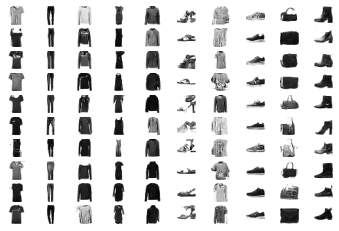

In [15]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)